# Package import

In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

import matplotlib.font_manager as fm

# RegulonDB Data Processing

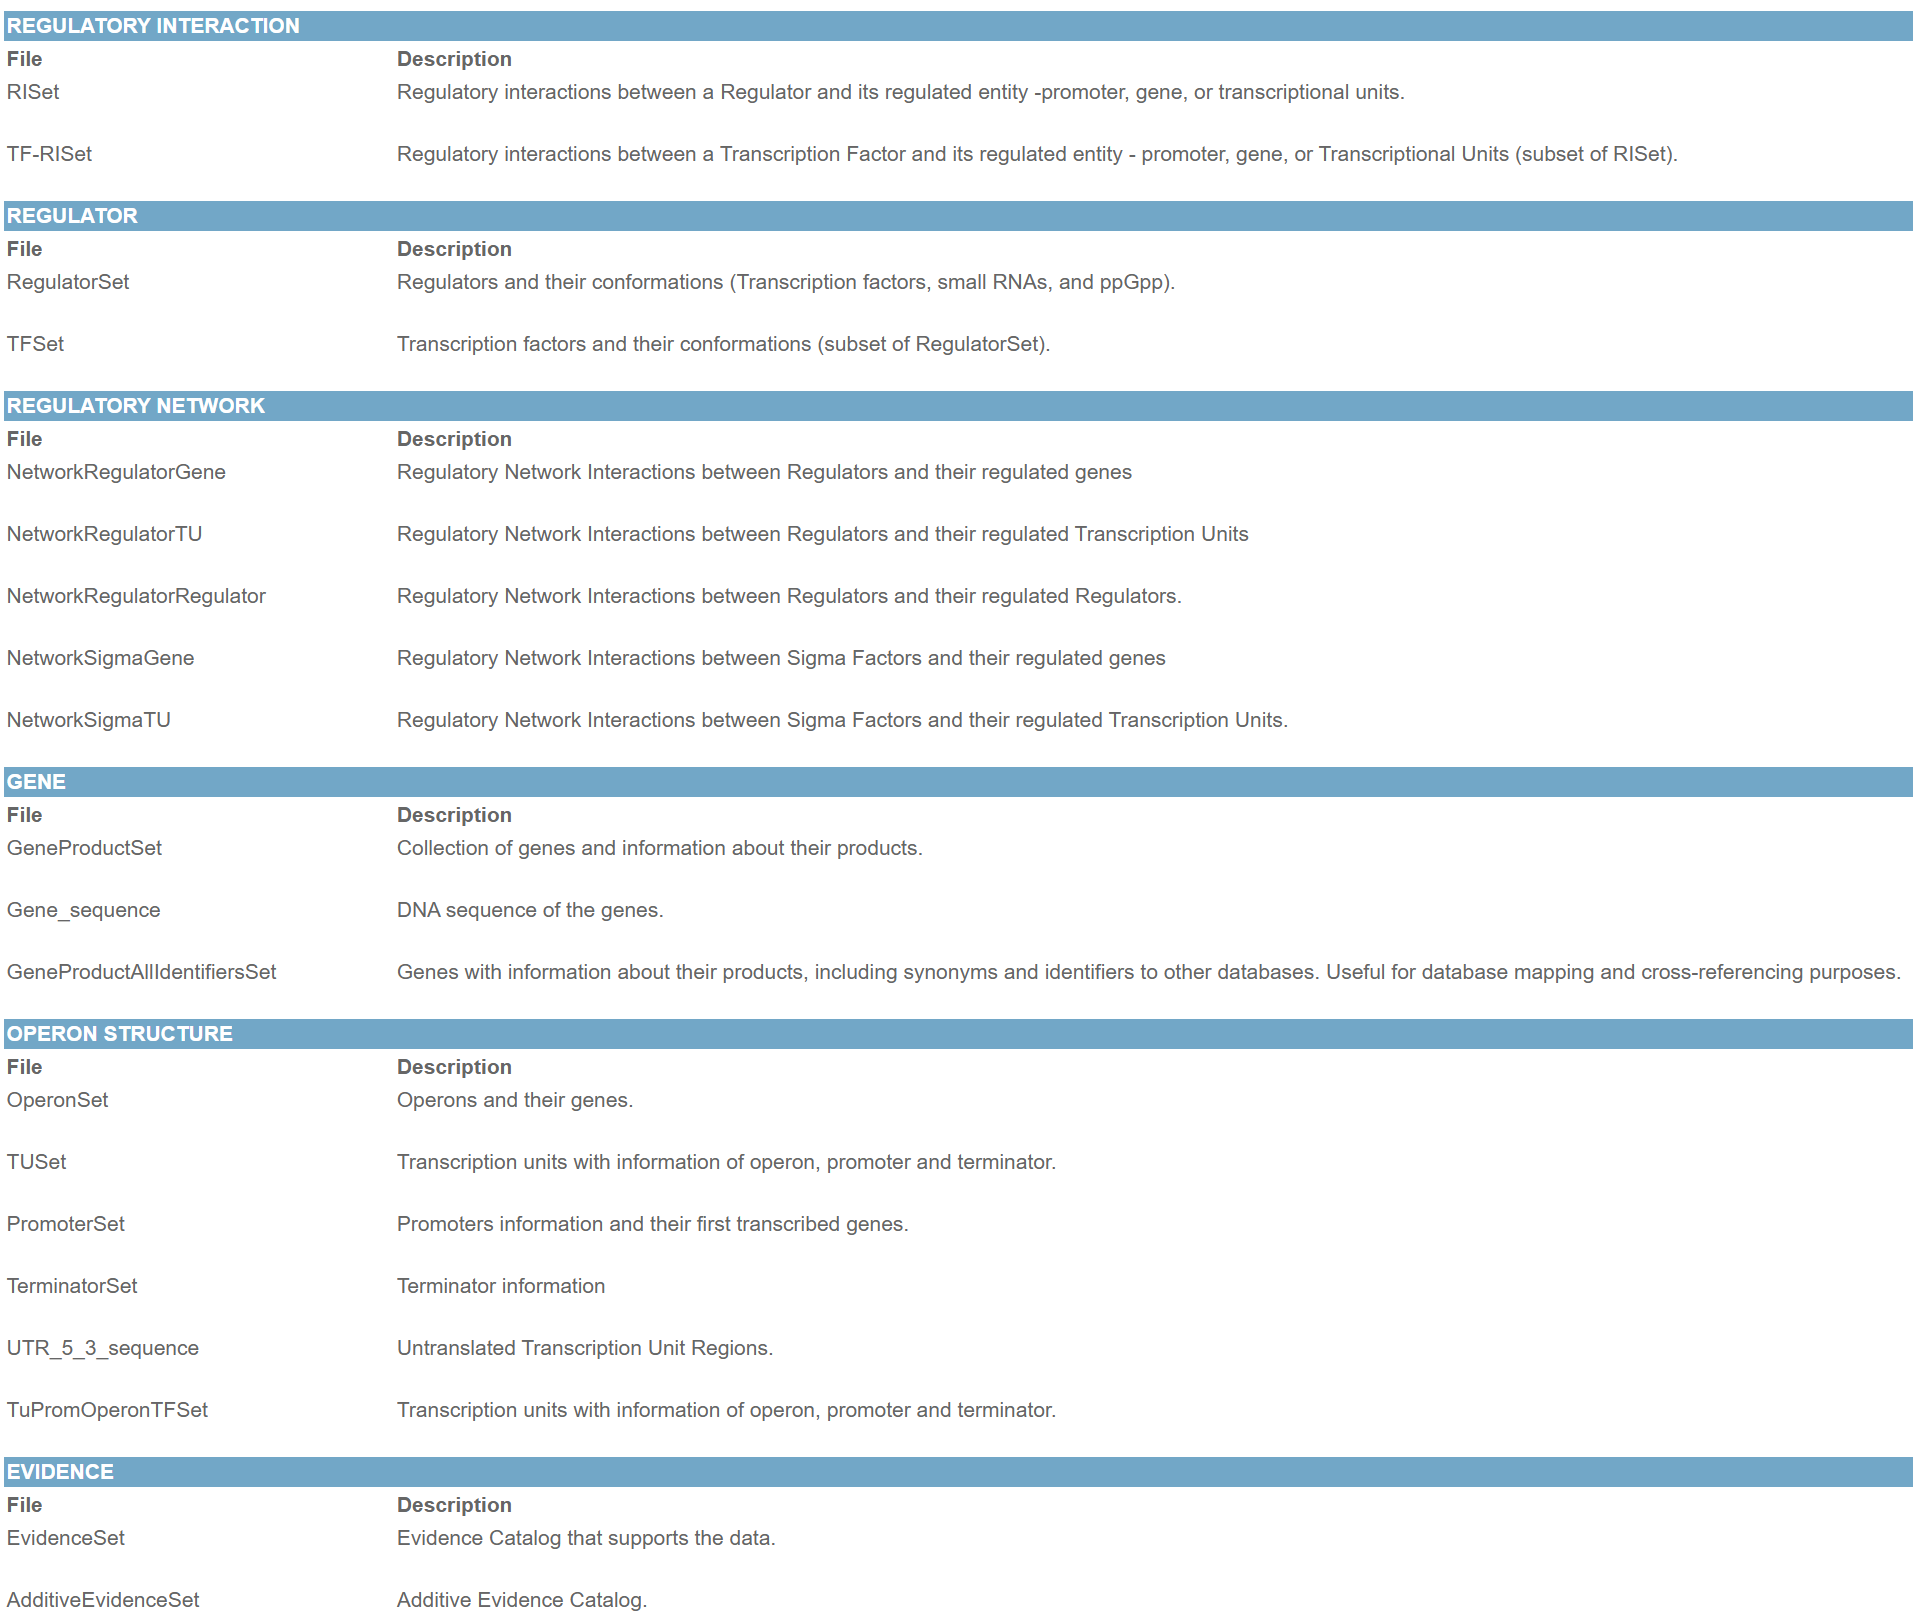

In [2]:
RegulonDB_Promoter_Set = pd.read_csv("../Data/RegulonDB_v13_08042024/PromoterSet.tsv", index_col=0, sep = '\t', comment='#')

# Precise1k and iModulon Data processing

## Load the data from ./Data/ folder

In [3]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [4]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [5]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [6]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [7]:
P1K_M = precise1k.M

In [8]:
P1K_A = precise1k.A

In [9]:
P1K_X = precise1k.X

In [10]:
P1K_log_tpm = precise1k.log_tpm

In [11]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [12]:
P1K_M = map_accession_to_gene_name(P1K_M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [13]:
P1K_X = map_accession_to_gene_name(P1K_X, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [14]:
P1K_log_tpm = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [15]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [16]:
iM_gene = P1K_Gene_Presence_Matrix.loc[P1K_Gene_Presence_Matrix.any(axis=1)]

In [17]:
iM_gene

Sugar Diacid  Translation   ygdT   OxyR  FlhDC-2  Osmoprotectant  \
Gene Name                                                                     
thrA              False        False  False  False    False           False   
thrB              False        False  False  False    False           False   
thrC              False        False  False  False    False           False   
yaaX              False        False  False  False    False           False   
yaaA              False        False  False   True    False           False   
...                 ...          ...    ...    ...      ...             ...   
yneP              False        False  False  False    False           False   
ynfT              False        False  False  False    False           False   
yoaL              False        False  False  False    False           False   
yqhI              False        False  False  False    False           False   
yqiD              False        False  False  False    False           False   

           Glutamine  Sialic Acid   yqhI  ROS TALE Amp  ...  Tryptophanase  \
Gene Name                                               ...                  
thrA           False         True  False         False  ...          False   
thrB           False        False  False         False  ...          False   
thrC           False        False  False         False  ...          False   
yaaX           False        False  False         False  ...          False   
yaaA           False        False  False         False  ...          False   
...              ...          ...    ...           ...  ...            ...   
yneP           False        False  False         False  ...          False   
ynfT           False        False  False         False  ...          False   
yoaL           False        False  False         False  ...          False   
yqhI           False        False   True         False  ...          False   
yqiD           False        False  False         False  ...          False   

           crp KO-2  cyoB/ndh/nuoB KO-2  tpiA KO  Phage Shock  Glyoxylate  \
Gene Name                                                                   
thrA          False               False    False        False       False   
thrB          False               False    False        False       False   
thrC          False               False    False        False       False   
yaaX          False               False    False        False       False   
yaaA          False               False    False        False       False   
...             ...                 ...      ...          ...         ...   
yneP          False               False    False        False       False   
ynfT          False               False    False        False       False   
yoaL          False               False    False        False       False   
yqhI          False               False    False        False       False   
yqiD          False               False    False        False       False   

           CCK-PGI Del  Acetate  Ile/Val   UC-8  
Gene Name                                        
thrA             False    False    False  False  
thrB             False    False    False  False  
thrC             False    False    False  False  
yaaX             False    False    False  False  
yaaA             False    False    False  False  
...                ...      ...      ...    ...  
yneP             False    False    False  False  
ynfT             False    False    False  False  
yoaL             False    False    False  False  
yqhI             False    False    False  False  
yqiD             False    False    False  False  

[2485 rows x 201 columns]

# Questions

## How many high confidence promoters are there in E. coli MG1655?

In [18]:
# Maybe need to cross-reference the genbank/regulonDB info with the Urtecho 2023 dataset

In [19]:
RegulonDB_Promoter_Set

2)pmName 3)strand   4)posTSS 5)sigmaFactor  \
1)pmId                                                        
RDBECOLIPMC00001     spyp  reverse  1825688.0       sigma70   
RDBECOLIPMC00002    yfeKp  forward  2537315.0       sigma24   
RDBECOLIPMC00003   bepAp1  forward  2616068.0       sigma24   
RDBECOLIPMC00004    bamBp  reverse  2638975.0       sigma24   
RDBECOLIPMC00005    recCp  reverse  2962507.0       sigma70   
...                   ...      ...        ...           ...   
RDBECOLIPMC04051   stfZp1  reverse   105313.0       sigma70   
RDBECOLIPMC04052    ameFp  forward  2911051.0           NaN   
RDBECOLIPMC04053   oppAp2  forward  1300916.0           NaN   
RDBECOLIPMC04054    yqjCp  forward  3248887.0       sigma28   
RDBECOLIPMC04055    yqjDp  forward  3249270.0       sigma28   

                                                       6)pmSequence  \
1)pmId                                                                
RDBECOLIPMC00001  acactttcattgttttaccgttgctctgattaattgacgctaaagt...   
RDBECOLIPMC00002  ccgatgatcctcatcgtaatccaaccgaaactttacctgattctgg...   
RDBECOLIPMC00003  gccgttacactcaaaggcggcgcggtgggaacgatatttcacagta...   
RDBECOLIPMC00004  aaatacttatggtgcgctggcttctttggaacttgcgcagcaattt...   
RDBECOLIPMC00005  tgccaactggcaggtcaaccgaatgcagacatcgcaggcgggatgt...   
...                                                             ...   
RDBECOLIPMC04051  accgccgccgccgccgacgccgatgactttaatcaccgcgtcattg...   
RDBECOLIPMC04052  aggacaacagctggacgatgtccagcttgctcgctaccttttgtcg...   
RDBECOLIPMC04053  gcttaacaattttgcaaaatgtattggcgagtaagaaccgcatttg...   
RDBECOLIPMC04054  ctgttatccgaaacatatcactcactttggtgatttcaccgtaact...   
RDBECOLIPMC04055  tggcggaacgccagcaagatttagccgaggcgaagcaaaaaggcga...   

                 7)firstGeneName  8)distToFirstGene  \
1)pmId                                                
RDBECOLIPMC00001             spy              -63.0   
RDBECOLIPMC00002            yfeK              -27.0   
RDBECOLIPMC00003            bepA              -26.0   
RDBECOLIPMC00004            bamB             -323.0   
RDBECOLIPMC00005            recC              -79.0   
...                          ...                ...   
RDBECOLIPMC04051            stfZ              186.0   
RDBECOLIPMC04052            ameF                0.0   
RDBECOLIPMC04053            oppA             -266.0   
RDBECOLIPMC04054            yqjC              -82.0   
RDBECOLIPMC04055            yqjD             -105.0   

                                                       9)pmEvidence  \
1)pmId                                                                
RDBECOLIPMC00001  [COMP-AINF:W][COMP-HINF-POSITIONAL-IDENTIFICAT...   
RDBECOLIPMC00002  [COMP-AINF:W][COMP-AINF-POSITIONAL-IDENTIFICAT...   
RDBECOLIPMC00003  [COMP-AINF:W][COMP-AINF-POSITIONAL-IDENTIFICAT...   
RDBECOLIPMC00004  [COMP-AINF:W][COMP-AINF-POSITIONAL-IDENTIFICAT...   
RDBECOLIPMC00005  [COMP-HINF-POSITIONAL-IDENTIFICATION:W][EXP-ID...   
...                                                             ...   
RDBECOLIPMC04051  [EXP-IDA-TRANSCRIPTION-INIT-MAPPING-PRIMER-EXT...   
RDBECOLIPMC04052  [EXP-IDA-TRANSCRIPTION-INIT-MAPPING:S][EXP-IMP:W]   
RDBECOLIPMC04053  [EXP-IDA-TRANSCRIPTION-INIT-MAPPING-PRIMER-EXT...   
RDBECOLIPMC04054  [COMP-HINF-POSITIONAL-IDENTIFICATION:W][EXP-ID...   
RDBECOLIPMC04055  [COMP-HINF-POSITIONAL-IDENTIFICATION:W][EXP-ID...   

                 10)addEvidence 11)confidenceLevel  \
1)pmId                                               
RDBECOLIPMC00001            NaN                  S   
RDBECOLIPMC00002            NaN                  S   
RDBECOLIPMC00003            NaN                  S   
RDBECOLIPMC00004            NaN                  S   
RDBECOLIPMC00005            NaN                  S   
...                         ...                ...   
RDBECOLIPMC04051            NaN                  W   
RDBECOLIPMC04052            NaN                  S   
RDBECOLIPMC04053            NaN               None   
RDBECOLIPMC04054            NaN        

In [20]:
RegulonDB_Promoter_Set['11)confidenceLevel'].value_counts()

W       2517
S       1455
C         79
None       1
Name: 11)confidenceLevel, dtype: int64

> **Weak evidence (W)**: Single evidence with more ambiguous conclusions, where alternative explanations, indirect effects, or potential false positives are prevalent,
> 
    as well as computational predictions; for instance gel mobility shift assays with cell extracts or gene expression analysis.
> 
> **Strong evidence (S)**: Single evidence with direct physical interaction or solid genetic evidence with a low probability for alternative explanations;
> 
    for instance, footprinting with purified protein or site mutation.
> 
> **Confirmed (C)**: is assigned, if objects are supported by at least two independent types of strong evidence with mutually excluding false positives.
> 
    This approach is based essentially on the methods used to validate results and exclude alternative explanations in scientific research.

**S + C = 1455 + 79 = 1534**

## What does gene expression magnitude vs gene expression variation look like in P1k?

In [21]:
# Repeat of Cam's plot from the p1k study

In [302]:
P1K_merged = pd.read_csv('../Data/P1K_merged.csv', index_col=0)

In [303]:
P1K_merged

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thrA                  0.899430                  0.686194        thrA KO   
thrB                  0.808533                  0.254512        thrA KO   
thrC                  0.824916                  0.246587        thrA KO   
yaaX                  0.689923                  0.171007    Leu/Val/Ile   
yaaA                  0.638300                  0.428612           OxyR   
...                        ...                       ...            ...   
yneP                  0.748917                  0.629455           yneP   
ynfT                  0.467147                  0.424437     Cold Shock   
yoaL                  0.333663                  0.102746           CpxR   
yqhI                  0.894360                  0.738529           yqhI   
yqiD                  0.896335                  0.554369          Fnr-2   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
thrA                  0.076638         Cysteine-1                  0.075628   
thrB                  0.227884        Leu/Val/Ile                  0.103394   
thrC                  0.234486        Leu/Val/Ile                  0.155906   
yaaX                  0.169602  Nucleotide Stress                  0.095365   
yaaA                  0.171808         Cold Shock                  0.129606   
...                        ...                ...                       ...   
yneP                  0.075002              GadXW                  0.047460   
ynfT                  0.045140                NRZ                  0.033476   
yoaL                  0.066571          Cellulose                  0.044315   
yqhI                  0.091457               UC-8                  0.084815   
yqiD                  0.396718              Fnr-3                  0.087869   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrA     Thiamine-1               3       3  0.702916        9.605329   
thrB        Leucine               1       2  0.698539        9.232803   
thrC      Dipeptide               1       1  0.611282        9.274271   
yaaX      Glycolate               0       3  0.737317        6.283661   
yaaA           UC-8               0       1  0.306569        6.346626   
...             ...             ...     ...       ...             ...   
yneP     Resistance               0       1  1.062231        1.132974   
ynfT            LPS               0       2  1.778052        2.460854   
yoaL          ppGpp               0       2  0.540346        5.048395   
yqhI     Resistance               0       2  1.185744        1.185744   
yqiD           ArcA               0       4  1.060502        5.068548   

      range_log_tpm  quantile_range_log_tpm  
thrA      11.771901                4.369602  
thrB       6.968977                3.899146  
thrC       6.987691                3.672202  
yaaX      11.817918                4.398450  
yaaA       6.392433                1.916179  
...             ...                     ...  
yneP       4.458041                2.867823  
ynfT       7.650393                6.188452  
yoaL       5.552991                2.832758  
yqhI       7.305199                4.979694  
yqiD      11.535971                6.504470  

[4257 rows x 13 columns]

In [24]:
def scatter_plot_with_box_plots(dataframe, mad_column, median_column, x_label, y_label, title, ratio=0.2, x_lim=None, y_lim=None, color='blue'):
    # Set the aesthetic style of the plots
    sns.set(style="white")

    # Create the figure and axes
    fig = plt.figure(figsize=(4, 4))

    # Define grid spec with ratio adjustment
    height_ratios = [ratio, 1-ratio]  # ratio for the top subplot, remaining for the main plot
    width_ratios = [1-ratio, ratio]   # ratio for the main plot, remaining for the right subplot

    grid = plt.GridSpec(2, 2, height_ratios=height_ratios, width_ratios=width_ratios, hspace=0.05, wspace=0.05)

    # Main scatter plot
    main_ax = fig.add_subplot(grid[1, 0])
    main_ax.scatter(dataframe[median_column], dataframe[mad_column], color=color, alpha=0.5)
    main_ax.set_xlabel(x_label)
    main_ax.set_ylabel(y_label)
    main_ax.grid(False)
    main_ax.spines['top'].set_linewidth(1)
    main_ax.spines['right'].set_linewidth(1)
    main_ax.spines['bottom'].set_linewidth(1)
    main_ax.spines['left'].set_linewidth(1)
    main_ax.tick_params(top=False, right=False, which='both', labeltop=False, labelright=False)
    
    # Set the limits for the main scatter plot if provided
    if x_lim:
        main_ax.set_xlim(x_lim)
    if y_lim:
        main_ax.set_ylim(y_lim)

    # Box plot for the x-axis
    x_box = fig.add_subplot(grid[0, 0], sharex=main_ax)
    sns.boxplot(x=dataframe[median_column], ax=x_box, color=color)
    x_box.set(xlabel='')
    x_box.set(yticks=[], ylabel='')
    x_box.grid(False)
    x_box.spines['top'].set_linewidth(1)
    x_box.spines['right'].set_linewidth(1)
    x_box.spines['bottom'].set_linewidth(1)
    x_box.spines['left'].set_linewidth(1)
    x_box.tick_params(bottom=False, top=False, labelbottom=False)

    # Box plot for the y-axis
    y_box = fig.add_subplot(grid[1, 1], sharey=main_ax)
    sns.boxplot(y=dataframe[mad_column], ax=y_box, color=color)
    y_box.set(ylabel='')
    y_box.set(xticks=[], xlabel='')
    y_box.grid(False)
    y_box.spines['top'].set_linewidth(1)
    y_box.spines['right'].set_linewidth(1)
    y_box.spines['bottom'].set_linewidth(1)
    y_box.spines['left'].set_linewidth(1)
    y_box.tick_params(left=False, right=False, labelleft=False)

    # Add titles and labels
    x_box.set_title(title, y=1.1)

    # Show the plot
    plt.show()

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    plt.figure(figsize=(15, 2))
    # Create scatter plot
    plt.scatter(x_values, y_values, label='Data points')

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='red', label='Line of best fit')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Display the plot with labels and legend
    plt.xlabel(gene_name)
    plt.ylabel(imodulon_name)
    plt.title(f'Scatter Plot of {gene_name} Expression and {imodulon_name} Activity\n$R^2$ = {r2:.2f}')
    plt.legend()
    plt.show()

In [26]:
def calculate_explained_variance(M_matrix, A_matrix, log_tpm):
    # Check if inputs are DataFrames and convert to numpy arrays if needed
    if isinstance(M_matrix, pd.DataFrame) or isinstance(M_matrix, pd.Series):
        M_matrix = M_matrix.values.flatten()
    
    if isinstance(A_matrix, pd.DataFrame):
        A_matrix = A_matrix.values
    
    if isinstance(log_tpm, pd.DataFrame) or isinstance(log_tpm, pd.Series):
        log_tpm = log_tpm.values.flatten()
    
    # Compute the predicted values
    predicted_values = np.dot(M_matrix, A_matrix)  # M_matrix is 1xM, A_matrix is MxN, result is 1xN

    # Calculate the baseline (mean-centered log_tpm)
    baseline = log_tpm - np.mean(log_tpm)  # mean-center the log_tpm

    # Calculate the residual variance
    residuals = log_tpm - predicted_values
    residual_variance = np.sum((residuals - np.mean(residuals)) ** 2)

    # Calculate the total variance
    total_variance = np.sum((log_tpm - np.mean(log_tpm)) ** 2)

    # Compute the explained variance (R^2)
    explained_variance = 1 - (residual_variance / total_variance)
    
    return explained_variance

In [27]:
def compute_explained_variance_change(M, A, X, P1K_Gene_Presence_Matrix, gene):

    M = M.loc[[gene]]
    X = X.loc[[gene]]
    
    # Calculate the original explained variance
    original_exp_var = calculate_explained_variance(M, A, X)
    
    # Initialize a dictionary to store the explained variance changes
    exp_var_changes = {}

    # Iterate through each row of A
    for row_name in A.index:
        # Remove the corresponding row from A
        modified_A = A.drop(row_name, axis=0)
        
        # Remove the corresponding column from M and X
        modified_M = M.drop(row_name, axis=1)
        modified_X = X
        
        # Recalculate the explained variance
        new_exp_var = calculate_explained_variance(modified_M, modified_A, modified_X)
        
        # Calculate the change in explained variance
        exp_var_change = original_exp_var - new_exp_var
        
        # Store the result in the dictionary
        exp_var_changes[row_name] = exp_var_change

    # Convert the dictionary to a DataFrame
    explained_variance_df = pd.DataFrame.from_dict(exp_var_changes, orient='index', columns=['Explained Variance'])
    explained_variance_df.reset_index(inplace=True)

    
    explained_variance_df.columns = ['iModulon', 'Explained Variance Change if removed']

    explained_variance_df = explained_variance_df.sort_values(by='Explained Variance Change if removed', ascending=False)
    
    explained_variance_df['Presence'] = explained_variance_df['iModulon'].apply(
        lambda x: 'Yes' if P1K_Gene_Presence_Matrix.loc[gene, x] else 'No'
    )
    
    # Calculate and print the sum of Explained Variance for 'Presence Yes' and 'Presence No'
    presence_yes_sum = explained_variance_df[explained_variance_df['Presence'] == 'Yes']['Explained Variance Change if removed'].sum()
    presence_no_sum = explained_variance_df[explained_variance_df['Presence'] == 'No']['Explained Variance Change if removed'].sum()
    
    # print(f"Sum of Explained Variance for 'Yes' iMs: {presence_yes_sum}")
    # print(f"Sum of Explained Variance for 'No' iMs: {presence_no_sum}")
    
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Plot the explained variance for each iModulon
    plt.figure(figsize=(15, 3))
    plt.bar(explained_variance_df['iModulon'], explained_variance_df['Explained Variance Change if removed'])
    plt.xlabel('iModulon', fontproperties=font_prop)
    plt.ylabel('Explained Variance', fontproperties=font_prop)
    plt.title(f'Explained Variance by iModulon for Gene {gene}', fontproperties=font_prop)
    
    # Remove grid
    plt.grid(False)
    
    # Add a black border around the plot
    plt.gca().spines['top'].set_linewidth(1.0)
    plt.gca().spines['bottom'].set_linewidth(1.0)
    plt.gca().spines['left'].set_linewidth(1.0)
    plt.gca().spines['right'].set_linewidth(1.0)
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

    # Set font properties for ticks
    plt.xticks(fontproperties=font_prop, fontsize=10)  # Adjust fontsize for x-ticks
    plt.yticks(fontproperties=font_prop)

    # Remove x-ticks
    plt.xticks([])

    plt.show()
    return explained_variance_df

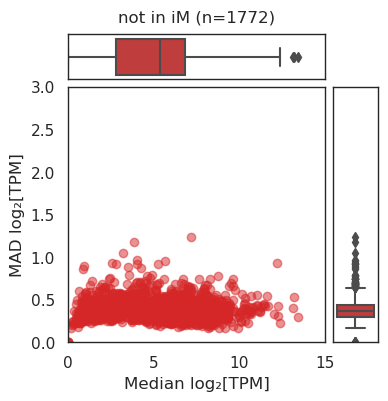

In [28]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'MAD', 'log_TPM_median', 'Median log₂[TPM]', 'MAD log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,15), y_lim=(0,3), color='#d62728')

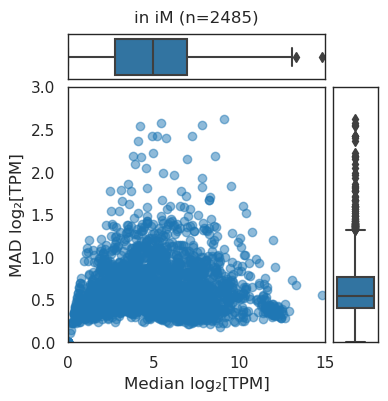

In [29]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'MAD', 'log_TPM_median', 'Median log₂[TPM]', 'MAD log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,15), y_lim=(0,3), color='#1f77b4')

In [30]:
P1K_merged.columns

Index(['Total_Explained_Variance', 'Top_1_Explained_Variance',
       'Top_1_iModulon', 'Top_2_Explained_Variance', 'Top_2_iModulon',
       'Top_3_Explained_Variance', 'Top_3_iModulon', 'num_regulators',
       'num_iM', 'MAD', 'log_TPM_median', 'range_log_tpm',
       'quantile_range_log_tpm'],
      dtype='object')

### MAD v.s. Total_Explained_Variance

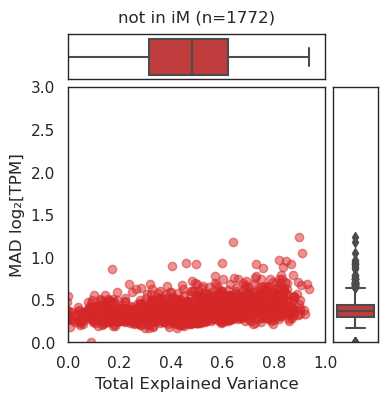

In [31]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'MAD', 'Total_Explained_Variance', 'Total Explained Variance', 'MAD log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#d62728')

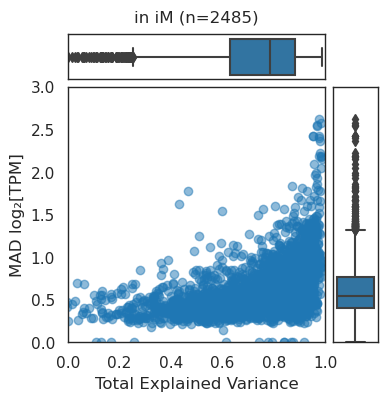

In [32]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'MAD', 'Total_Explained_Variance', 'Total Explained Variance', 'MAD log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#1f77b4')

### MAD v.s. Top_1_Explained_Variance

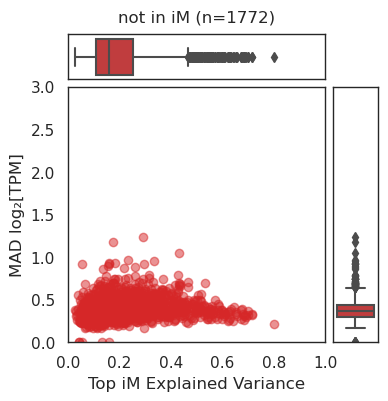

In [33]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'MAD', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'MAD log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#d62728')

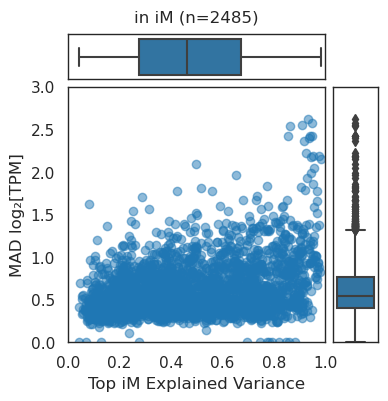

In [34]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'MAD', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'MAD log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,3), color='#1f77b4')

### Total_Explained_Variance v.s. Top_1_Explained_Variance

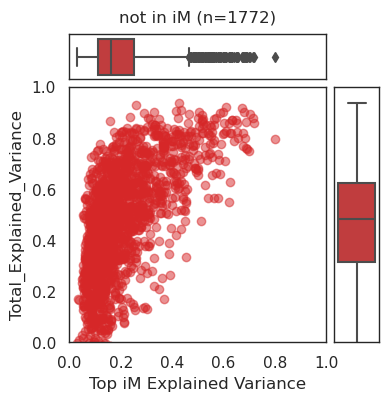

In [35]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'Total_Explained_Variance', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'Total_Explained_Variance', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,1), color='#d62728')

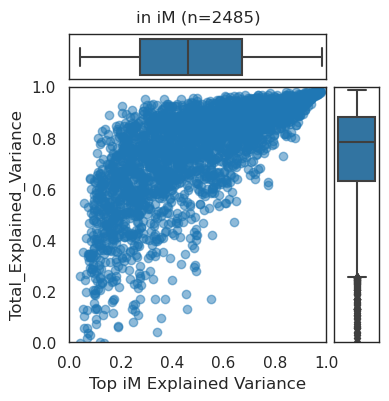

In [36]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'Total_Explained_Variance', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'Total_Explained_Variance', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,1), color='#1f77b4')

In [37]:
P1K_merged[(P1K_merged['Total_Explained_Variance'] < 0.1) & (P1K_merged['Top_1_Explained_Variance'] < 0.1)]

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
mbiA                 -0.111055                  0.090604           UC-5   
fixX                  0.016148                  0.070135           UC-2   
yaaU                  0.010478                  0.036379    Translation   
hofC                 -0.392463                  0.043687           UC-1   
dksA                 -0.019715                  0.071485           UC-8   
...                        ...                       ...            ...   
ylbE                  0.079831                  0.073881    Efflux Pump   
ybfK                 -0.136118                  0.054935           yneP   
ytcA                 -0.360113                  0.041261           RpoE   
aaaD                 -0.019719                  0.060060          ppGpp   
ypjI                 -0.127160                  0.071093       SSW SNPs   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
mbiA                  0.079584      DNA Damage                  0.073846   
fixX                  0.036621     Efflux Pump                  0.033455   
yaaU                  0.025086  FucR/AllR/AraC                  0.023241   
hofC                  0.038587         baeR KO                  0.036615   
dksA                  0.046670            UC-7                  0.041621   
...                        ...             ...                       ...   
ylbE                  0.052618            gcvB                  0.048600   
ybfK                  0.028860     Phosphate-2                  0.022051   
ytcA                  0.040898            UC-2                  0.020968   
aaaD                  0.054926           Fnr-2                  0.045857   
ypjI                  0.040261         Glycine                  0.021069   

      Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
mbiA            UC-6               1       1  0.344671        0.594516   
fixX             LPS               2       1  0.452503        1.067281   
yaaU         Leucine               1       0  0.265966        0.935804   
hofC  nquinone ALE 3               2       0  0.249276        2.464637   
dksA        Flagella               0       0  0.292394        9.821839   
...              ...             ...     ...       ...             ...   
ylbE     Translation               0       0  0.345812        1.600979   
ybfK        SSW SNPs               0       0  0.000000        0.000000   
ytcA            PlaR               0       0  0.000000        0.000000   
aaaD            UC-7               0       0  0.441638        1.146189   
ypjI            ydaG               0       0  0.363043        0.363043   

      range_log_tpm  quantile_range_log_tpm  
mbiA       4.124902                1.753399  
fixX       4.073628                2.146699  
yaaU       3.759078                1.410842  
hofC       3.432930                1.401694  
dksA       9.380926                1.897957  
...             ...                     ...  
ylbE       3.765633                1.814542  
ybfK       3.348480                0.842443  
ytcA       2.914991                1.049006  
aaaD       3.895771                2.215998  
ypjI       3.609087                1.475925  

[108 rows x 13 columns]

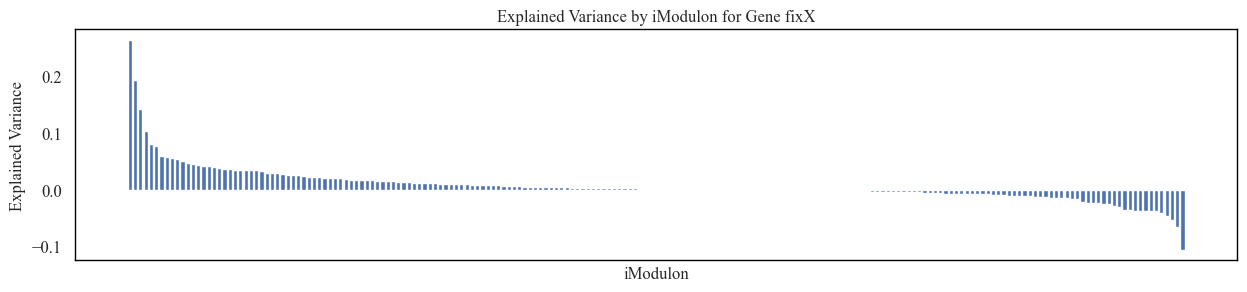

iModulon  Explained Variance Change if removed Presence
164    minicoli KOs                              0.264344       No
92            Crp-1                              0.193260       No
167            UC-2                              0.141767       No
81         crp KO-1                              0.103201       No
192        crp KO-2                              0.080147       No
..              ...                                   ...      ...
94           NtrC-1                             -0.040070       No
74             ArcA                             -0.046058       No
126      Thiamine-1                             -0.053959       No
146       Glycolate                             -0.065828       No
5    Osmoprotectant                             -0.106059       No

[201 rows x 3 columns]

In [38]:
compute_explained_variance_change(P1K_M, P1K_A, P1K_X, P1K_Gene_Presence_Matrix, 'fixX')

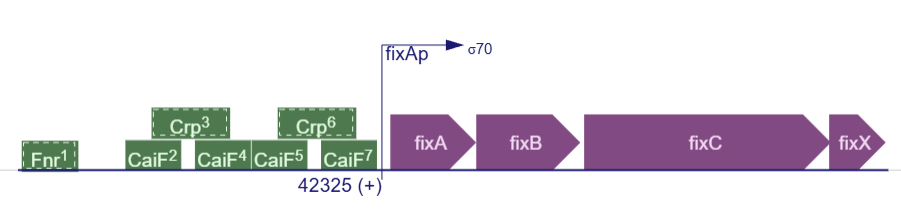

ydfW

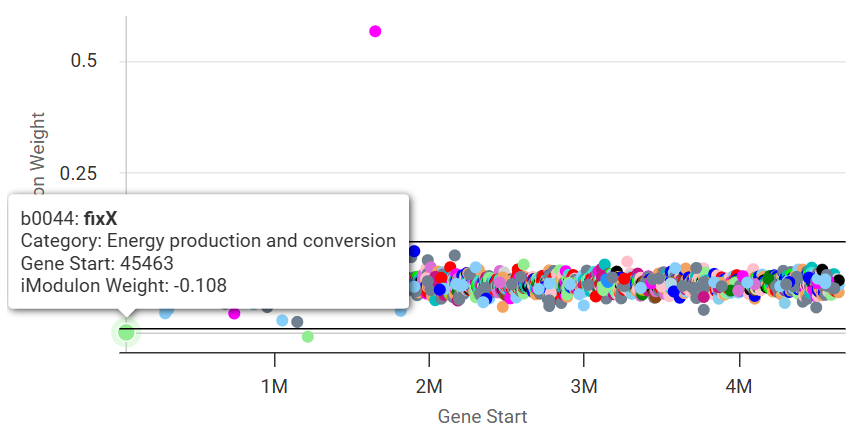

In [39]:
P1K_merged[(P1K_merged['Total_Explained_Variance'] < 0.1) & (P1K_merged['Top_1_Explained_Variance'] < 0.4)]

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yaaW                 -0.197540                  0.184582     Cold Shock   
mbiA                 -0.111055                  0.090604           UC-5   
caiB                 -0.060414                  0.100315   Microaerobic   
fixA                  0.068155                  0.158253  Tryptophanase   
fixX                  0.016148                  0.070135           UC-2   
...                        ...                       ...            ...   
ybfK                 -0.136118                  0.054935           yneP   
ytcA                 -0.360113                  0.041261           RpoE   
aaaD                 -0.019719                  0.060060          ppGpp   
ypjI                 -0.127160                  0.071093       SSW SNPs   
yqcG                  0.088879                  0.160563           gcvB   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yaaW                  0.082831    Translation                  0.062717   
mbiA                  0.079584     DNA Damage                  0.073846   
caiB                  0.085382     Methionine                  0.065316   
fixA                  0.092234           UC-3                  0.075987   
fixX                  0.036621    Efflux Pump                  0.033455   
...                        ...            ...                       ...   
ybfK                  0.028860    Phosphate-2                  0.022051   
ytcA                  0.040898           UC-2                  0.020968   
aaaD                  0.054926          Fnr-2                  0.045857   
ypjI                  0.040261        Glycine                  0.021069   
yqcG                  0.037913           ymdG                  0.031955   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaW           UC-6               0       0  0.360424        2.109164   
mbiA           UC-6               1       1  0.344671        0.594516   
caiB          Fnr-3               3       0  0.356151        2.850299   
fixA            LPS               2       0  0.362466        1.291711   
fixX            LPS               2       1  0.452503        1.067281   
...             ...             ...     ...       ...             ...   
ybfK       SSW SNPs               0       0  0.000000        0.000000   
ytcA           PlaR               0       0  0.000000        0.000000   
aaaD           UC-7               0       0  0.441638        1.146189   
ypjI           ydaG               0       0  0.363043        0.363043   
yqcG           yneP               0       0  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm  
yaaW       4.097773                1.758149  
mbiA       4.124902                1.753399  
caiB       3.694327                1.883417  
fixA       4.795469                1.767795  
fixX       4.073628                2.146699  
...             ...                     ...  
ybfK       3.348480                0.842443  
ytcA       2.914991                1.049006  
aaaD       3.895771                2.215998  
ypjI       3.609087                1.475925  
yqcG       3.558419                1.528627  

[201 rows x 13 columns]

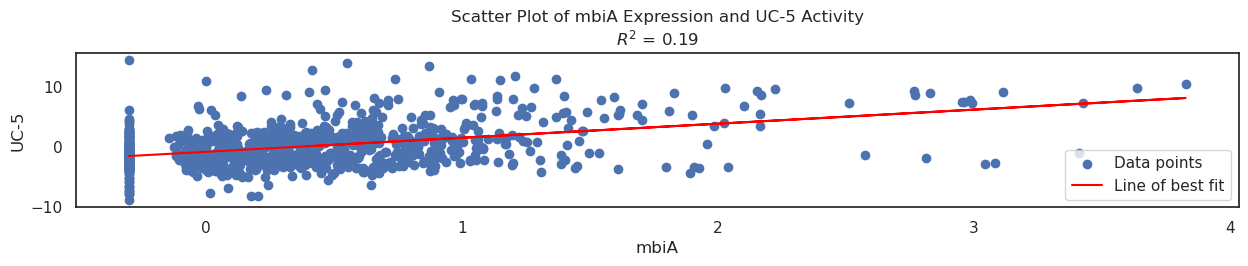

In [40]:
plot_scatter_with_fit(P1K_X, P1K_A, 'mbiA', 'UC-5')

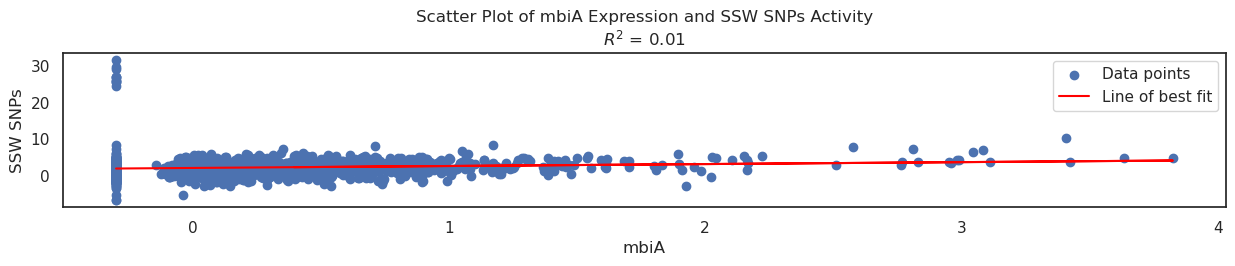

In [41]:
plot_scatter_with_fit(P1K_X, P1K_A, 'mbiA', 'SSW SNPs')

SSW SNPs

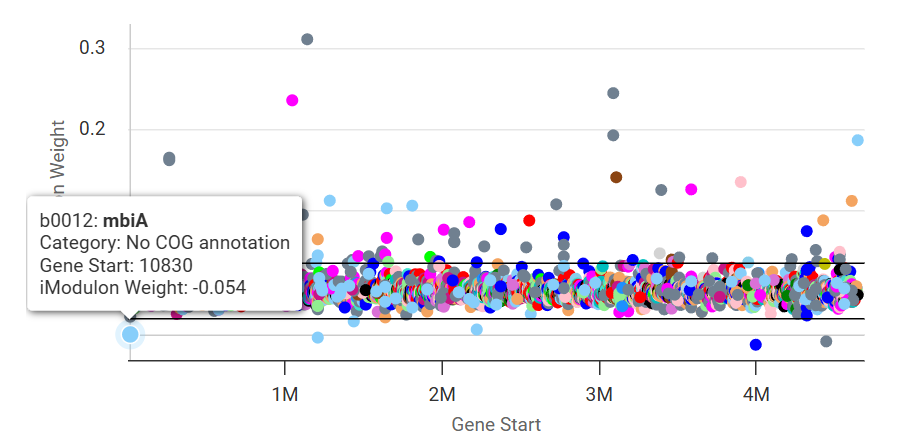

### Range v.s. Top_1_Explained_Variance

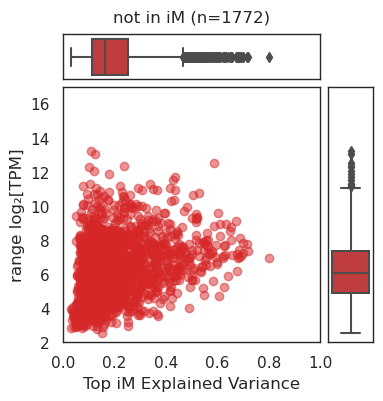

In [42]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'range log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(2,17), color='#d62728')

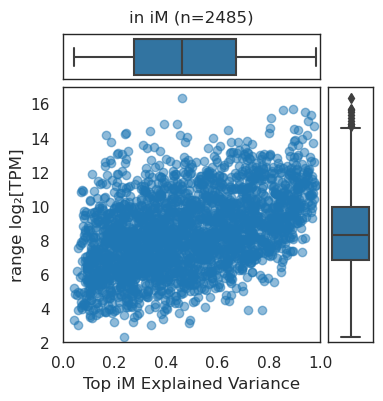

In [43]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'range log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(2,17), color='#1f77b4')

### Quantile Range v.s. Top_1_Explained_Variance

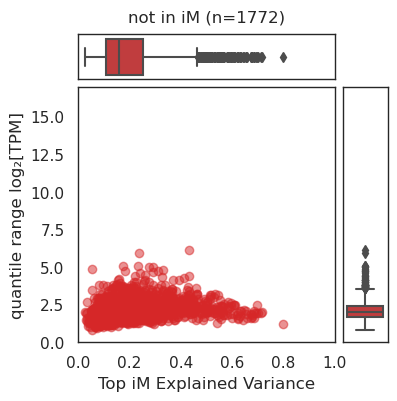

In [44]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'quantile_range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'quantile range log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,1), y_lim=(0,17), color='#d62728')

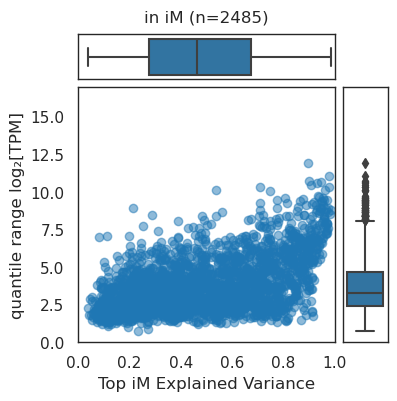

In [45]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'quantile_range_log_tpm', 'Top_1_Explained_Variance', 'Top iM Explained Variance', 'quantile range log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,1), y_lim=(0,17), color='#1f77b4')

### Range v.s. MAD

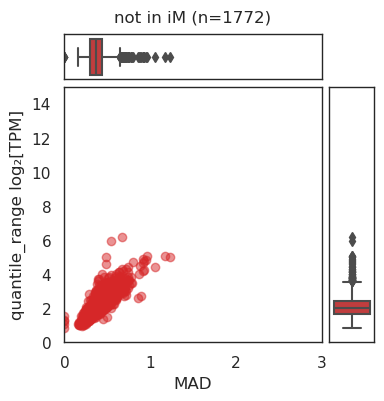

In [46]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] == 0], 'quantile_range_log_tpm', 'MAD', 'MAD', 'quantile_range log₂[TPM]', 'not in iM (n=1772)', ratio = 0.15, x_lim=(0,3), y_lim=(0,15), color='#d62728')

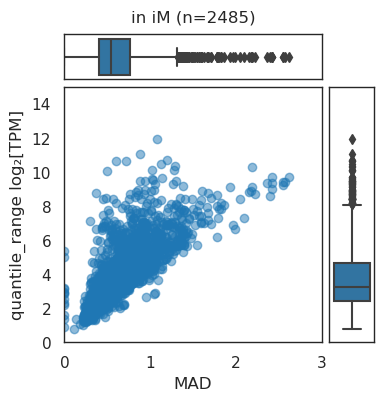

In [47]:
scatter_plot_with_box_plots(P1K_merged[P1K_merged['num_iM'] != 0], 'quantile_range_log_tpm', 'MAD', 'MAD', 'quantile_range log₂[TPM]', 'in iM (n=2485)', ratio = 0.15, x_lim=(0,3), y_lim=(0,15), color='#1f77b4')

In [48]:
# rank the genes by the M values in iM - if they are close to threshold

In [49]:
# left bottom corner - examples - MAD 1.5 - <0.2 top exp var

## In each of the 9 expression categories, how many regulons and iMs does each gene participate in? 

In [50]:
# Categories are high expression high variance, medium expression high variance, and so on, with thresholds we'll have to try to determine by elbows

#### Threshold set to similar to Cam

In [507]:
from kneed import KneeLocator

mad_values = P1K_merged['MAD'].values

# Sort the MAD values
sorted_mad_values = sorted(mad_values)

# Find the elbow point
kneedle = KneeLocator(range(len(sorted_mad_values)), sorted_mad_values, curve='convex', direction='increasing')
elbow_point = kneedle.elbow

# Elbow value in terms of MAD
elbow_value = sorted_mad_values[elbow_point]

# Define thresholds
high_variance_threshold = elbow_value - 0.5
low_variance_threshold = elbow_value / 4 - 0.118

# Classify the genes
P1K_merged['Variance_Category'] = pd.cut(
    P1K_merged['MAD'],
    bins=[-np.inf, low_variance_threshold, high_variance_threshold, np.inf],
    labels=['Low Variance', 'Medium Variance', 'High Variance']
)

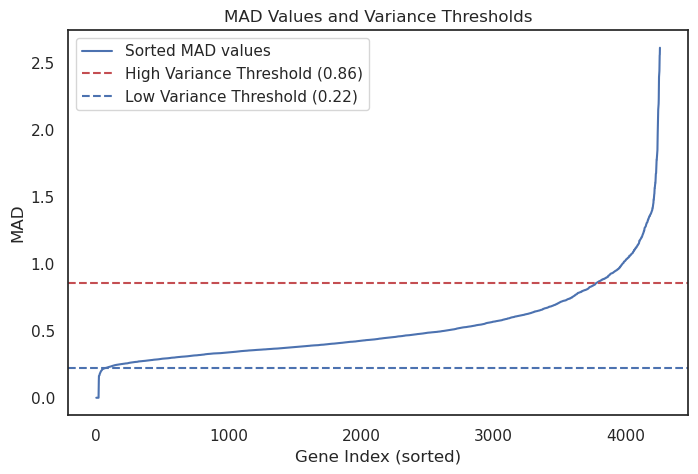

In [508]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_mad_values, label='Sorted MAD values')

# Add high variance threshold
plt.axhline(y=high_variance_threshold, color='r', linestyle='--', label=f'High Variance Threshold ({high_variance_threshold:.2f})')

# Add low variance threshold
plt.axhline(y=low_variance_threshold, color='b', linestyle='--', label=f'Low Variance Threshold ({low_variance_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('MAD')
plt.title('MAD Values and Variance Thresholds')
plt.legend()

# Show the plot
plt.show()

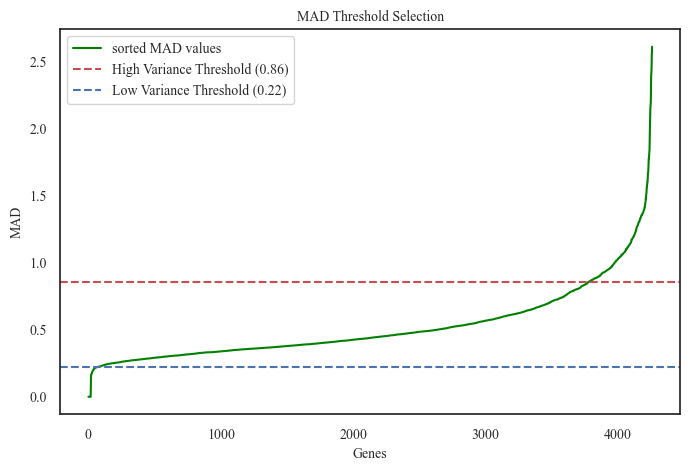

In [511]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(sorted_mad_values, label='sorted MAD values', color='green')

# Add high variance threshold
plt.axhline(y=high_variance_threshold, color='r', linestyle='--', label=f'High Variance Threshold ({high_variance_threshold:.2f})')

# Add low variance threshold
plt.axhline(y=low_variance_threshold, color='b', linestyle='--', label=f'Low Variance Threshold ({low_variance_threshold:.2f})')

# Add labels and title with custom font
plt.xlabel('Genes', fontproperties=font_prop)
plt.ylabel('MAD', fontproperties=font_prop)
plt.title('MAD Threshold Selection', fontproperties=font_prop)

# Set custom font for ticks
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

# Add legend with custom font
plt.legend(prop=font_prop)

# Save the plot as SVG
output_path = "MAD_threshold_selection.svg"
plt.savefig(output_path, format='svg')
plt.show()

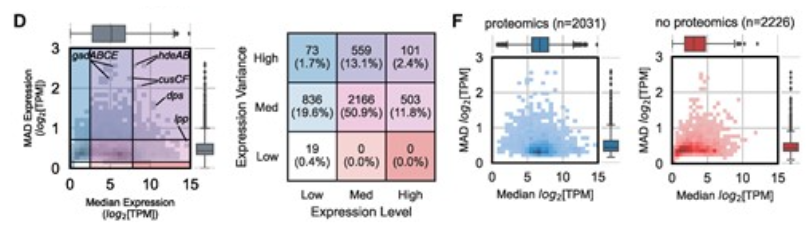

In [512]:
# Extract the log_TPM_median column
log_tpm_median_values = P1K_merged['log_TPM_median'].values

# Sort the log_TPM_median values
sorted_log_tpm_median_values = sorted(log_tpm_median_values)

# Find the elbow point
kneedle_tpm = KneeLocator(range(len(sorted_log_tpm_median_values)), sorted_log_tpm_median_values, curve='convex', direction='increasing')
elbow_point_tpm = kneedle_tpm.elbow

# Elbow value in terms of log_TPM_median
elbow_value_tpm = sorted_log_tpm_median_values[elbow_point_tpm]

# Define thresholds
high_expression_threshold = elbow_value_tpm - 2.5
low_expression_threshold = elbow_value_tpm / 3 - 0.8# This is arbitrary, adjust as needed

# Classify the genes
P1K_merged['Expression_Category'] = pd.cut(
    P1K_merged['log_TPM_median'],
    bins=[-np.inf, low_expression_threshold, high_expression_threshold, np.inf],
    labels=['Low Expression', 'Medium Expression', 'High Expression']
)

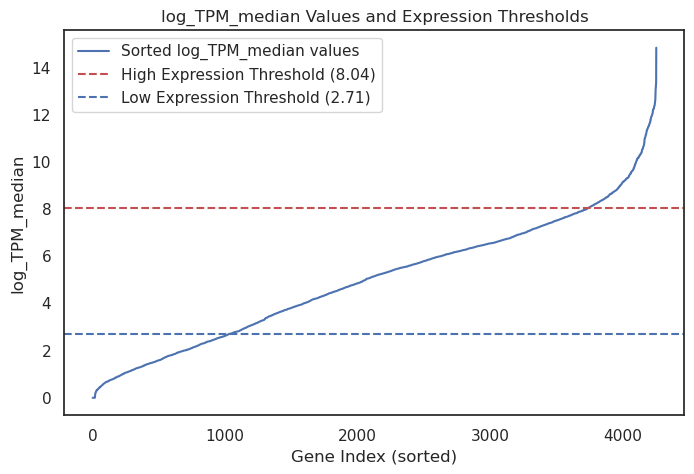

In [513]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_log_tpm_median_values, label='Sorted log_TPM_median values')

# Add high expression threshold
plt.axhline(y=high_expression_threshold, color='r', linestyle='--', label=f'High Expression Threshold ({high_expression_threshold:.2f})')

# Add low expression threshold
plt.axhline(y=low_expression_threshold, color='b', linestyle='--', label=f'Low Expression Threshold ({low_expression_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('log_TPM_median')
plt.title('log_TPM_median Values and Expression Thresholds')
plt.legend()

# Show the plot
plt.show()

In [410]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_categorized_histogram(df, num_iM_col, var_cat_col, exp_cat_col, title, xlabel, ylabel):
    # Convert categorical columns to strings and create a new combined category
    df['Combined_Category'] = df[var_cat_col].astype(str) + ' - ' + df[exp_cat_col].astype(str)
    
    # Define a color palette with 9 distinct colors
    colors = {
        'High Variance - High Expression': 'red',
        'High Variance - Medium Expression': 'blue',
        'High Variance - Low Expression': 'green',
        'Medium Variance - High Expression': 'orange',
        'Medium Variance - Medium Expression': 'purple',
        'Medium Variance - Low Expression': 'brown',
        'Low Variance - High Expression': 'pink',
        'Low Variance - Medium Expression': 'gray',
        'Low Variance - Low Expression': 'yellow'
    }

    # Count the occurrences of each combined category for each num_iM
    category_counts = df.groupby([num_iM_col, 'Combined_Category']).size().unstack(fill_value=0)

    # Plot the histogram
    category_counts.plot(kind='bar', stacked=True, color=[colors[cat] for cat in category_counts.columns], figsize=(12, 6))

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)

    # Show the legend
    plt.legend(title='', loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages for Low, Medium, and High Variance categories
    variance_categories = ['Low Variance', 'Medium Variance', 'High Variance']
    percentage_df = pd.DataFrame(index=category_counts.index, columns=variance_categories, dtype=float)
    
    for variance in variance_categories:
        # Sum the sub-categories for each variance level
        variance_cols = [col for col in category_counts.columns if col.startswith(variance)]
        variance_sum = category_counts[variance_cols].sum(axis=1)
        # Calculate percentage
        total_counts = category_counts.sum(axis=1)
        percentage_df[variance] = (variance_sum / total_counts) * 100

    return percentage_df

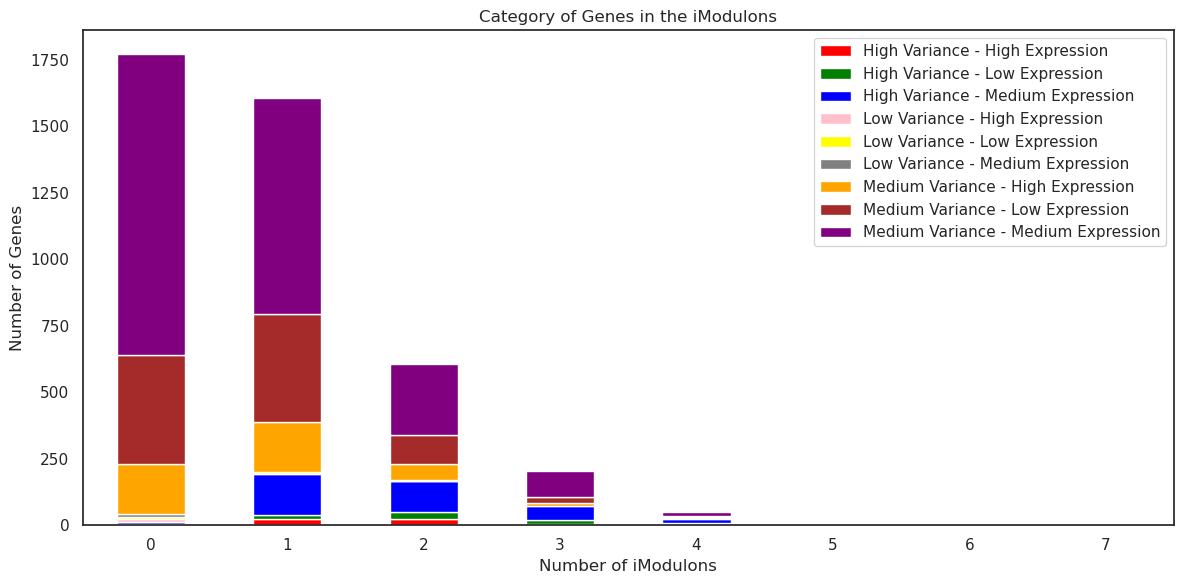

Low Variance  Medium Variance  High Variance
num_iM                                              
0           1.693002        97.573363       0.733634
1           0.622665        87.484433      11.892902
2           0.826446        71.735537      27.438017
3           0.000000        64.705882      35.294118
4           1.960784        49.019608      49.019608
5           0.000000        45.454545      54.545455
6           0.000000        16.666667      83.333333
7           0.000000        50.000000      50.000000

In [411]:
plot_categorized_histogram(P1K_merged, 'num_iM', 'Variance_Category', 'Expression_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

In [412]:
# Try different cutoffs - low - median boundry

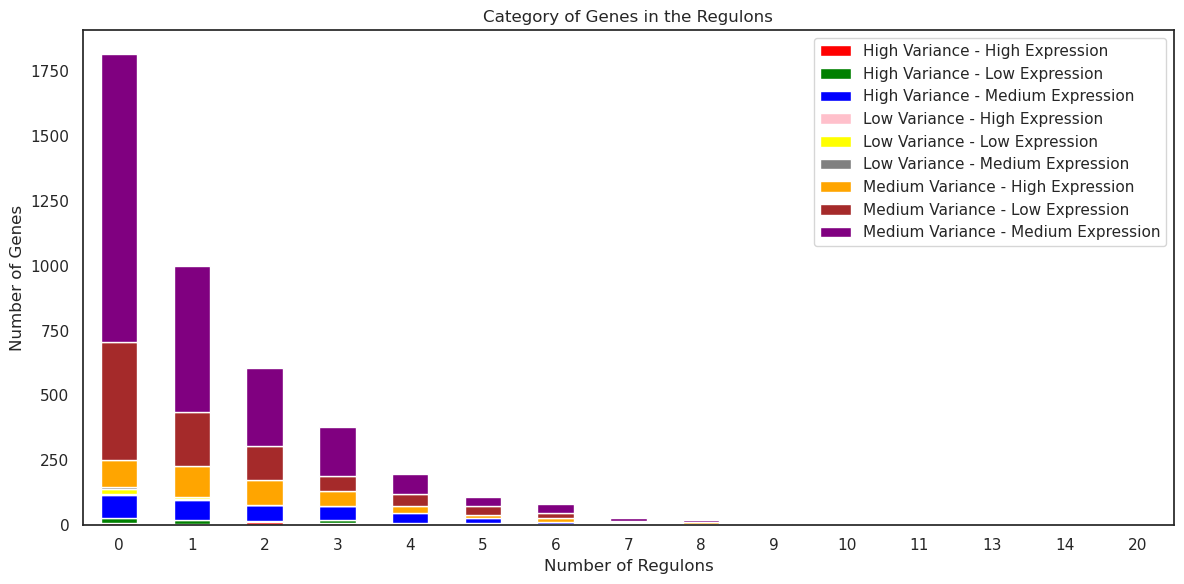

Low Variance  Medium Variance  High Variance
num_regulators                                              
0                   1.596916        91.960352       6.442731
1                   1.402806        88.977956       9.619238
2                   0.331126        86.920530      12.748344
3                   0.263852        80.474934      19.261214
4                   0.000000        75.879397      24.120603
5                   0.000000        74.311927      25.688073
6                   0.000000        85.000000      15.000000
7                   0.000000        71.428571      28.571429
8                   0.000000        71.428571      28.571429
9                   0.000000        42.857143      57.142857
10                  0.000000        66.666667      33.333333
11                  0.000000         0.000000     100.000000
13                  0.000000        50.000000      50.000000
14                  0.000000        33.333333      66.666667
20                  0.000000         0.000000     100.000000

In [413]:
plot_categorized_histogram(P1K_merged, 'num_regulators', 'Variance_Category', 'Expression_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

In [414]:
P1K_merged['Combined_Category'].value_counts()

Medium Variance - Medium Expression    2327
Medium Variance - Low Expression        955
Medium Variance - High Expression       450
High Variance - Medium Expression       363
High Variance - Low Expression           60
High Variance - High Expression          56
Low Variance - Low Expression            23
Low Variance - Medium Expression         12
Low Variance - High Expression           11
Name: Combined_Category, dtype: int64

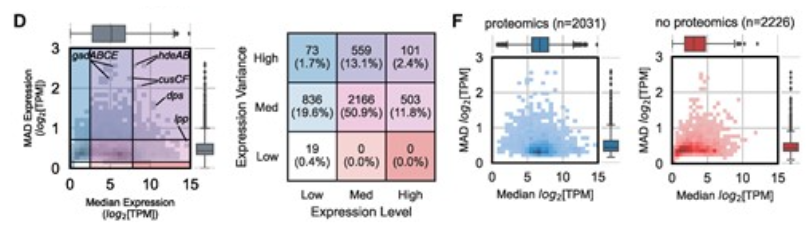

In [415]:
def plot_categorized_histogram_single_category(df, num_iM_col, var_cat_col, title, xlabel, ylabel):
    # Convert the categorical column to string
    df[var_cat_col] = df[var_cat_col].astype(str)
    
    # Define a color palette for distinct categories
    unique_categories = df[var_cat_col].unique()
    colors = plt.cm.get_cmap('viridis', len(unique_categories))

    # Count the occurrences of each category for each num_iM
    category_counts = df.groupby([num_iM_col, var_cat_col]).size().unstack(fill_value=0)

    # Plot the histogram with the specified figure size
    ax = category_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=[colors(i) for i in range(len(unique_categories))])

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Show the legend
    ax.legend(title=var_cat_col, loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

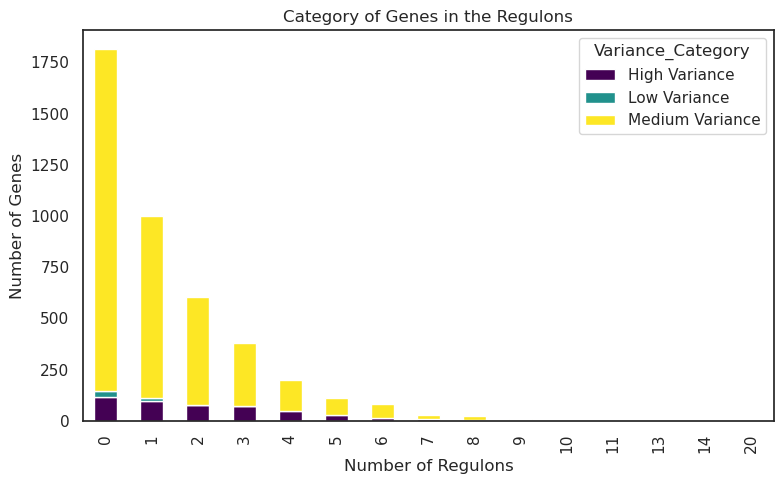

In [416]:
plot_categorized_histogram_single_category(P1K_merged, 'num_regulators', 'Variance_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

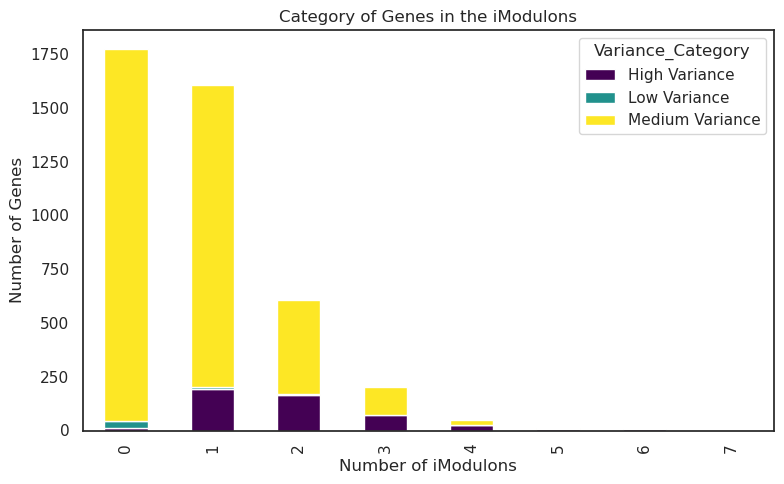

In [417]:
plot_categorized_histogram_single_category(P1K_merged, 'num_iM', 'Variance_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

In [63]:
# show fraction

#### Directly by elbow method

In [467]:
from kneed import KneeLocator

mad_values = P1K_merged['MAD'].values

# Sort the MAD values
sorted_mad_values = sorted(mad_values)

# Find the elbow point
kneedle = KneeLocator(range(len(sorted_mad_values)), sorted_mad_values, curve='convex', direction='increasing')
elbow_point = kneedle.elbow

# Elbow value in terms of MAD
elbow_value = sorted_mad_values[elbow_point]

elbow_value = elbow_value - 0.3

# Define thresholds
high_variance_threshold = elbow_value
low_variance_threshold = elbow_value / 3

# Classify the genes
P1K_merged['Variance_Category'] = pd.cut(
    P1K_merged['MAD'],
    bins=[-np.inf, low_variance_threshold, high_variance_threshold, np.inf],
    labels=['Low Variance', 'Medium Variance', 'High Variance']
)

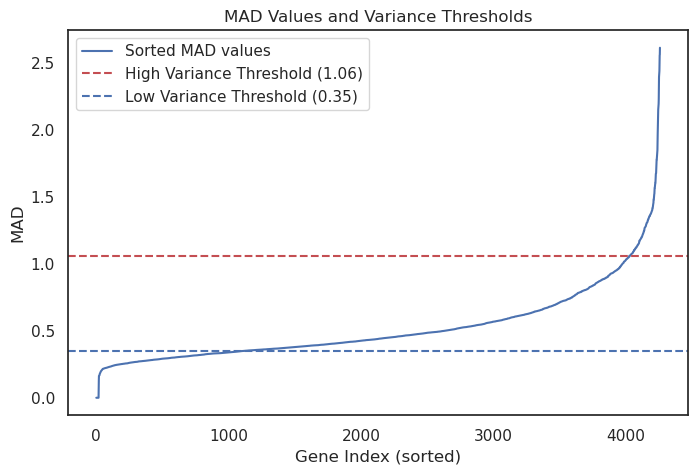

In [468]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_mad_values, label='Sorted MAD values')

# Add high variance threshold
plt.axhline(y=high_variance_threshold, color='r', linestyle='--', label=f'High Variance Threshold ({high_variance_threshold:.2f})')

# Add low variance threshold
plt.axhline(y=low_variance_threshold, color='b', linestyle='--', label=f'Low Variance Threshold ({low_variance_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('MAD')
plt.title('MAD Values and Variance Thresholds')
plt.legend()

# Show the plot
plt.show()

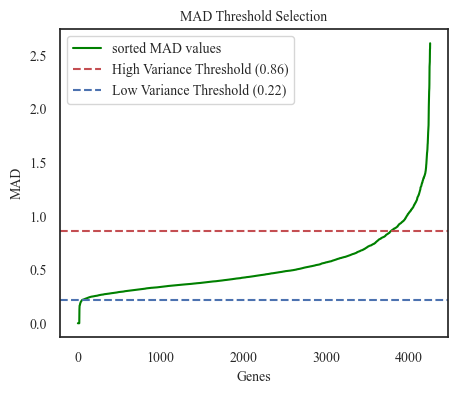

In [551]:
# Create the plot
plt.figure(figsize=(5, 4))
plt.plot(sorted_mad_values, label='sorted MAD values', color='green')

# Add high variance threshold
plt.axhline(y=high_variance_threshold, color='r', linestyle='--', label=f'High Variance Threshold ({high_variance_threshold:.2f})')

# Add low variance threshold
plt.axhline(y=low_variance_threshold, color='b', linestyle='--', label=f'Low Variance Threshold ({low_variance_threshold:.2f})')

# Add labels and title with custom font
plt.xlabel('Genes', fontproperties=font_prop)
plt.ylabel('MAD', fontproperties=font_prop)
plt.title('MAD Threshold Selection', fontproperties=font_prop)

# Set custom font for ticks
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

# Add legend with custom font
plt.legend(prop=font_prop)

# Save the plot as SVG
output_path = "MAD_threshold_selection.svg"
plt.savefig(output_path, format='svg')
plt.show()

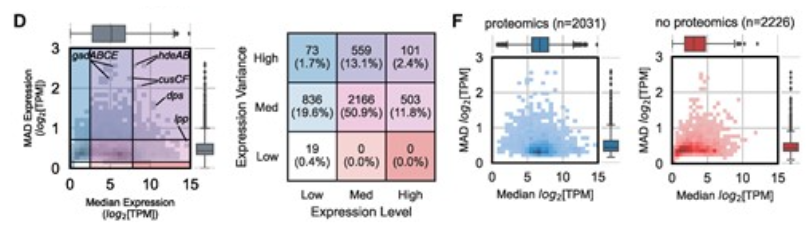

In [470]:
# Extract the log_TPM_median column
log_tpm_median_values = P1K_merged['log_TPM_median'].values

# Sort the log_TPM_median values
sorted_log_tpm_median_values = sorted(log_tpm_median_values)

# Find the elbow point
kneedle_tpm = KneeLocator(range(len(sorted_log_tpm_median_values)), sorted_log_tpm_median_values, curve='convex', direction='increasing')
elbow_point_tpm = kneedle_tpm.elbow

# Elbow value in terms of log_TPM_median
elbow_value_tpm = sorted_log_tpm_median_values[elbow_point_tpm]

elbow_value_tpm = elbow_value_tpm - 1.2

# Define thresholds
high_expression_threshold = elbow_value_tpm
low_expression_threshold = elbow_value_tpm / 2 # This is arbitrary, adjust as needed

# Classify the genes
P1K_merged['Expression_Category'] = pd.cut(
    P1K_merged['log_TPM_median'],
    bins=[-np.inf, low_expression_threshold, high_expression_threshold, np.inf],
    labels=['Low Expression', 'Medium Expression', 'High Expression']
)

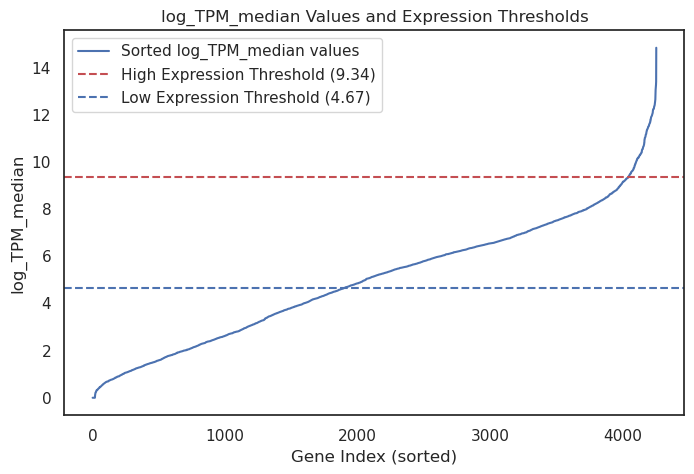

In [471]:
plt.figure(figsize=(8, 5))
plt.plot(sorted_log_tpm_median_values, label='Sorted log_TPM_median values')

# Add high expression threshold
plt.axhline(y=high_expression_threshold, color='r', linestyle='--', label=f'High Expression Threshold ({high_expression_threshold:.2f})')

# Add low expression threshold
plt.axhline(y=low_expression_threshold, color='b', linestyle='--', label=f'Low Expression Threshold ({low_expression_threshold:.2f})')

# Add labels and title
plt.xlabel('Gene Index (sorted)')
plt.ylabel('log_TPM_median')
plt.title('log_TPM_median Values and Expression Thresholds')
plt.legend()

# Show the plot
plt.show()

In [514]:
P1K_merged

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thrA                  0.899430                  0.686194        thrA KO   
thrB                  0.808533                  0.254512        thrA KO   
thrC                  0.824916                  0.246587        thrA KO   
yaaX                  0.689923                  0.171007    Leu/Val/Ile   
yaaA                  0.638300                  0.428612           OxyR   
...                        ...                       ...            ...   
yneP                  0.748917                  0.629455           yneP   
ynfT                  0.467147                  0.424437     Cold Shock   
yoaL                  0.333663                  0.102746           CpxR   
yqhI                  0.894360                  0.738529           yqhI   
yqiD                  0.896335                  0.554369          Fnr-2   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
thrA                  0.076638         Cysteine-1                  0.075628   
thrB                  0.227884        Leu/Val/Ile                  0.103394   
thrC                  0.234486        Leu/Val/Ile                  0.155906   
yaaX                  0.169602  Nucleotide Stress                  0.095365   
yaaA                  0.171808         Cold Shock                  0.129606   
...                        ...                ...                       ...   
yneP                  0.075002              GadXW                  0.047460   
ynfT                  0.045140                NRZ                  0.033476   
yoaL                  0.066571          Cellulose                  0.044315   
yqhI                  0.091457               UC-8                  0.084815   
yqiD                  0.396718              Fnr-3                  0.087869   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrA     Thiamine-1               3       3  0.702916        9.605329   
thrB        Leucine               1       2  0.698539        9.232803   
thrC      Dipeptide               1       1  0.611282        9.274271   
yaaX      Glycolate               0       3  0.737317        6.283661   
yaaA           UC-8               0       1  0.306569        6.346626   
...             ...             ...     ...       ...             ...   
yneP     Resistance               0       1  1.062231        1.132974   
ynfT            LPS               0       2  1.778052        2.460854   
yoaL          ppGpp               0       2  0.540346        5.048395   
yqhI     Resistance               0       2  1.185744        1.185744   
yqiD           ArcA               0       4  1.060502        5.068548   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrA      11.771901                4.369602   Medium Variance   
thrB       6.968977                3.899146   Medium Variance   
thrC       6.987691                3.672202   Medium Variance   
yaaX      11.817918                4.398450   Medium Variance   
yaaA       6.392433                1.916179   Medium Variance   
...             ...                     ...               ...   
yneP       4.458041                2.867823     High Variance   
ynfT       7.650393                6.188452     High Variance   
yoaL       5.552991                2.832758   Medium Variance   
yqhI       7.305199                4.979694     High Variance   
yqiD      11.535971                6.504470     High Variance   

     Expression_Category                    Combined_Category  
thrA     High Expression    Medium Variance - High Expression  
thrB     High Expression  Medium Variance - Medium Expression  
thrC     High Expression  Medium Variance - Medium Expression  
yaaX   Medium Expression  Medium Variance - Medium Expression  
yaaA   Medium Expression     Low Variance - Medium Expression  
...                  ...                                  ...  
yneP      Low Expression       High Variance - Low

In [515]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_categorized_histogram(df, num_iM_col, var_cat_col, exp_cat_col, title, xlabel, ylabel):
    # Convert categorical columns to strings and create a new combined category
    df['Combined_Category'] = df[var_cat_col].astype(str) + ' - ' + df[exp_cat_col].astype(str)
    
    # Define a color palette with 9 distinct colors
    colors = {
        'High Variance - High Expression': 'red',
        'High Variance - Medium Expression': 'blue',
        'High Variance - Low Expression': 'green',
        'Medium Variance - High Expression': 'orange',
        'Medium Variance - Medium Expression': 'purple',
        'Medium Variance - Low Expression': 'brown',
        'Low Variance - High Expression': 'pink',
        'Low Variance - Medium Expression': 'gray',
        'Low Variance - Low Expression': 'yellow'
    }

    # Count the occurrences of each combined category for each num_iM
    category_counts = df.groupby([num_iM_col, 'Combined_Category']).size().unstack(fill_value=0)

    # Plot the histogram
    category_counts.plot(kind='bar', stacked=True, color=[colors[cat] for cat in category_counts.columns], figsize=(12, 6))

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)

    # Show the legend
    plt.legend(title='', loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages for Low, Medium, and High Variance categories
    variance_categories = ['Low Variance', 'Medium Variance', 'High Variance']
    percentage_df = pd.DataFrame(index=category_counts.index, columns=variance_categories, dtype=float)
    
    for variance in variance_categories:
        # Sum the sub-categories for each variance level
        variance_cols = [col for col in category_counts.columns if col.startswith(variance)]
        variance_sum = category_counts[variance_cols].sum(axis=1)
        # Calculate percentage
        total_counts = category_counts.sum(axis=1)
        percentage_df[variance] = (variance_sum / total_counts) * 100

    return percentage_df

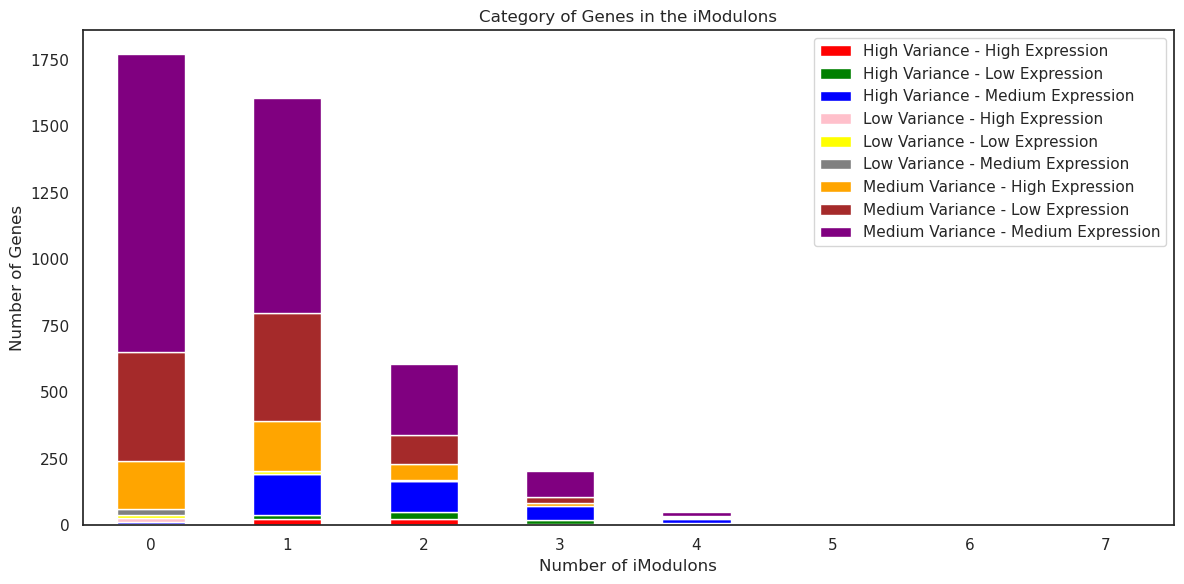

Low Variance  Medium Variance  High Variance
num_iM                                              
0           2.652370        96.613995       0.733634
1           0.871731        87.235367      11.892902
2           0.826446        71.735537      27.438017
3           0.000000        64.705882      35.294118
4           1.960784        49.019608      49.019608
5           0.000000        45.454545      54.545455
6           0.000000        16.666667      83.333333
7           0.000000        50.000000      50.000000

In [516]:
plot_categorized_histogram(P1K_merged, 'num_iM', 'Variance_Category', 'Expression_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

In [517]:
# Try different cutoffs - low - median boundry

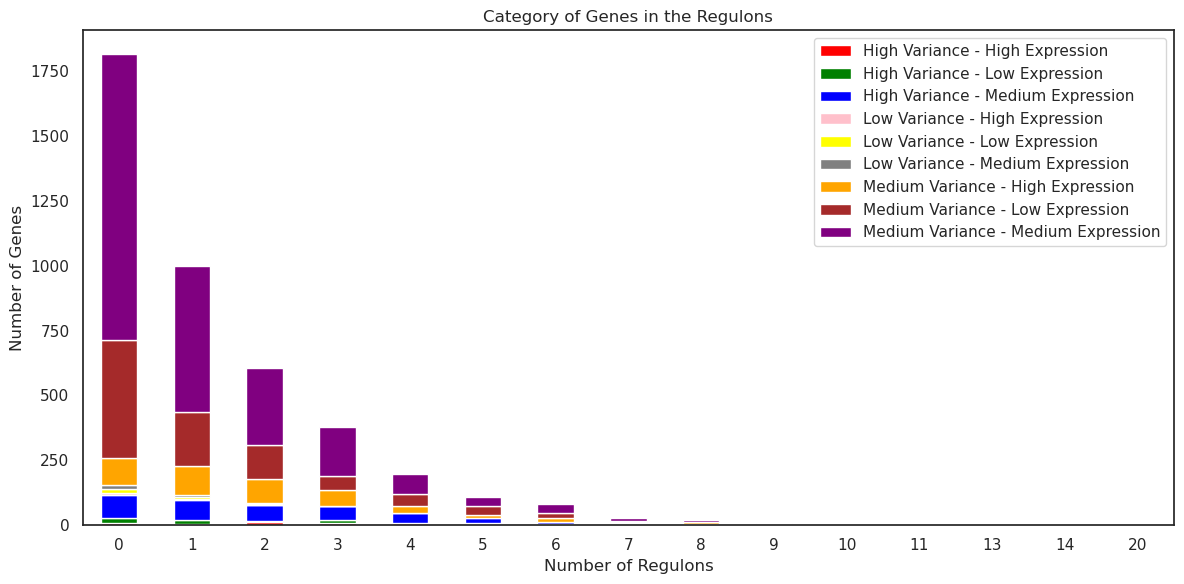

Low Variance  Medium Variance  High Variance
num_regulators                                              
0                   2.037445        91.519824       6.442731
1                   1.903808        88.476954       9.619238
2                   1.158940        86.092715      12.748344
3                   0.791557        79.947230      19.261214
4                   0.502513        75.376884      24.120603
5                   0.000000        74.311927      25.688073
6                   0.000000        85.000000      15.000000
7                   0.000000        71.428571      28.571429
8                   0.000000        71.428571      28.571429
9                   0.000000        42.857143      57.142857
10                  0.000000        66.666667      33.333333
11                  0.000000         0.000000     100.000000
13                  0.000000        50.000000      50.000000
14                  0.000000        33.333333      66.666667
20                  0.000000         0.000000     100.000000

In [518]:
plot_categorized_histogram(P1K_merged, 'num_regulators', 'Variance_Category', 'Expression_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

In [519]:
P1K_merged['Combined_Category'].value_counts()

Medium Variance - Medium Expression    2316
Medium Variance - Low Expression        951
Medium Variance - High Expression       444
High Variance - Medium Expression       363
High Variance - Low Expression           60
High Variance - High Expression          56
Low Variance - Low Expression            27
Low Variance - Medium Expression         23
Low Variance - High Expression           17
Name: Combined_Category, dtype: int64

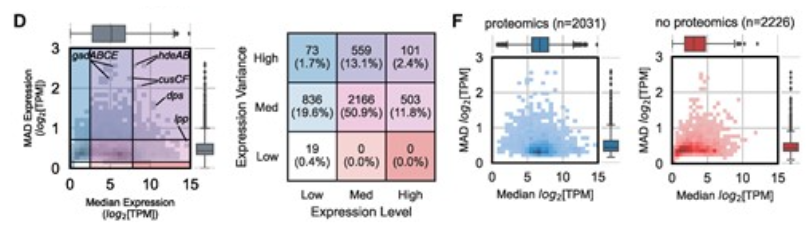

In [520]:
def plot_categorized_histogram_single_category(df, num_iM_col, var_cat_col, title, xlabel, ylabel):
    # Convert the categorical column to string
    df[var_cat_col] = df[var_cat_col].astype(str)
    
    # Define a color palette for distinct categories
    unique_categories = df[var_cat_col].unique()
    colors = plt.cm.get_cmap('viridis', len(unique_categories))

    # Count the occurrences of each category for each num_iM
    category_counts = df.groupby([num_iM_col, var_cat_col]).size().unstack(fill_value=0)

    # Plot the histogram with the specified figure size
    ax = category_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=[colors(i) for i in range(len(unique_categories))])

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Show the legend
    ax.legend(title=var_cat_col, loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

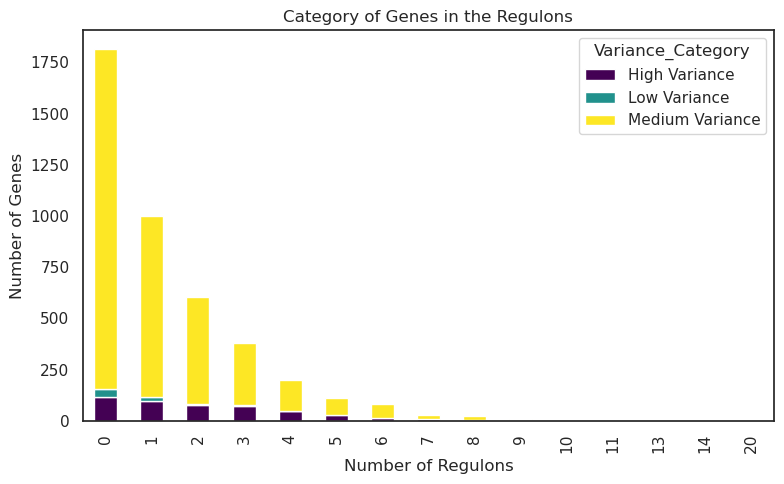

In [521]:
plot_categorized_histogram_single_category(P1K_merged, 'num_regulators', 'Variance_Category', 'Category of Genes in the Regulons', 'Number of Regulons', 'Number of Genes')

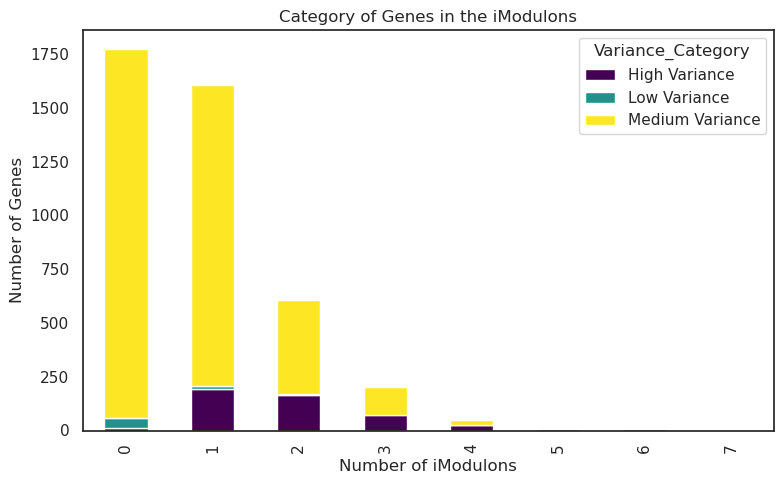

In [522]:
plot_categorized_histogram_single_category(P1K_merged, 'num_iM', 'Variance_Category', 'Category of Genes in the iModulons', 'Number of iModulons', 'Number of Genes')

## How many regulators (TFs/Sigma factors) have iModulons associated with them?

In [523]:
# Separate unique regulator-iM associations vs multi-regulator to a single iM
# no, unique, multi-

In [524]:
P1K_iM_table = pd.read_csv('/home/gaoyuan/PhD/ICA_Extension_Mechanism/p1k_data_files/iM_table.csv', index_col=0)

In [525]:
P1K_iM_table['regulator_readable'] = P1K_iM_table['regulator_readable'].astype('str')

In [526]:
P1K_iM_table_with_regulator = P1K_iM_table[P1K_iM_table['regulator_readable'] != 'nan']

In [527]:
P1K_iM_table_with_regulator

name                                regulator_readable  \
k                                                                       
0      Sugar Diacid                                              CdaR   
1       Translation                                              DksA   
3              OxyR                                              OxyR   
4           FlhDC-2                                             FlhDC   
5    Osmoprotectant                   RpoS and ppGpp and IHF and H-NS   
..              ...                                               ...   
185            gcvB                                              gcvB   
186       Glutarate  RpoS and H-NS and Crp and Lrp and GlaR and ppGpp   
191   Tryptophanase             Crp and TorR and Nac and L-tryptophan   
195     Phage Shock                             RpoN and IHF and PspF   
196      Glyoxylate   Crp and ArcA and ppGpp and Cra and IclR and IHF   

                                              function  \
k                                                        
0    Transport and catabolism of carbohydrate diaci...   
1                                  Ribosome biogenesis   
3       Oxidative stress response, especially peroxide   
4                    Flagellum biosynthesis and export   
5          Transport of osmoprotectant glycine betaine   
..                                                 ...   
185                               Amino acid transport   
186   Glutarate/aminobutyrate transport and catabolism   
191  Tryptophan import and catabolism via tryptopha...   
195  Phage shock response; response to filamentous ...   
196           Glyxoylate cycle; alternate to TCA cycle   

                     category  n_genes   exp_var  precision    recall  \
k                                                                       
0           Carbon Metabolism       14  0.002413   0.642857  1.000000   
1                 Translation       53  0.007469   0.830189  0.392857   
3                Redox Stress       38  0.001747   0.421053  0.551724   
4    Extracellular Structures       43  0.030021   0.860465  0.456790   
5             Envelope Stress        4  0.004189   0.750000  0.375000   
..                        ...      ...       ...        ...       ...   
185     Amino Acid Metabolism       76  0.005554   0.184211  0.245614   
186         Carbon Metabolism        5  0.003170   1.000000  1.000000   
191     Amino Acid Metabolism        2  0.003248   1.000000  1.000000   
195               Phage Shock        6  0.003631   0.833333  0.833333   
196         Energy Metabolism        3  0.002085   1.000000  1.000000   

     category_num  
k                  
0               0  
1               1  
3               3  
4               4  
5               5  
..            ...  
185           185  
186           186  
191           191  
195           195  
196           196  

[117 rows x 9 columns]

In [528]:
## Single Regulator - single iM

In [529]:
single_regulator_iM = P1K_iM_table_with_regulator[P1K_iM_table_with_regulator['regulator_readable'].str.contains(' ') == False]

In [530]:
single_regulator_iM.shape

(56, 9)

In [531]:
single_regulator_iM

name regulator_readable  \
k                                        
0      Sugar Diacid               CdaR   
1       Translation               DksA   
3              OxyR               OxyR   
4           FlhDC-2              FlhDC   
6         Glutamine               NtrC   
13             RpoH               RpoH   
18       Methionine               MetJ   
22             SoxS               SoxS   
24             YjfJ               YjfJ   
25              Lrp                Lrp   
32             CpxR               CpxR   
38             EvgA               EvgA   
42           Biotin               BirA   
49             BasR               BasR   
50   Sulfoquinovose               CsqR   
51             RpoS               RpoS   
54            Fur-1                Fur   
58            Fur-2                Fur   
59        Magnesium               PhoP   
62            Fnr-1                Fnr   
64           Zinc-2               ZraR   
65              NRZ               OmpR   
67             RpoE               RpoE   
69      Phosphate-1               PhoB   
74             ArcA               ArcA   
76        Potassium               KdpE   
85       DNA Damage               LexA   
87             YieP               YieP   
88         Nitrogen                Nac   
92            Crp-1                Crp   
111            YgeV               YgeV   
113           FDH-O               sdhX   
115            YgbI               YgbI   
116     Lysine/T2SS               ArgP   
117           Fnr-3                Fnr   
128            FliA               FliA   
129      Pyruvate-1               BtsR   
134           Crp-2                Crp   
135      Cysteine-1               CysB   
136      Pyruvate-2               PyrR   
137     Phosphate-2               PhoB   
139         Capsule              RcsAB   
143         FlhDC-1              FlhDC   
145           ppGpp              ppGpp   
149        Arginine               ArgR   
150   Nickel/Cobalt               RcnR   
155            YmfT               YmfT   
156           Fnr-2                Fnr   
158      Cysteine-2               CysB   
160            YcjW               YcjW   
169            NrdR               NrdR   
174             Cra                Cra   
179         Maltose               MalT   
182      Fatty Acid               FadR   
183            DhaR               DhaR   
185            gcvB               gcvB   

                                              function  \
k                                                        
0    Transport and catabolism of carbohydrate diaci...   
1                                  Ribosome biogenesis   
3       Oxidative stress response, especially peroxide   
4                    Flagellum biosynthesis and export   
6                    Glutamine transport and synthesis   
13   Global heat shock response during log-phase; r...   
18               Methionine transport and biosynthesis   
22   Superoxide/nitric oxide sensing and removal, p...   
24                    Putative heat responsive regulon   
25   Global regulation of amino acid biosynthesis/c...   
32   Inner membrane damage sensing and repair via p...   
38   Glutamate-dependent acid response, drug resist...   
42                                 Biotin biosynthesis   
49   Lipid A modification and polymixin resistance ...   
50             Sulfoquinovose transport and catabolism   
51          Master regulator of global stress response   
54   Iron sensing and uptake, enterobactin biosynth...   
58   Iron sensing and uptake, enterobactin biosynth...   
59   Magnesium sensing and transport; magnesium-lim...   
62   Transition from aerobic to anaerobic growth; a...   
64                Tolerance to high zinc concentration   
65   Nitrate reduction under microaerobic condition...   
67   Heat shock response; response to high temperat...   
69   Inorganic phosphate sensing, transport, and pr...   
74   Anaerobiosis; repression of aerobic growth gen...   
76          

In [532]:
single_regulator_iM['regulator_readable'].value_counts()

Fnr      3
Crp      2
FlhDC    2
PhoB     2
Fur      2
CysB     2
PyrR     1
YgeV     1
sdhX     1
YgbI     1
ArgP     1
FliA     1
BtsR     1
CdaR     1
Nac      1
ppGpp    1
ArgR     1
RcnR     1
YmfT     1
YcjW     1
NrdR     1
Cra      1
MalT     1
FadR     1
DhaR     1
RcsAB    1
KdpE     1
YieP     1
LexA     1
OxyR     1
NtrC     1
RpoH     1
MetJ     1
SoxS     1
YjfJ     1
Lrp      1
CpxR     1
EvgA     1
BirA     1
BasR     1
CsqR     1
RpoS     1
PhoP     1
ZraR     1
OmpR     1
RpoE     1
ArcA     1
DksA     1
gcvB     1
Name: regulator_readable, dtype: int64

In [533]:
len(single_regulator_iM['regulator_readable'].unique())

49

In [534]:
def count_regulators(dataframe, column_name):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = dataframe.copy()
    
    # Ensure there are no leading or trailing spaces in the column values
    df_copy.loc[:, column_name] = df_copy[column_name].str.strip()
    
    # Split the column values by ' and ' or ' or ' with spaces before and after and stack them into a single series
    regulators = df_copy[column_name].str.split(r'\s+and\s+|\s+or\s+', expand=True).stack()
    
    # Remove any potential empty strings
    regulators = regulators[regulators != '']
    
    # Count the occurrences of each unique regulator
    regulator_counts = regulators.value_counts().reset_index()
    
    # Rename the columns
    regulator_counts.columns = ['regulator', 'counts']
    
    return regulator_counts


In [535]:
regulator_iM_counts = count_regulators(P1K_iM_table_with_regulator, 'regulator_readable')

In [536]:
# Unique iM regulator
# 81
regulator_iM_counts[regulator_iM_counts ['counts'] == 1]

regulator  counts
42       YgeV       1
43       ArgP       1
44       YgbI       1
45       FadR       1
46       NagC       1
..        ...     ...
118      BasR       1
119      MarA       1
120      BluR       1
121      BirA       1
122      IclR       1

[81 rows x 2 columns]

In [537]:
# Nulti iM regulator
# 41
regulator_iM_counts[regulator_iM_counts ['counts'] != 1]

regulator  counts
0        Crp      24
1        IHF      16
2        Fnr      13
3       RpoS      11
4      ppGpp      10
5       RpoN       8
6       NarL       7
7       ArcA       6
8        Lrp       5
9       NtrC       4
10      H-NS       4
11      NarP       4
12      NsrR       4
13     FlhDC       4
14       Fur       4
15      CpxR       3
16       Cra       3
17      ModE       3
18       Fis       3
19      CysB       3
20      PurR       3
21      BtsR       3
22       Nac       3
23      IscR       3
24      DksA       2
25      ryhB       2
26  Leu-tRNA       2
27      gcvB       2
28      CsgD       2
29      FliA       2
30      FliZ       2
31      TdcA       2
32      TdcR       2
33      TrpR       2
34      RpoE       2
35      PhoB       2
36  Trp-tRNA       2
37      OxyR       2
38      GadX       2
39      FucR       2
40      CueR       2
41      PdhR       2

In [538]:
# only in regulonDB, not in any iM

RegulonDB_TRN.columns

Index(['FecI', 'FliA', 'RpoD', 'RpoE', 'RpoH', 'RpoN', 'RpoS', 'AcrR', 'Ada',
       'AdiY',
       ...
       'YefM', 'YefMB', 'YgiV', 'YhaJ', 'YiaU', 'YjjQ', 'YqhC', 'ZntR', 'ZraR',
       'Zur'],
      dtype='object', length=259)

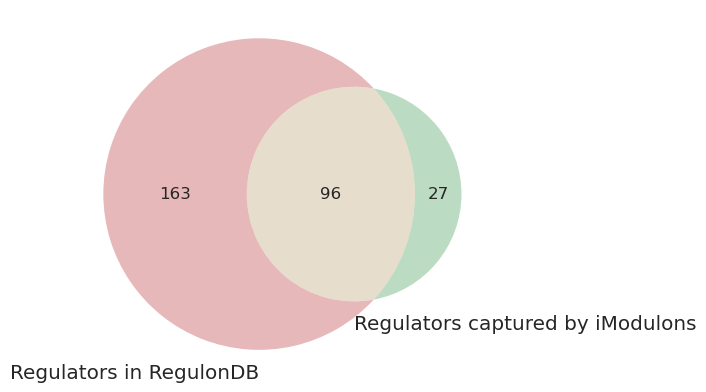

In [539]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

venn2([set(RegulonDB_TRN.columns), set(regulator_iM_counts['regulator'])], set_labels=('Regulators in RegulonDB', 'Regulators captured by iModulons'))

# Show the plot
plt.show()

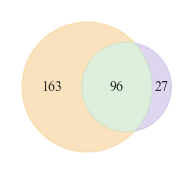

In [540]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.font_manager as fm

# Define your two lists
list1 = set(RegulonDB_TRN.columns)
list2 = set(regulator_iM_counts['regulator'])

# Convert lists to sets
set1 = set(list1)
set2 = set(list2)

# Define colors (lighter than the given colors)
color1 = '#f8d7a4'  # Lighter than F2B341
color2 = '#d1c4e9'  # Lighter than 9367AC
color3 = '#d0e8cf'  # Lighter than 94C47D

# Load the font properties
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path, size=10)  # Adjust the size as needed

plt.figure(figsize=(3,2))

# Create the Venn diagram
venn = venn2([set1, set2], ('', ''))

# Customize the colors
venn.get_patch_by_id('10').set_color(color1)
venn.get_patch_by_id('01').set_color(color2)
venn.get_patch_by_id('11').set_color(color3)

# Customize the transparency
venn.get_patch_by_id('10').set_alpha(0.7)
venn.get_patch_by_id('01').set_alpha(0.7)
venn.get_patch_by_id('11').set_alpha(0.7)

# Set the font properties for all texts in the plot
for text in venn.set_labels:
    text.set_fontproperties(font_prop)
for text in venn.subset_labels:
    text.set_fontproperties(font_prop)

# Save the plot as an SVG file
plt.savefig('Regulator_capture_by_iM.svg', format='svg')

# Display the plot (optional)
plt.show()

## For genes associated to iMs, how much explained variance is captured by the top iM?

In [541]:
def plot_stacked_histogram(df, variance_col, num_iM_col):
    # Copy the DataFrame
    df_copy = df.copy()

    # Separate the data
    in_ims = df_copy[df_copy[num_iM_col] != 0][variance_col]
    not_in_ims = df_copy[df_copy[num_iM_col] == 0][variance_col]

    # Plot histogram
    plt.hist([not_in_ims, in_ims], bins=10, stacked=True, color=['lightblue', 'salmon'], label=['Not in any iMs', 'in iMs'])
    plt.xlabel('Top Explained Variance')
    plt.ylabel('Frequency')
    plt.title('Explained Variance from the top iM')
    plt.legend()
    plt.show()

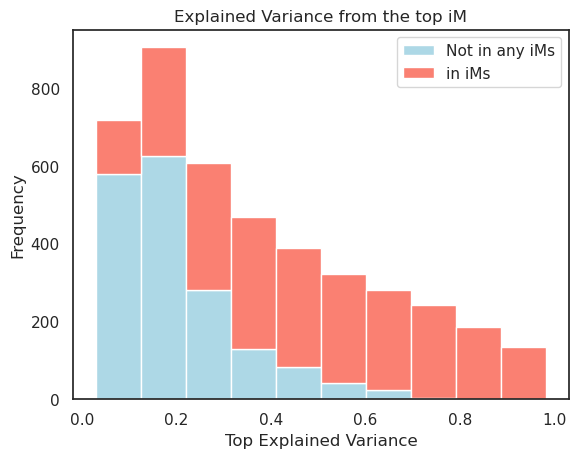

In [542]:
plot_stacked_histogram(P1K_merged, 'Top_1_Explained_Variance', 'num_iM')

In [543]:
# Cases for top left - low top exp var - but in iMs

In [544]:
P1K_merged[(P1K_merged['Top_1_Explained_Variance'] < 0.1) & (P1K_merged['num_iM'] >0)]

Total_Explained_Variance  Top_1_Explained_Variance   Top_1_iModulon  \
mog                   0.506701                  0.085929             UC-5   
mbiA                  0.000000                  0.090604             UC-5   
fixX                  0.016148                  0.070135             UC-2   
cra                   0.638262                  0.079509       Suf System   
dgt                   0.275157                  0.083282            Fnr-1   
...                        ...                       ...              ...   
hokA                  0.035485                  0.073324         SSW SNPs   
ymjB                  0.257451                  0.041217  Nitrate/Nitrite   
yniD                  0.000000                  0.073831       Resistance   
yshB                  0.577362                  0.094962    IS Elements-2   
yncO                  0.127377                  0.068596              LPS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
mog                   0.075019      Cellulose                  0.061941   
mbiA                  0.079584     DNA Damage                  0.073846   
fixX                  0.036621    Efflux Pump                  0.033455   
cra                   0.074772           UC-3                  0.074057   
dgt                   0.075223           SoxS                  0.049999   
...                        ...            ...                       ...   
hokA                  0.051889     Resistance                  0.049770   
ymjB                  0.037120           ldrC                  0.029970   
yniD                  0.058614           yneP                  0.047505   
yshB                  0.058995     Nucleoside                  0.044643   
yncO                  0.058011           yneP                  0.057207   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
mog            RpoS               0       2  0.337544        6.016844   
mbiA           UC-6               1       1  0.344182        0.594027   
fixX            LPS               2       1  0.451908        1.065222   
cra   Tryptophanase               0       2  0.269940        7.066895   
dgt             Lrp               0       2  0.274595        5.452256   
...             ...             ...     ...       ...             ...   
hokA       Rhamnose               0       1  0.693764        0.693764   
ymjB          GadXW               1       4  0.000000        0.000000   
yniD    Translation               0       3  0.729530        3.729484   
yshB            Lrp               0       1  0.901976        8.070179   
yncO           gcvB               0       2  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
mog        5.017378                1.675366   Medium Variance   
mbiA       4.124902                1.752476   Medium Variance   
fixX       4.073628                2.145380   Medium Variance   
cra        9.276871                1.920830   Medium Variance   
dgt        4.962216                1.657203   Medium Variance   
...             ...                     ...               ...   
hokA       4.159089                2.177685   Medium Variance   
ymjB       5.185074                2.286722      Low Variance   
yniD       6.796104                3.788051   Medium Variance   
yshB       8.095803                3.613974     High Variance   
yncO       4.344567                2.211135      Low Variance   

     Expression_Category                    Combined_Category  
mog    Medium Expression  Medium Variance - Medium Expression  
mbiA      Low Expression     Medium Variance - Low Expression  
fixX      Low Expression     Medium Variance - Low Expression  
cra    Medium Expression  Medium Variance - Medium Expression  
dgt    Medium Expression  Medium Variance - Medium Expression  
...                  ...                                  ...  
hokA      Low Expression     Medium Variance - Low Expression  
ymjB      

In [545]:
def plot_stacked_histogram(df, variance_col, num_iM_col):
    # Copy the DataFrame
    df_copy = df.copy()

    # Separate the data
    in_ims = df_copy[df_copy[num_iM_col] != 0][variance_col]
    not_in_ims = df_copy[df_copy[num_iM_col] == 0][variance_col]

    # Plot histogram
    plt.hist([not_in_ims, in_ims], bins=10, stacked=True, color=['lightblue', 'salmon'], label=['Not in any regulon', 'in regulons'])
    plt.xlabel('Top Explained Variance')
    plt.ylabel('Frequency')
    plt.title('Explained Variance from the top iM')
    plt.legend()
    plt.show()

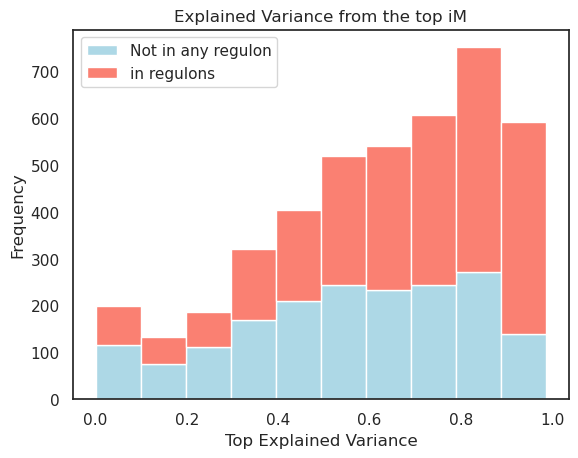

In [546]:
plot_stacked_histogram(P1K_merged, 'Total_Explained_Variance', 'num_regulators')

In [556]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_stacked_histogram_three_categories(df, variance_col, category_col):
    # Define the font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=10)  # Adjust the size as needed

    # Copy the DataFrame
    df_copy = df.copy()

    # Remove rows where variance_col is less than 0
    df_copy = df_copy[df_copy[variance_col] >= 0]

    # Define categories and colors
    categories = df_copy[category_col].unique()
    categories = ['Low Variance', 'Medium Variance', 'High Variance']
    colors = ['#9268AD', '#F57F20', '#2278B5']
    if len(categories) > 3:
        raise ValueError("There are more than three categories in the Variance_Category column.")

    # Separate the data
    separated_data = [df_copy[df_copy[category_col] == category][variance_col] for category in categories]

    # Modify labels to split into two lines
    labels = ['Low\nExpression\nMAD', 'Medium\nExpression\nMAD', 'High\nExpression\nMAD']

    # Create a figure with the specified size (3 inches by 5 inches)
    plt.figure(figsize=(4, 4))

    # Plot histogram with alpha transparency set to 0.5
    plt.hist(separated_data, bins=10, stacked=True, color=colors[:len(categories)], label=labels, alpha=0.5)

    # Set the labels with the custom font
    plt.xlabel('Total Explained Variance by iModulons', fontproperties=font_prop)
    plt.ylabel('Frequency', fontproperties=font_prop)

    # Customize the tick labels with the custom font
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Get handles and reverse their order
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], prop=font_prop)

    # Save the figure as an SVG file
    plt.savefig("variance_total_exp_var_histogram.svg", format='svg')

    # Show the plot
    plt.show()


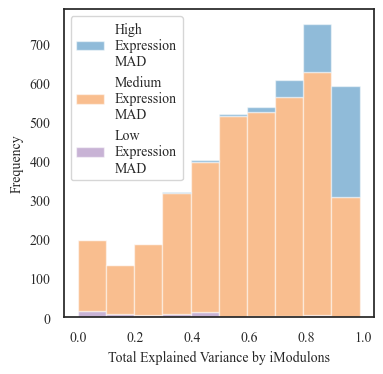

In [557]:
plot_stacked_histogram_three_categories(P1K_merged, 'Total_Explained_Variance', 'Variance_Category')

## How many genes are explained well by their top iM?

**All the genes with more than 80% exp var by top component are in iModulons**

In [103]:
(P1K_merged['Top_1_Explained_Variance'] > 0.8).sum()

309

In [104]:
(P1K_merged[P1K_merged['num_iM'] != 0]['Top_1_Explained_Variance'] > 0.8).sum()

309

In [105]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Top_1_Explained_Variance'] > 0.8).sum()

0

**93.5% of the genes with more than 50% exp var by top component are in iModulons**

In [106]:
(P1K_merged['Top_1_Explained_Variance'] > 0.5).sum()

1190

In [107]:
# in iM
(P1K_merged[P1K_merged['num_iM'] != 0]['Top_1_Explained_Variance'] > 0.5).sum()

1113

In [108]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Top_1_Explained_Variance'] > 0.5).sum()

77

**91.0% of the genes with more than 80% exp var in total are in iModulons**

In [109]:
(P1K_merged['Total_Explained_Variance'] > 0.8).sum()

1276

In [110]:
# in iM
(P1K_merged[P1K_merged['num_iM'] != 0]['Total_Explained_Variance'] > 0.8).sum()

1161

In [111]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Total_Explained_Variance'] > 0.8).sum()

115

In [112]:
# Venn diagram for category 2&3

**72.3% of the genes with more than 50% exp var in total are in iModulons**

In [113]:
(P1K_merged['Total_Explained_Variance'] > 0.5).sum()

2981

In [114]:
(P1K_merged[P1K_merged['num_iM'] != 0]['Total_Explained_Variance'] > 0.5).sum()

2156

In [115]:
(P1K_merged[P1K_merged['num_iM'] == 0]['Total_Explained_Variance'] > 0.5).sum()

825

## How many genes (even not in an iModulon) can be explained reasonably well by a single iM?

In [116]:
# An appropriate cutoff for what "explained well" means needs to be determined

In [117]:
# At least in one iM

(P1K_merged[P1K_merged['num_iM'] != 0]['Top_1_Explained_Variance'] > 0.5).sum()

1113

In [118]:
# Not in iMs

(P1K_merged[P1K_merged['num_iM'] == 0]['Top_1_Explained_Variance'] > 0.5).sum()

77

### four scatter plots - 0.2 0.4 0.6 0.8 exp var - genes close to these values

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    plt.figure(figsize=(15, 2))
    # Create scatter plot
    plt.scatter(x_values, y_values, label='Data points')

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='red', label='Line of best fit')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Display the plot with labels and legend
    plt.xlabel(gene_name)
    plt.ylabel(imodulon_name)
    plt.title(f'Scatter Plot of {gene_name} Expression and {imodulon_name} Activity\n$R^2$ = {r2:.2f}')
    plt.legend()
    plt.show()

#### 0.2 exp var for top iM

In [120]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.198) & (P1K_merged['Top_1_Explained_Variance'] <= 0.202)])

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
aceE                  0.496320                  0.198046     Pyruvate-1   
ygfZ                  0.567229                  0.200985           SoxS   
yohO                  0.730582                  0.201530     Cold Shock   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
aceE                  0.099905  Tryptophanase                  0.094199   
ygfZ                  0.112400     Cold Shock                  0.086215   
yohO                  0.167250           ArcA                  0.163389   

          Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
aceE  cyoB/ndh/nuoB KO-2               6       2  0.514809       10.141470   
ygfZ               ppGpp               0       1  0.370070        8.139202   
yohO        minicoli KOs               1       5  0.766030        4.710898   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
aceE       9.902395                2.565130   Medium Variance   
ygfZ       8.485120                2.326982      Low Variance   
yohO       7.734391                5.193217   Medium Variance   

     Expression_Category                    Combined_Category  
aceE   Medium Expression  Medium Variance - Medium Expression  
ygfZ   Medium Expression     Low Variance - Medium Expression  
yohO      Low Expression     Medium Variance - Low Expression

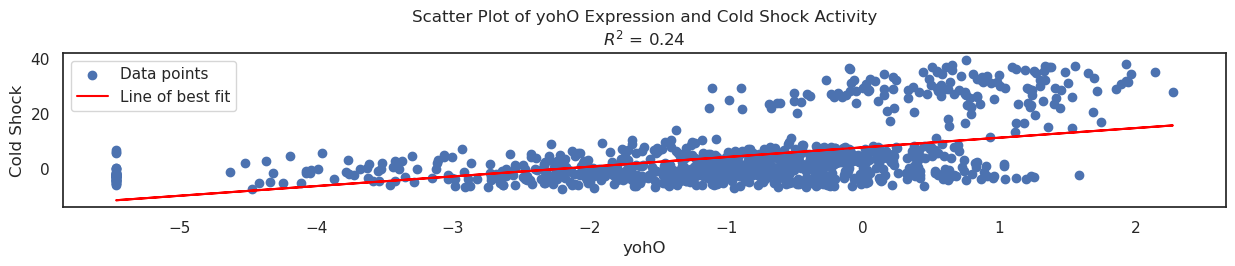

In [121]:
plot_scatter_with_fit(P1K_X, P1K_A, 'yohO', 'Cold Shock')

#### 0.4 exp var for top iM

In [122]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.399) & (P1K_merged['Top_1_Explained_Variance'] <= 0.401)])

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thiB                  0.923394                  0.399882     Thiamine-2   
tfaP                  0.426366                  0.400820        e14 Del   
ydhP                  0.728553                  0.399998       crp KO-1   
hcaR                  0.866541                  0.399631           ArcA   
agaV                  0.654332                  0.399785           UC-3   
bfd                   0.876044                  0.400080          Fur-2   
waaL                  0.614756                  0.400375            LPS   
dinD                  0.875722                  0.400693     DNA Damage   
yigG                  0.692606                  0.400823           gcvB   
aceA                  0.919733                  0.400599     Glyoxylate   
arcA                  0.792987                  0.400606   arcA/luxS KO   
ythA                  0.771236                  0.399871           ythA   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
thiB                  0.362027   minicoli KOs                  0.276734   
tfaP                  0.074898      Cellulose                  0.065709   
ydhP                  0.133989           UC-3                  0.087100   
hcaR                  0.366989           UC-3                  0.062755   
agaV                  0.120964        Acetate                  0.111584   
bfd                   0.159288   minicoli KOs                  0.134409   
waaL                  0.072282           gcvB                  0.054997   
dinD                  0.331136     Cold Shock                  0.169690   
yigG                  0.158401            LPS                  0.151844   
aceA                  0.219348      Glycolate                  0.103584   
arcA                  0.148407   cydB/appC KO                  0.145239   
ythA                  0.056927           ytiC                  0.030325   

         Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thiB         Thiamine-1               1       3  0.926312        6.463760   
tfaP           Membrane               0       1  0.567003        2.047423   
ydhP            Sulfate               0       2  0.525878        4.272419   
hcaR         Cold Shock               4       2  0.864447        5.363972   
agaV      Tryptophanase               3       1  0.464450        2.312216   
bfd                NrdR               2       1  1.046325        7.030968   
waaL               UC-7               3       1  0.836676        5.554878   
dinD               UC-3               1       3  0.577858        3.731381   
yigG  Nucleotide Stress               1       2  0.614868        1.269864   
aceA         Fatty Acid               4       1  1.124310       10.111705   
arcA                IS1               3       3  0.359781        9.667090   
ythA               ymdG               0       1  1.047653        1.047653   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
thiB       8.370243                4.566084   Medium Variance   
tfaP       5.560001                3.349763   Medium Variance   
ydhP       6.737068                2.929794   Medium Variance   
hcaR       7.747803                5.458019   Medium Variance   
agaV       6.311997                3.353274   Medium Variance   
bfd       10.571173                6.213533     High Variance   
waaL       8.466801                4.314322   Medium Variance   
dinD       7.471783                4.297600   Medium Variance   
yigG       4.839620                3.007742   Medium Variance   
aceA      10.175448                5.794129     High Variance   
arcA      12.783370                2.145755      Low Variance   
ythA       3.986192                2.849299     High Variance   

     Expression_Category                    Combined_Category  
thiB   Medium Expression  Medium Variance - Medium Expression  
tfaP      Low Expression     Medium Variance - Low Expression  
ydhP      Low 

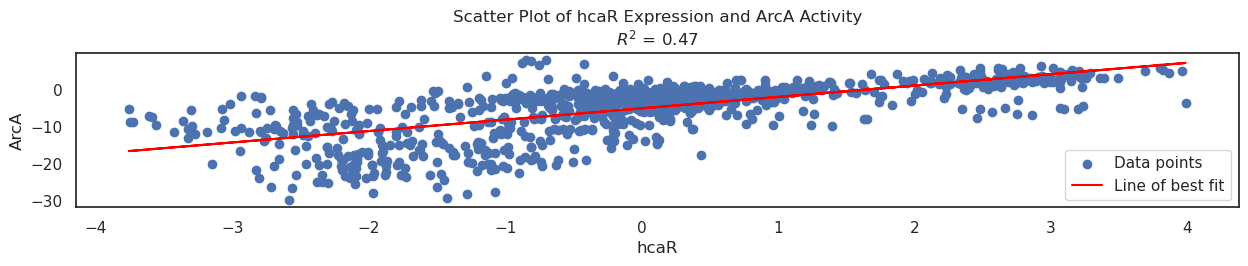

In [123]:
plot_scatter_with_fit(P1K_X, P1K_A, 'hcaR', 'ArcA')

#### 0.6 exp var for top iM

In [124]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.599) & (P1K_merged['Top_1_Explained_Variance'] <= 0.601)])

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
artP                  0.828126                  0.600421   minicoli KOs   
yncG                  0.905237                  0.599498           RpoS   
elaB                  0.933595                  0.600006           RpoS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
artP                  0.141570       Arginine                  0.090312   
yncG                  0.371730           UC-7                  0.303266   
elaB                  0.252625   minicoli KOs                  0.114345   

      Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
artP  ROS TALE Del-2               3       2  0.484236        7.316250   
yncG      PAL 10 Del               0       2  0.895491        3.907550   
elaB            UC-7               2       1  1.180897        9.941173   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
artP      10.318700                3.243704   Medium Variance   
yncG       7.616268                4.691252   Medium Variance   
elaB      13.276604                6.203207     High Variance   

     Expression_Category                    Combined_Category  
artP   Medium Expression  Medium Variance - Medium Expression  
yncG      Low Expression     Medium Variance - Low Expression  
elaB   Medium Expression    High Variance - Medium Expression

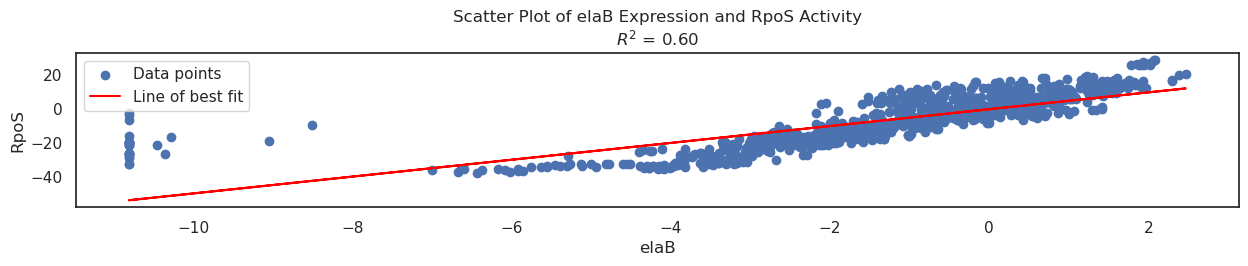

In [125]:
plot_scatter_with_fit(P1K_X, P1K_A, 'elaB', 'RpoS')

In [126]:
# left corners - projects within the figure

#### 0.8 exp var for top iM

In [127]:
(P1K_merged[(P1K_merged['num_iM'] != 0) & (P1K_merged['Top_1_Explained_Variance'] > 0.799) & (P1K_merged['Top_1_Explained_Variance'] <= 0.801)])

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
rfbB                  0.945884                  0.799789   minicoli KOs   
tdcE                  0.900021                  0.799404      Thr/Ser-1   
livM                  0.906324                  0.800637            Lrp   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
rfbB                  0.083714            LPS                  0.062427   
tdcE                  0.083369      Thr/Ser-2                  0.069532   
livM                  0.066032    Hot TALE 16                  0.047551   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
rfbB       Membrane               2       1  0.305180        7.773383   
tdcE          ppGpp               4       1  0.387620        2.174176   
livM     Tryptophan               2       2  0.502561        7.173051   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
rfbB       9.220418                1.944107      Low Variance   
tdcE      12.946761                2.163202      Low Variance   
livM       8.618589                5.831037   Medium Variance   

     Expression_Category                    Combined_Category  
rfbB   Medium Expression     Low Variance - Medium Expression  
tdcE      Low Expression        Low Variance - Low Expression  
livM   Medium Expression  Medium Variance - Medium Expression

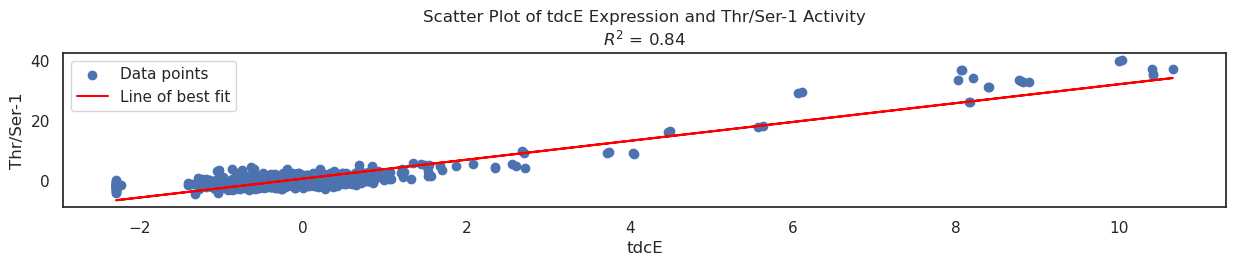

In [128]:
plot_scatter_with_fit(P1K_X, P1K_A, 'tdcE', 'Thr/Ser-1')

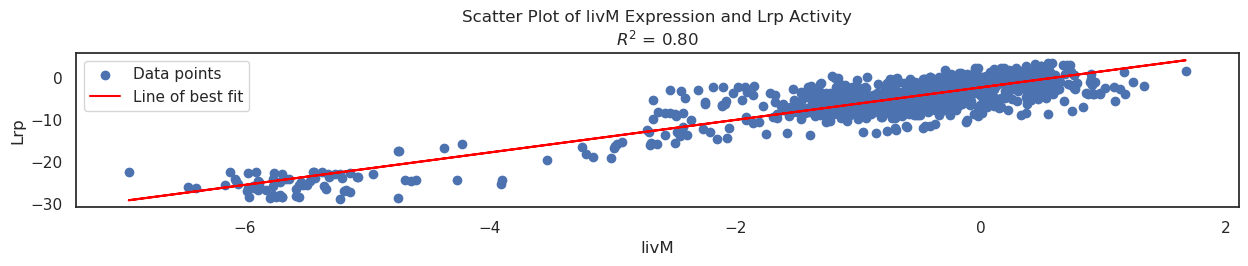

In [129]:
plot_scatter_with_fit(P1K_X, P1K_A, 'livM', 'Lrp')

## What are the final counts in each category of gene?

#### Gene is explained well by iModulons

In [196]:
P1K_merged[(P1K_merged['Total_Explained_Variance'] > 0.6)].shape[0]

2444

In [197]:
P1K_merged

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thrA                  0.899430                  0.686194        thrA KO   
thrB                  0.808533                  0.254512        thrA KO   
thrC                  0.824916                  0.246587        thrA KO   
yaaX                  0.689923                  0.171007    Leu/Val/Ile   
yaaA                  0.638300                  0.428612           OxyR   
...                        ...                       ...            ...   
yneP                  0.748917                  0.629455           yneP   
ynfT                  0.467147                  0.424437     Cold Shock   
yoaL                  0.333663                  0.102746           CpxR   
yqhI                  0.894360                  0.738529           yqhI   
yqiD                  0.896335                  0.554369          Fnr-2   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
thrA                  0.076638         Cysteine-1                  0.075628   
thrB                  0.227884        Leu/Val/Ile                  0.103394   
thrC                  0.234486        Leu/Val/Ile                  0.155906   
yaaX                  0.169602  Nucleotide Stress                  0.095365   
yaaA                  0.171808         Cold Shock                  0.129606   
...                        ...                ...                       ...   
yneP                  0.075002              GadXW                  0.047460   
ynfT                  0.045140                NRZ                  0.033476   
yoaL                  0.066571          Cellulose                  0.044315   
yqhI                  0.091457               UC-8                  0.084815   
yqiD                  0.396718              Fnr-3                  0.087869   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrA     Thiamine-1               3       3  0.708056        9.605329   
thrB        Leucine               1       2  0.698585        9.225274   
thrC      Dipeptide               1       1  0.612527        9.272277   
yaaX      Glycolate               0       3  0.737335        6.283661   
yaaA           UC-8               0       1  0.306569        6.346626   
...             ...             ...     ...       ...             ...   
yneP     Resistance               0       1  1.059936        1.140369   
ynfT            LPS               0       2  1.776698        2.466008   
yoaL          ppGpp               0       2  0.540346        5.048395   
yqhI     Resistance               0       2  1.195671        1.195671   
yqiD           ArcA               0       4  1.062929        5.070150   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrA      11.771901                4.398331   Medium Variance   
thrB       7.560994                3.900854   Medium Variance   
thrC       7.647762                3.681351   Medium Variance   
yaaX      11.817918                4.395201   Medium Variance   
yaaA       8.667107                1.920613      Low Variance   
...             ...                     ...               ...   
yneP       4.458041                2.868327     High Variance   
ynfT       7.650393                6.189466     High Variance   
yoaL       5.552991                2.841891   Medium Variance   
yqhI       7.305199                4.985373     High Variance   
yqiD      11.535971                6.501506     High Variance   

     Expression_Category                    Combined_Category  
thrA   Medium Expression  Medium Variance - Medium Expression  
thrB   Medium Expression  Medium Variance - Medium Expression  
thrC   Medium Expression  Medium Variance - Medium Expression  
yaaX   Medium Expression  Medium Variance - Medium Expression  
yaaA   Medium Expression     Low Variance - Medium Expression  
...                  ...                                  ...  
yneP      Low Expression       High Variance - Low

In [198]:
# Step 1: Calculate the ratio for the entire P1K_merged DataFrame
ratio = P1K_merged['Top_1_Explained_Variance'] / P1K_merged['Total_Explained_Variance']

# Step 2: Filter based on Total_Explained_Variance > 0.5 (Gene_Category_1) and < 0.5 (Gene_Category_2)
Gene_Category_1 = P1K_merged[P1K_merged['Total_Explained_Variance'] > 0.7]
Gene_Category_2 = P1K_merged[P1K_merged['Total_Explained_Variance'] < 0.7]

# Step 3: Recalculate the ratio for Gene_Category_1 to ensure index alignment
ratio_category_1 = Gene_Category_1['Top_1_Explained_Variance'] / Gene_Category_1['Total_Explained_Variance']

# Step 4: From Gene_Category_1, further split into Gene_Category_1_1 and Gene_Category_1_2 based on the recalculated ratio
Gene_Category_1_1 = Gene_Category_1[ratio_category_1 > 0.5]  # Where recalculated ratio > 0.5
Gene_Category_1_2 = Gene_Category_1[ratio_category_1 <= 0.5]  # Where recalculated ratio <= 0.5

In [199]:
Gene_Category_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thrA                  0.899430                  0.686194        thrA KO   
thrB                  0.808533                  0.254512        thrA KO   
thrC                  0.824916                  0.246587        thrA KO   
yaaJ                  0.871146                  0.603634          Fnr-2   
dnaK                  0.838759                  0.820681           RpoH   
...                        ...                       ...            ...   
ynaL                  0.870153                  0.752836           RpoS   
ynaM                  0.859825                  0.814377     Cold Shock   
yneP                  0.748917                  0.629455           yneP   
yqhI                  0.894360                  0.738529           yqhI   
yqiD                  0.896335                  0.554369          Fnr-2   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
thrA                  0.076638      Cysteine-1                  0.075628   
thrB                  0.227884     Leu/Val/Ile                  0.103394   
thrC                  0.234486     Leu/Val/Ile                  0.155906   
yaaJ                  0.272856           ppGpp                  0.097127   
dnaK                  0.060095  nquinone ALE 3                  0.030621   
...                        ...             ...                       ...   
ynaL                  0.214785      PAL 10 Del                  0.063041   
ynaM                  0.164788             LPS                  0.052239   
yneP                  0.075002           GadXW                  0.047460   
yqhI                  0.091457            UC-8                  0.084815   
yqiD                  0.396718           Fnr-3                  0.087869   

         Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrA         Thiamine-1               3       3  0.708056        9.605329   
thrB            Leucine               1       2  0.698585        9.225274   
thrC          Dipeptide               1       1  0.612527        9.272277   
yaaJ              Fnr-1               0       1  0.484317        3.382637   
dnaK  Nucleotide Stress               1       1  0.507845        9.787776   
...                 ...             ...     ...       ...             ...   
ynaL            rcsB KO               0       2  1.400803        4.594118   
ynaM        CCK-PGI Del               0       5  1.053900        3.945465   
yneP         Resistance               0       1  1.059936        1.140369   
yqhI         Resistance               0       2  1.195671        1.195671   
yqiD               ArcA               0       4  1.062929        5.070150   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrA      11.771901                4.398331   Medium Variance   
thrB       7.560994                3.900854   Medium Variance   
thrC       7.647762                3.681351   Medium Variance   
yaaJ       5.231202                3.233388   Medium Variance   
dnaK       9.976865                4.257802   Medium Variance   
...             ...                     ...               ...   
ynaL       9.361632                7.788007     High Variance   
ynaM      12.266527                9.296680     High Variance   
yneP       4.458041                2.868327     High Variance   
yqhI       7.305199                4.985373     High Variance   
yqiD      11.535971                6.501506     High Variance   

     Expression_Category                    Combined_Category  
thrA   Medium Expression  Medium Variance - Medium Expression  
thrB   Medium Expression  Medium Variance - Medium Expression  
thrC   Medium Expression  Medium Variance - Medium Expression  
yaaJ      Low Expression     Medium Variance - Low Expression  
dnaK   Medium Expression  Medium Variance - Medium Expression  
...                  ...                                  ...  
ynaL      Low Expression       High Va

In [200]:
Gene_Category_1_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thrA                   0.899430                  0.686194        thrA KO   
yaaJ                   0.871146                  0.603634          Fnr-2   
dnaK                   0.838759                  0.820681           RpoH   
insL1                  0.786396                  0.588159   minicoli KOs   
insB1                  0.794898                  0.577758            IS1   
...                         ...                       ...            ...   
ynaL                   0.870153                  0.752836           RpoS   
ynaM                   0.859825                  0.814377     Cold Shock   
yneP                   0.748917                  0.629455           yneP   
yqhI                   0.894360                  0.738529           yqhI   
yqiD                   0.896335                  0.554369          Fnr-2   

       Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
thrA                   0.076638      Cysteine-1                  0.075628   
yaaJ                   0.272856           ppGpp                  0.097127   
dnaK                   0.060095  nquinone ALE 3                  0.030621   
insL1                  0.106634            RpoH                  0.056453   
insB1                  0.163817      Cold Shock                  0.150796   
...                         ...             ...                       ...   
ynaL                   0.214785      PAL 10 Del                  0.063041   
ynaM                   0.164788             LPS                  0.052239   
yneP                   0.075002           GadXW                  0.047460   
yqhI                   0.091457            UC-8                  0.084815   
yqiD                   0.396718           Fnr-3                  0.087869   

          Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrA          Thiamine-1               3       3  0.708056        9.605329   
yaaJ               Fnr-1               0       1  0.484317        3.382637   
dnaK   Nucleotide Stress               1       1  0.507845        9.787776   
insL1      IS Elements-1               0       1  0.341678        5.661573   
insB1      IS Elements-1               0       1  0.570320        2.440476   
...                  ...             ...     ...       ...             ...   
ynaL             rcsB KO               0       2  1.400803        4.594118   
ynaM         CCK-PGI Del               0       5  1.053900        3.945465   
yneP          Resistance               0       1  1.059936        1.140369   
yqhI          Resistance               0       2  1.195671        1.195671   
yqiD                ArcA               0       4  1.062929        5.070150   

       range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrA       11.771901                4.398331   Medium Variance   
yaaJ        5.231202                3.233388   Medium Variance   
dnaK        9.976865                4.257802   Medium Variance   
insL1       8.107306                2.687845      Low Variance   
insB1       5.753319                3.593489   Medium Variance   
...              ...                     ...               ...   
ynaL        9.361632                7.788007     High Variance   
ynaM       12.266527                9.296680     High Variance   
yneP        4.458041                2.868327     High Variance   
yqhI        7.305199                4.985373     High Variance   
yqiD       11.535971                6.501506     High Variance   

      Expression_Category                    Combined_Category  
thrA    Medium Expression  Medium Variance - Medium Expression  
yaaJ       Low Expression     Medium Variance - Low Expression  
dnaK    Medium Expression  Medium Variance - Medium Expression  
insL1   Medium Expression     Low Variance - Medium Expression  
insB1      Low Expression     Medium Variance - Low Expression  
...                   ...                        

In [201]:
Gene_Category_1_1_1 = Gene_Category_1_1[Gene_Category_1_1['num_regulators'] == 0]

In [202]:
Gene_Category_1_1_2 = Gene_Category_1_1[Gene_Category_1_1['num_regulators'] == 1]

In [203]:
Gene_Category_1_1_3 = Gene_Category_1_1[Gene_Category_1_1['num_regulators'] >= 2]

In [204]:
Gene_Category_1_1_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yaaJ                   0.871146                  0.603634          Fnr-2   
insL1                  0.786396                  0.588159   minicoli KOs   
insB1                  0.794898                  0.577758            IS1   
insA1                  0.774757                  0.576084            IS1   
rpsT                   0.719152                  0.567716          ppGpp   
...                         ...                       ...            ...   
ynaL                   0.870153                  0.752836           RpoS   
ynaM                   0.859825                  0.814377     Cold Shock   
yneP                   0.748917                  0.629455           yneP   
yqhI                   0.894360                  0.738529           yqhI   
yqiD                   0.896335                  0.554369          Fnr-2   

       Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yaaJ                   0.272856          ppGpp                  0.097127   
insL1                  0.106634           RpoH                  0.056453   
insB1                  0.163817     Cold Shock                  0.150796   
insA1                  0.232821     Cold Shock                  0.196298   
rpsT                   0.146225    Translation                  0.087224   
...                         ...            ...                       ...   
ynaL                   0.214785     PAL 10 Del                  0.063041   
ynaM                   0.164788            LPS                  0.052239   
yneP                   0.075002          GadXW                  0.047460   
yqhI                   0.091457           UC-8                  0.084815   
yqiD                   0.396718          Fnr-3                  0.087869   

      Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaJ           Fnr-1               0       1  0.484317        3.382637   
insL1  IS Elements-1               0       1  0.341678        5.661573   
insB1  IS Elements-1               0       1  0.570320        2.440476   
insA1   minicoli KOs               0       1  0.613605        3.981928   
rpsT            RpoS               0       1  0.613852       11.617342   
...              ...             ...     ...       ...             ...   
ynaL         rcsB KO               0       2  1.400803        4.594118   
ynaM     CCK-PGI Del               0       5  1.053900        3.945465   
yneP      Resistance               0       1  1.059936        1.140369   
yqhI      Resistance               0       2  1.195671        1.195671   
yqiD            ArcA               0       4  1.062929        5.070150   

       range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaJ        5.231202                3.233388   Medium Variance   
insL1       8.107306                2.687845      Low Variance   
insB1       5.753319                3.593489   Medium Variance   
insA1       6.638065                3.336632   Medium Variance   
rpsT       10.959844                3.058403   Medium Variance   
...              ...                     ...               ...   
ynaL        9.361632                7.788007     High Variance   
ynaM       12.266527                9.296680     High Variance   
yneP        4.458041                2.868327     High Variance   
yqhI        7.305199                4.985373     High Variance   
yqiD       11.535971                6.501506     High Variance   

      Expression_Category                  Combined_Category  
yaaJ       Low Expression   Medium Variance - Low Expression  
insL1   Medium Expression   Low Variance - Medium Expression  
insB1      Low Expression   Medium Variance - Low Expression  
insA1      Low Expression   Medium Variance - Low Expression  
rpsT      High Expression  Medium Variance - High Expression  
...                   ...                                ...  
ynaL       Low Expression     High Variance - Low Expressi

In [205]:
Gene_Category_1_1_2

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
dnaK                  0.838759                  0.820681           RpoH   
thiQ                  0.769021                  0.394222     Thiamine-2   
sgrR                  0.733603                  0.499832   minicoli KOs   
leuD                  0.947334                  0.760478        Leucine   
leuC                  0.944463                  0.787572        Leucine   
...                        ...                       ...            ...   
mcrB                  0.762725                  0.434135   minicoli KOs   
yghJ                  0.807081                  0.569582       Membrane   
ykgO                  0.957622                  0.928243         Zinc-1   
arnE                  0.723586                  0.469265           UC-7   
ykgR                  0.952078                  0.856172           ykgR   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
dnaK                  0.060095  nquinone ALE 3                  0.030621   
thiQ                  0.240769    minicoli KOs                  0.229731   
sgrR                  0.110118            UC-7                  0.080890   
leuD                  0.252272             Lrp                  0.092659   
leuC                  0.266839             Lrp                  0.092691   
...                        ...             ...                       ...   
mcrB                  0.103379             LPS                  0.096244   
yghJ                  0.195160    minicoli KOs                  0.047034   
ykgO                  0.064241       Glycolate                  0.038583   
arnE                  0.267394            BasR                  0.072825   
ykgR                  0.092055       FucR/ExuR                  0.088545   

         Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
dnaK  Nucleotide Stress               1       1  0.507845        9.787776   
thiQ         Thiamine-1               1       0  0.639479        4.386961   
sgrR               UC-2               1       0  0.376218        4.471184   
leuD        Leu/Val/Ile               1       1  0.566176        9.649929   
leuC        Leu/Val/Ile               1       2  0.644480        9.552405   
...                 ...             ...     ...       ...             ...   
mcrB               UC-5               1       0  0.658997        4.709887   
yghJ            pts ALE               1       1  0.691926        4.161603   
ykgO      IS Elements-2               1       1  0.714226        2.868530   
arnE            PAL Amp               1       1  0.578796        2.838193   
ykgR              Crp-1               1       2  0.954394        0.954394   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
dnaK       9.976865                4.257802   Medium Variance   
thiQ       6.252424                4.136723   Medium Variance   
sgrR       5.948048                2.231908      Low Variance   
leuD      11.673576                6.009744   Medium Variance   
leuC      12.291172                6.588071   Medium Variance   
...             ...                     ...               ...   
mcrB       8.035991                3.411959   Medium Variance   
yghJ       6.923217                3.173432   Medium Variance   
ykgO      13.958810               10.624772   Medium Variance   
arnE       6.052515                3.019545   Medium Variance   
ykgR       8.137844                6.275493   Medium Variance   

     Expression_Category                    Combined_Category  
dnaK   Medium Expression  Medium Variance - Medium Expression  
thiQ      Low Expression     Medium Variance - Low Expression  
sgrR      Low Expression        Low Variance - Low Expression  
leuD   Medium Expression  Medium Variance - Medium Expression  
leuC   Medium Expression  Medium Variance - Medium Expression  
...                  ...                                  ...  
mcrB      Low Expression     Medium Va

In [206]:
Gene_Category_1_1_3

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
thrA                  0.899430                  0.686194        thrA KO   
dapB                  0.855447                  0.657484    Lysine/T2SS   
carA                  0.915743                  0.604033     Pyrimidine   
carB                  0.912185                  0.681518     Pyrimidine   
araA                  0.836994                  0.455904        BW25113   
...                        ...                       ...            ...   
yoeB                  0.818890                  0.602389   minicoli KOs   
yjjZ                  0.961843                  0.889096           yjjZ   
mntS                  0.701906                  0.362038     Resistance   
ytiC                  0.951526                  0.832148           ytiC   
ymjE                  0.848340                  0.823633     Putrescine   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
thrA                  0.076638      Cysteine-1                  0.075628   
dapB                  0.150827        Arginine                  0.147150   
carA                  0.383065        Arginine                  0.069725   
carB                  0.338960        Arginine                  0.118451   
araA                  0.245923  FucR/AllR/AraC                  0.072137   
...                        ...             ...                       ...   
yoeB                  0.113367   IS Elements-1                  0.111968   
yjjZ                  0.255314           Fur-1                  0.035648   
mntS                  0.171983      Cold Shock                  0.111194   
ytiC                  0.029525        Membrane                  0.028702   
ymjE                  0.134732            ArcA                  0.082147   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrA     Thiamine-1               3       3  0.708056        9.605329   
dapB     Cold Shock               3       2  0.749405        7.827295   
carA     Methionine               8       2  1.309659        8.084122   
carB     Cysteine-1               7       3  1.073089        7.672117   
araA   Sugar Diacid               3       3  0.720141        2.011495   
...             ...             ...     ...       ...             ...   
yoeB           UC-7               4       0  0.333941        6.626106   
yjjZ          Fur-2               3       2  1.377965        3.435410   
mntS           ArcA               2       3  1.267928        8.204795   
ytiC     Cold Shock               3       2  1.108589        1.108589   
ymjE          Fnr-1               2       1  1.356016        4.276580   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrA      11.771901                4.398331   Medium Variance   
dapB       7.680850                3.094452   Medium Variance   
carA      10.050436                6.804923     High Variance   
carB       9.645652                6.114761     High Variance   
araA      11.005361                3.816253   Medium Variance   
...             ...                     ...               ...   
yoeB       9.562672                1.904533      Low Variance   
yjjZ      13.499736                9.152233     High Variance   
mntS       9.662623                5.157119     High Variance   
ytiC       8.603045                6.157923     High Variance   
ymjE       8.479004                6.221878     High Variance   

     Expression_Category                    Combined_Category  
thrA   Medium Expression  Medium Variance - Medium Expression  
dapB   Medium Expression  Medium Variance - Medium Expression  
carA   Medium Expression    High Variance - Medium Expression  
carB   Medium Expression    High Variance - Medium Expression  
araA      Low Expression     Medium Variance - Low Expression  
...                  ...                                  ...  
yoeB   Medium Expression     Low Variance - Medium Expression  
yjjZ      Low Expressi

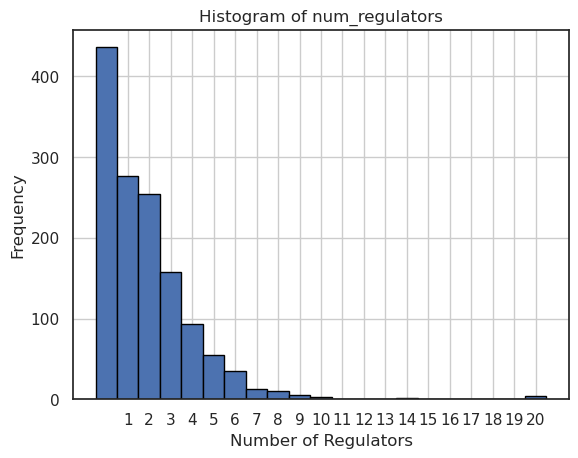

In [207]:
# Create the histogram with bins corresponding to integer values 1, 2, 3, 4, etc.
bins = np.arange(Gene_Category_1_1['num_regulators'].min(), Gene_Category_1_1['num_regulators'].max() + 2) - 0.5

# Plot the histogram with the specified bins
Gene_Category_1_1['num_regulators'].hist(bins=bins, edgecolor='black')

# Set the x-axis to show integer values only
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Set x-axis labels to only show integer values
plt.xticks(np.arange(1, Gene_Category_1_1['num_regulators'].max() + 1))

# Display the plot
plt.xlabel('Number of Regulators')
plt.ylabel('Frequency')
plt.title('Histogram of num_regulators')
plt.show()

In [208]:
Gene_Category_1_2

Total_Explained_Variance  Top_1_Explained_Variance  Top_1_iModulon  \
thrB                   0.808533                  0.254512         thrA KO   
thrC                   0.824916                  0.246587         thrA KO   
rihC                   0.839066                  0.225119           Crp-1   
caiF                   0.839462                  0.225458      Pyrimidine   
araD                   0.794265                  0.337619  FucR/AllR/AraC   
...                         ...                       ...             ...   
topAI                  0.744067                  0.274147         baeR KO   
yjgX                   0.822910                  0.366736      Cold Shock   
ybeM                   0.840978                  0.301178    minicoli KOs   
yghX                   0.906461                  0.382909            RpoS   
sgrT                   0.727338                  0.185501            UC-6   

       Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
thrB                   0.227884    Leu/Val/Ile                  0.103394   
thrC                   0.234486    Leu/Val/Ile                  0.155906   
rihC                   0.210690            IS5                  0.149670   
caiF                   0.193561      Cellulose                  0.101240   
araD                   0.311354        BW25113                  0.089609   
...                         ...            ...                       ...   
topAI                  0.267088          Crp-1                  0.256388   
yjgX                   0.164181   minicoli KOs                  0.105195   
ybeM                   0.206186           UC-7                  0.158738   
yghX                   0.172577           UC-2                  0.170308   
sgrT                   0.134732         pgi KO                  0.102708   

      Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrB         Leucine               1       2  0.698585        9.225274   
thrC       Dipeptide               1       1  0.612527        9.272277   
rihC           Crp-2               0       0  0.606837        4.242850   
caiF           Fnr-2               3       3  0.886135        4.851363   
araD            UC-2               3       3  0.580872        1.558602   
...              ...             ...     ...       ...             ...   
topAI  Tryptophanase               0       2  0.801319        2.923673   
yjgX            UC-7               0       0  0.630647        4.405094   
ybeM       Glutarate               0       0  0.465396        4.464968   
yghX            UC-8               0       1  1.073887        3.918894   
sgrT       Glycolate               4       6  0.986258        5.651568   

       range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrB        7.560994                3.900854   Medium Variance   
thrC        7.647762                3.681351   Medium Variance   
rihC        6.853657                4.007938   Medium Variance   
caiF        9.844207                4.459237   Medium Variance   
araD       10.391511                3.231925   Medium Variance   
...              ...                     ...               ...   
topAI       6.499048                4.092123   Medium Variance   
yjgX        8.799003                3.565604   Medium Variance   
ybeM        7.025546                2.652893   Medium Variance   
yghX        8.628413                4.596682     High Variance   
sgrT       13.766067                5.725669   Medium Variance   

      Expression_Category                    Combined_Category  
thrB    Medium Expression  Medium Variance - Medium Expression  
thrC    Medium Expression  Medium Variance - Medium Expression  
rihC       Low Expression     Medium Variance - Low Expression  
caiF       Low Expression     Medium Variance - Low Expression  
araD       Low Expression     Medium Variance - Low Expression  
...                   ...                                  ...  
topAI      Low Expression     Me

## Genes not explained well by iMs

In [209]:
Gene_Category_2

Total_Explained_Variance  Top_1_Explained_Variance  Top_1_iModulon  \
yaaX                  0.689923                  0.171007     Leu/Val/Ile   
yaaA                  0.638300                  0.428612            OxyR   
talB                  0.682956                  0.172291      Cold Shock   
mog                   0.506701                  0.085929            UC-5   
satP                  0.493471                  0.200700           ppGpp   
...                        ...                       ...             ...   
ykgV                  0.102363                  0.148485    minicoli KOs   
ymgM                  0.390130                  0.111164  Salicylic Acid   
yncO                  0.127377                  0.068596             LPS   
ynfT                  0.467147                  0.424437      Cold Shock   
yoaL                  0.333663                  0.102746            CpxR   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
yaaX                  0.169602  Nucleotide Stress                  0.095365   
yaaA                  0.171808         Cold Shock                  0.129606   
talB                  0.101844               UC-8                  0.086532   
mog                   0.075019          Cellulose                  0.061941   
satP                  0.155376               UC-1                  0.067117   
...                        ...                ...                       ...   
ykgV                  0.062027              Crp-2                  0.049964   
ymgM                  0.065360         Resistance                  0.036040   
yncO                  0.058011               yneP                  0.057207   
ynfT                  0.045140                NRZ                  0.033476   
yoaL                  0.066571          Cellulose                  0.044315   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaX      Glycolate               0       3  0.737335        6.283661   
yaaA           UC-8               0       1  0.306569        6.346626   
talB      Thr/Ser-1               0       0  0.338511       10.398865   
mog            RpoS               0       2  0.338561        6.015463   
satP          Fnr-2               0       0  0.439089        4.494419   
...             ...             ...     ...       ...             ...   
ykgV       Sorbitol               0       0  0.551441        2.914096   
ymgM    N Reduction               0       1  0.597075        3.743933   
yncO           gcvB               0       2  0.000000        0.000000   
ynfT            LPS               0       2  1.776698        2.466008   
yoaL          ppGpp               0       2  0.540346        5.048395   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaX      11.817918                4.395201   Medium Variance   
yaaA       8.667107                1.920613      Low Variance   
talB      10.333659                2.227178      Low Variance   
mog        6.399666                1.675159      Low Variance   
satP       5.686456                2.316261   Medium Variance   
...             ...                     ...               ...   
ykgV       5.373150                3.506563   Medium Variance   
ymgM       6.823835                2.877647   Medium Variance   
yncO       4.344567                2.211259      Low Variance   
ynfT       7.650393                6.189466     High Variance   
yoaL       5.552991                2.841891   Medium Variance   

     Expression_Category                    Combined_Category  
yaaX   Medium Expression  Medium Variance - Medium Expression  
yaaA   Medium Expression     Low Variance - Medium Expression  
talB     High Expression       Low Variance - High Expression  
mog    Medium Expression     Low Variance - Medium Expression  
satP      Low Expression     Medium Variance - Low Expression  
...                  ...                                  ...  
ykgV      Low Expression     Medium Va

<AxesSubplot:>

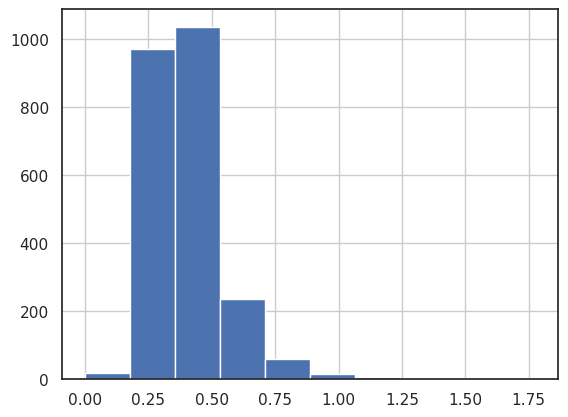

In [210]:
Gene_Category_2['MAD'].hist()

In [211]:
Gene_Category_2['MAD'].mean()

0.4019074843440441

In [218]:
# Subset Gene_Category_2 into four categories based on MAD and num_regulators

# Category_2_1: MAD < 0.4
Gene_Category_2_1 = Gene_Category_2[Gene_Category_2['MAD'] < 0.4]

# Category_2_2: MAD > 0.4 and num_regulators > 1
Gene_Category_2_2 = Gene_Category_2[(Gene_Category_2['MAD'] > 0.4) & (Gene_Category_2['num_regulators'] > 1)]

# Category_2_3: MAD > 0.4 and num_regulators == 1
Gene_Category_2_3 = Gene_Category_2[(Gene_Category_2['MAD'] > 0.4) & (Gene_Category_2['num_regulators'] == 1)]

# Category_2_4: MAD > 0.4 and num_regulators == 0
Gene_Category_2_4 = Gene_Category_2[(Gene_Category_2['MAD'] > 0.4) & (Gene_Category_2['num_regulators'] == 0)]

# Check if all rows in Gene_Category_2 belong to one of the categories
# Combine all categories and check if their total number of rows equals Gene_Category_2
all_categories_combined = pd.concat([Category_2_1, Category_2_2, Category_2_3, Category_2_4])

# Check if all rows in Gene_Category_2 are in the combined categories
all_belong = all_categories_combined.shape[0] == Gene_Category_2.shape[0]

# Output the result of the check
print(f"All rows in Gene_Category_2 belong to one of the categories: {all_belong}")


All rows in Gene_Category_2 belong to one of the categories: True


In [219]:
Gene_Category_2_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yaaA                  0.638300                  0.428612           OxyR   
talB                  0.682956                  0.172291     Cold Shock   
mog                   0.506701                  0.085929           UC-5   
yaaW                 -0.197540                  0.184582     Cold Shock   
mbiA                 -0.111055                  0.090604           UC-5   
...                        ...                       ...            ...   
insO                  0.582688                  0.319921      Cellulose   
ypjI                 -0.127160                  0.071093       SSW SNPs   
yfcU                  0.550447                  0.129206          ppGpp   
yqcG                  0.088879                  0.160563           gcvB   
yncO                  0.127377                  0.068596            LPS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yaaA                  0.171808     Cold Shock                  0.129606   
talB                  0.101844           UC-8                  0.086532   
mog                   0.075019      Cellulose                  0.061941   
yaaW                  0.082831    Translation                  0.062717   
mbiA                  0.079584     DNA Damage                  0.073846   
...                        ...            ...                       ...   
insO                  0.117145     DNA Damage                  0.096928   
ypjI                  0.040261        Glycine                  0.021069   
yfcU                  0.086144        FlhDC-1                  0.079983   
yqcG                  0.037913           ymdG                  0.031955   
yncO                  0.058011           yneP                  0.057207   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaA           UC-8               0       1  0.306569        6.346626   
talB      Thr/Ser-1               0       0  0.338511       10.398865   
mog            RpoS               0       2  0.338561        6.015463   
yaaW           UC-6               0       0  0.360424        2.109164   
mbiA           UC-6               1       1  0.344671        0.594516   
...             ...             ...     ...       ...             ...   
insO   minicoli KOs               0       0  0.376531        3.493684   
ypjI           ydaG               0       0  0.363043        0.363043   
yfcU           FliA               0       0  0.296522        2.619611   
yqcG           yneP               0       0  0.000000        0.000000   
yncO           gcvB               0       2  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaA       8.667107                1.920613      Low Variance   
talB      10.333659                2.227178      Low Variance   
mog        6.399666                1.675159      Low Variance   
yaaW       4.097773                1.758149      Low Variance   
mbiA       4.124902                1.753399      Low Variance   
...             ...                     ...               ...   
insO       5.578886                2.004758      Low Variance   
ypjI       3.609087                1.475925      Low Variance   
yfcU       3.162579                1.634183      Low Variance   
yqcG       3.558419                1.528627      Low Variance   
yncO       4.344567                2.211259      Low Variance   

     Expression_Category                 Combined_Category  
yaaA   Medium Expression  Low Variance - Medium Expression  
talB     High Expression    Low Variance - High Expression  
mog    Medium Expression  Low Variance - Medium Expression  
yaaW      Low Expression     Low Variance - Low Expression  
mbiA      Low Expression     Low Variance - Low Expression  
...                  ...                               ...  
insO      Low Expression     Low Variance - Low Expression  
ypjI      Low Expression     Low Variance - Low Expression

In [220]:
Gene_Category_2_2

Total_Explained_Variance  Top_1_Explained_Variance     Top_1_iModulon  \
nhaA                  0.656733                  0.296767               UC-8   
caiE                  0.351196                  0.097285          Cellulose   
caiA                  0.687231                  0.114313       Microaerobic   
fixX                  0.016148                  0.070135               UC-2   
rapA                  0.612688                  0.185194  Nucleotide Stress   
...                        ...                       ...                ...   
dgoA                  0.350439                  0.126031          Galactose   
sgcB                  0.364876                  0.197233            baeR KO   
yciZ                  0.447135                  0.112592         Resistance   
ytiD                  0.552093                  0.246947         Cysteine-1   
rseD                  0.605239                  0.236640         Resistance   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
nhaA                  0.146621          GadXW                  0.098623   
caiE                  0.093530       Membrane                  0.063237   
caiA                  0.106012     Isc System                  0.077794   
fixX                  0.036621    Efflux Pump                  0.033455   
rapA                  0.128800          ppGpp                  0.093770   
...                        ...            ...                       ...   
dgoA                  0.110811          Crp-1                  0.094250   
sgcB                  0.081770          Crp-2                  0.075174   
yciZ                  0.097611    Leu/Val/Ile                  0.051050   
ytiD                  0.112113            LPS                  0.095751   
rseD                  0.099325           UC-8                  0.092584   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
nhaA           RpoS               3       0  0.442322        5.930505   
caiE    Translation               3       0  0.492851        1.775820   
caiA           NrdR               3       0  0.423677        3.633143   
fixX            LPS               2       1  0.452503        1.067281   
rapA           UC-5               2       0  0.500676        5.664119   
...             ...             ...     ...       ...             ...   
dgoA           gcvB               2       0  0.434632        2.180758   
sgcB        Maltose               2       1  0.650826        1.934520   
yciZ          Fnr-3               2       0  0.621195        7.141887   
ytiD           ytiC               3       6  1.117532        2.835899   
rseD  IS Elements-1               8       1  0.458624        7.536529   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
nhaA       6.769833                2.521088   Medium Variance   
caiE       4.214724                2.373494   Medium Variance   
caiA       4.135540                1.972215   Medium Variance   
fixX       4.073628                2.146699   Medium Variance   
rapA       6.430957                2.224828   Medium Variance   
...             ...                     ...               ...   
dgoA       6.007734                2.636896   Medium Variance   
sgcB       9.804850                5.953115   Medium Variance   
yciZ       6.889156                2.938093   Medium Variance   
ytiD       9.141994                5.420978     High Variance   
rseD       7.540760                2.542903   Medium Variance   

     Expression_Category                    Combined_Category  
nhaA   Medium Expression  Medium Variance - Medium Expression  
caiE      Low Expression     Medium Variance - Low Expression  
caiA      Low Expression     Medium Variance - Low Expression  
fixX      Low Expression     Medium Variance - Low Expression  
rapA   Medium Expression  Medium Variance - Medium Expression  
...                  ...                                  ...  
dgoA      Low Expression     Medium Variance - Low

In [221]:
Gene_Category_2_3

Total_Explained_Variance  Top_1_Explained_Variance     Top_1_iModulon  \
dnaJ                  0.681392                  0.743583               RpoH   
rluA                  0.549426                  0.157773  Nucleotide Stress   
polB                  0.579311                  0.366814         DNA Damage   
yabI                  0.694194                  0.388120       minicoli KOs   
ppdD                  0.443970                  0.179786         Cold Shock   
...                        ...                       ...                ...   
hdfR                  0.110496                  0.128831        Translation   
yjdP                  0.486797                  0.174301               UC-4   
torI                  0.681824                  0.332301         Resistance   
ymjC                  0.248773                  0.234377              Crp-1   
arfA                  0.369858                  0.207988         Resistance   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
dnaJ                  0.048535          Biotin                  0.042507   
rluA                  0.091675   Tryptophanase                  0.084187   
polB                  0.090327      Suf System                  0.053396   
yabI                  0.123646         Acetate                  0.078837   
ppdD                  0.097996       Cellulose                  0.071529   
...                        ...             ...                       ...   
hdfR                  0.107823  Osmoprotectant                  0.071940   
yjdP                  0.138186    minicoli KOs                  0.122201   
torI                  0.269735      Cold Shock                  0.079640   
ymjC                  0.121261       Cellulose                  0.102268   
arfA                  0.069138            UC-3                  0.049204   

      Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
dnaJ            gcvB               1       1  0.465280        7.786792   
rluA            UC-5               1       1  0.462133        5.449215   
polB            UC-2               1       1  0.405913        4.041176   
yabI             IS5               1       0  0.420631        4.917030   
ppdD     Efflux Pump               1       0  0.417522        0.864856   
...              ...             ...     ...       ...             ...   
hdfR            UC-2               1       0  0.401105        5.765187   
yjdP           ppGpp               1       1  0.468213        4.825975   
torI            UC-2               1       1  1.036633        6.173155   
ymjC            RpoS               1       1  0.685467        3.520729   
arfA  nquinone ALE 3               1       2  0.650676        5.232379   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
dnaJ       7.405924                3.525426   Medium Variance   
rluA       5.988804                2.249792   Medium Variance   
polB       4.788142                2.393369   Medium Variance   
yabI       7.978538                2.236507   Medium Variance   
ppdD       4.977114                2.843761   Medium Variance   
...             ...                     ...               ...   
hdfR       5.826514                1.911966      Low Variance   
yjdP       9.505614                2.555986   Medium Variance   
torI       7.834610                4.648174     High Variance   
ymjC       6.735875                3.595454   Medium Variance   
arfA       6.779207                2.947846   Medium Variance   

     Expression_Category                    Combined_Category  
dnaJ   Medium Expression  Medium Variance - Medium Expression  
rluA   Medium Expression  Medium Variance - Medium Expression  
polB      Low Expression     Medium Variance - Low Expression  
yabI      Low Expression     Medium Variance - Low Expression  
ppdD      Low Expression     Medium Variance - Low Expression  
...                  ...                                  ...  
hdfR   Medium Expression  

In [222]:
Gene_Category_2_4

Total_Explained_Variance  Top_1_Explained_Variance  Top_1_iModulon  \
yaaX                  0.689923                  0.171007     Leu/Val/Ile   
satP                  0.493471                  0.200700           ppGpp   
mokC                  0.262912                  0.198089           Crp-1   
yaaY                  0.553561                  0.192159            UC-8   
kefF                  0.591896                  0.200539            RpoS   
...                        ...                       ...             ...   
ytiA                  0.219879                  0.150445           Fnr-1   
ykgV                  0.102363                  0.148485    minicoli KOs   
ymgM                  0.390130                  0.111164  Salicylic Acid   
ynfT                  0.467147                  0.424437      Cold Shock   
yoaL                  0.333663                  0.102746            CpxR   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
yaaX                  0.169602  Nucleotide Stress                  0.095365   
satP                  0.155376               UC-1                  0.067117   
mokC                  0.178807               UC-7                  0.122974   
yaaY                  0.152893              ppGpp                  0.134499   
kefF                  0.190540         Cold Shock                  0.078646   
...                        ...                ...                       ...   
ytiA                  0.113153              Fnr-2                  0.093400   
ykgV                  0.062027              Crp-2                  0.049964   
ymgM                  0.065360         Resistance                  0.036040   
ynfT                  0.045140                NRZ                  0.033476   
yoaL                  0.066571          Cellulose                  0.044315   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaX      Glycolate               0       3  0.737335        6.283661   
satP          Fnr-2               0       0  0.439089        4.494419   
mokC      Cellulose               0       0  0.622979        3.724600   
yaaY     Cold Shock               0       1  0.844731        3.874262   
kefF          Fnr-3               0       0  0.547719        4.391251   
...             ...             ...     ...       ...             ...   
ytiA   Cytochrome c               0       1  0.564531        2.503598   
ykgV       Sorbitol               0       0  0.551441        2.914096   
ymgM    N Reduction               0       1  0.597075        3.743933   
ynfT            LPS               0       2  1.776698        2.466008   
yoaL          ppGpp               0       2  0.540346        5.048395   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaX      11.817918                4.395201   Medium Variance   
satP       5.686456                2.316261   Medium Variance   
mokC       7.510067                3.462715   Medium Variance   
yaaY       8.741341                3.901262   Medium Variance   
kefF       5.407351                2.925742   Medium Variance   
...             ...                     ...               ...   
ytiA       6.960654                3.637947   Medium Variance   
ykgV       5.373150                3.506563   Medium Variance   
ymgM       6.823835                2.877647   Medium Variance   
ynfT       7.650393                6.189466     High Variance   
yoaL       5.552991                2.841891   Medium Variance   

     Expression_Category                    Combined_Category  
yaaX   Medium Expression  Medium Variance - Medium Expression  
satP      Low Expression     Medium Variance - Low Expression  
mokC      Low Expression     Medium Variance - Low Expression  
yaaY      Low Expression     Medium Variance - Low Expression  
kefF      Low Expression     Medium Variance - Low Expression  
...                  ...                                  ...  
ytiA      Low Expression     Medium Va

follow the previous formatting - crreate a sankey diagram plotting input - 4257 PRECISE-1K genes - split to Explained Well by iMs with 1915 genes - NOT explained well by iMs with 2342 genes - Explained Well by iMs with 1915 genes split to Dominant Regulation (1343) - and Combined Regulation (572)   -   NOT explained well by iMs with 2342 genes  split to No Activation condition in PRECISE-1K (1391) - Complex Regulation (249) Single Regulator (245) No Regulator (457)

In [230]:
import os

def save_gene_categories_to_csv(folder_name, dataframe_dict):
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Loop through each dataframe and save it as a CSV file
    for df_name, df in dataframe_dict.items():
        file_name = f"{folder_name}/{df_name}.csv"
        df.to_csv(file_name, index=True)  # Save dataframe to CSV with index

    print(f"DataFrames saved in the '{folder_name}' folder.")


In [231]:
dataframes = {
    'Gene_Category_1_1_1': Gene_Category_1_1_1,
    'Gene_Category_1_1_2': Gene_Category_1_1_2,
    'Gene_Category_1_1_3': Gene_Category_1_1_3,
    'Gene_Category_1_2': Gene_Category_1_2,
    'Gene_Category_2_1': Gene_Category_2_1,
    'Gene_Category_2_2': Gene_Category_2_2,
    'Gene_Category_2_3': Gene_Category_2_3,
    'Gene_Category_2_4': Gene_Category_2_4
}

save_gene_categories_to_csv("Gene_Category", dataframes)


DataFrames saved in the 'Gene_Category' folder.


In [233]:
P1K_merged.to_csv('../Data/P1K_merged_with_Category.csv')

## No regulator Category

In [234]:
Gene_Category_2_4

Total_Explained_Variance  Top_1_Explained_Variance  Top_1_iModulon  \
yaaX                  0.689923                  0.171007     Leu/Val/Ile   
satP                  0.493471                  0.200700           ppGpp   
mokC                  0.262912                  0.198089           Crp-1   
yaaY                  0.553561                  0.192159            UC-8   
kefF                  0.591896                  0.200539            RpoS   
...                        ...                       ...             ...   
ytiA                  0.219879                  0.150445           Fnr-1   
ykgV                  0.102363                  0.148485    minicoli KOs   
ymgM                  0.390130                  0.111164  Salicylic Acid   
ynfT                  0.467147                  0.424437      Cold Shock   
yoaL                  0.333663                  0.102746            CpxR   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
yaaX                  0.169602  Nucleotide Stress                  0.095365   
satP                  0.155376               UC-1                  0.067117   
mokC                  0.178807               UC-7                  0.122974   
yaaY                  0.152893              ppGpp                  0.134499   
kefF                  0.190540         Cold Shock                  0.078646   
...                        ...                ...                       ...   
ytiA                  0.113153              Fnr-2                  0.093400   
ykgV                  0.062027              Crp-2                  0.049964   
ymgM                  0.065360         Resistance                  0.036040   
ynfT                  0.045140                NRZ                  0.033476   
yoaL                  0.066571          Cellulose                  0.044315   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaX      Glycolate               0       3  0.737335        6.283661   
satP          Fnr-2               0       0  0.439089        4.494419   
mokC      Cellulose               0       0  0.622979        3.724600   
yaaY     Cold Shock               0       1  0.844731        3.874262   
kefF          Fnr-3               0       0  0.547719        4.391251   
...             ...             ...     ...       ...             ...   
ytiA   Cytochrome c               0       1  0.564531        2.503598   
ykgV       Sorbitol               0       0  0.551441        2.914096   
ymgM    N Reduction               0       1  0.597075        3.743933   
ynfT            LPS               0       2  1.776698        2.466008   
yoaL          ppGpp               0       2  0.540346        5.048395   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaX      11.817918                4.395201   Medium Variance   
satP       5.686456                2.316261   Medium Variance   
mokC       7.510067                3.462715   Medium Variance   
yaaY       8.741341                3.901262   Medium Variance   
kefF       5.407351                2.925742   Medium Variance   
...             ...                     ...               ...   
ytiA       6.960654                3.637947   Medium Variance   
ykgV       5.373150                3.506563   Medium Variance   
ymgM       6.823835                2.877647   Medium Variance   
ynfT       7.650393                6.189466     High Variance   
yoaL       5.552991                2.841891   Medium Variance   

     Expression_Category                    Combined_Category  
yaaX   Medium Expression  Medium Variance - Medium Expression  
satP      Low Expression     Medium Variance - Low Expression  
mokC      Low Expression     Medium Variance - Low Expression  
yaaY      Low Expression     Medium Variance - Low Expression  
kefF      Low Expression     Medium Variance - Low Expression  
...                  ...                                  ...  
ytiA      Low Expression     Medium Va

In [249]:
def calculate_percentage_y(df):
    """
    Calculates the percentage of rows whose index starts with 'y' and those that do not.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    
    Returns:
    dict: A dictionary with the percentage of rows that start with 'y' and those that do not.
    """
    
    # Get total number of rows
    total_rows = len(df)
    
    # Count how many row indices start with 'y'
    rows_start_with_y = sum([str(index).startswith('y') for index in df.index])
    print(rows_start_with_y)
    
    # Calculate percentages
    percentage_y = (rows_start_with_y / total_rows) * 100
    percentage_not_y = 100 - percentage_y
    
    return {
        "Percentage of rows starting with 'y'": percentage_y,
        "Percentage of rows not starting with 'y'": percentage_not_y
    }

In [250]:
calculate_percentage_y(Gene_Category_2_4)

264


{"Percentage of rows starting with 'y'": 57.76805251641138,
 "Percentage of rows not starting with 'y'": 42.23194748358862}

'./Case_Study_Plots/pie_chart_y_gene_percentage.svg'

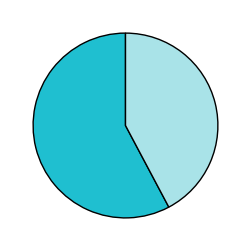

In [238]:
import matplotlib.pyplot as plt

# Data for the pie chart
data = {
    "Percentage of rows starting with 'y'": 57.76805251641138,
    "Percentage of rows not starting with 'y'": 42.23194748358862
}

# Colors for the pie chart: 'y' and 'not y'
colors = ['#1FBFD0', '#A9E3E8']  # Custom colors

# Save the pie chart as an SVG file
svg_save_path = './Case_Study_Plots/pie_chart_y_gene_percentage.svg'

# Create the pie chart again and save it to SVG
plt.figure(figsize=(3, 3))
plt.pie(data.values(), colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'}, labels=None)

# Save the figure
plt.savefig(svg_save_path, format='svg')

# Provide the file path for download
svg_save_path

## No activation condition

In [239]:
Gene_Category_2_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yaaA                  0.638300                  0.428612           OxyR   
talB                  0.682956                  0.172291     Cold Shock   
mog                   0.506701                  0.085929           UC-5   
yaaW                 -0.197540                  0.184582     Cold Shock   
mbiA                 -0.111055                  0.090604           UC-5   
...                        ...                       ...            ...   
insO                  0.582688                  0.319921      Cellulose   
ypjI                 -0.127160                  0.071093       SSW SNPs   
yfcU                  0.550447                  0.129206          ppGpp   
yqcG                  0.088879                  0.160563           gcvB   
yncO                  0.127377                  0.068596            LPS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yaaA                  0.171808     Cold Shock                  0.129606   
talB                  0.101844           UC-8                  0.086532   
mog                   0.075019      Cellulose                  0.061941   
yaaW                  0.082831    Translation                  0.062717   
mbiA                  0.079584     DNA Damage                  0.073846   
...                        ...            ...                       ...   
insO                  0.117145     DNA Damage                  0.096928   
ypjI                  0.040261        Glycine                  0.021069   
yfcU                  0.086144        FlhDC-1                  0.079983   
yqcG                  0.037913           ymdG                  0.031955   
yncO                  0.058011           yneP                  0.057207   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaA           UC-8               0       1  0.306569        6.346626   
talB      Thr/Ser-1               0       0  0.338511       10.398865   
mog            RpoS               0       2  0.338561        6.015463   
yaaW           UC-6               0       0  0.360424        2.109164   
mbiA           UC-6               1       1  0.344671        0.594516   
...             ...             ...     ...       ...             ...   
insO   minicoli KOs               0       0  0.376531        3.493684   
ypjI           ydaG               0       0  0.363043        0.363043   
yfcU           FliA               0       0  0.296522        2.619611   
yqcG           yneP               0       0  0.000000        0.000000   
yncO           gcvB               0       2  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaA       8.667107                1.920613      Low Variance   
talB      10.333659                2.227178      Low Variance   
mog        6.399666                1.675159      Low Variance   
yaaW       4.097773                1.758149      Low Variance   
mbiA       4.124902                1.753399      Low Variance   
...             ...                     ...               ...   
insO       5.578886                2.004758      Low Variance   
ypjI       3.609087                1.475925      Low Variance   
yfcU       3.162579                1.634183      Low Variance   
yqcG       3.558419                1.528627      Low Variance   
yncO       4.344567                2.211259      Low Variance   

     Expression_Category                 Combined_Category  
yaaA   Medium Expression  Low Variance - Medium Expression  
talB     High Expression    Low Variance - High Expression  
mog    Medium Expression  Low Variance - Medium Expression  
yaaW      Low Expression     Low Variance - Low Expression  
mbiA      Low Expression     Low Variance - Low Expression  
...                  ...                               ...  
insO      Low Expression     Low Variance - Low Expression  
ypjI      Low Expression     Low Variance - Low Expression

In [242]:
Gene_Category_2_1_1 = Gene_Category_2_1[(Gene_Category_2_1['num_regulators'] > 1)]

In [244]:
Gene_Category_2_1_2 = Gene_Category_2_1[(Gene_Category_2_1['num_regulators'] == 1)]

In [245]:
Gene_Category_2_1_3 = Gene_Category_2_1[(Gene_Category_2_1['num_regulators'] == 0)]

In [246]:
Gene_Category_2_1_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
nhaR                  0.623232                  0.251819           UC-8   
ileS                  0.503435                  0.175613           UC-8   
lspA                  0.338387                  0.167078           UC-8   
fkpB                  0.439939                  0.152394           UC-1   
ispH                  0.493543                  0.212825        pts ALE   
...                        ...                       ...            ...   
trpR                  0.658701                  0.283350     Cold Shock   
frlC                  0.515144                  0.153564   minicoli KOs   
gntU                  0.610381                  0.121562        Acetate   
dgoD                  0.164287                  0.113648      Galactose   
phnE                  0.619350                  0.575134    Phosphate-2   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
nhaR                  0.114786           GadX                  0.109867   
ileS                  0.104382        baeR KO                  0.089514   
lspA                  0.159022        pts ALE                  0.091487   
fkpB                  0.140081        pts ALE                  0.089279   
ispH                  0.152170        baeR KO                  0.130766   
...                        ...            ...                       ...   
trpR                  0.160940     Tryptophan                  0.084527   
frlC                  0.100888    Translation                  0.084652   
gntU                  0.068222      Cellulose                  0.046616   
dgoD                  0.098941     Propionate                  0.086721   
phnE                  0.057082       SSW SNPs                  0.016978   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
nhaR    Translation               4       0  0.363013        5.417843   
ileS        Leucine               2       0  0.303535        8.628827   
lspA        baeR KO               2       0  0.315533        7.638434   
fkpB        baeR KO               2       0  0.329783        7.258662   
ispH           UC-8               2       0  0.273350        7.130266   
...             ...             ...     ...       ...             ...   
trpR           UC-6               2       0  0.367620        6.851308   
frlC    Sialic Acid               2       0  0.360192        2.305281   
gntU           ArcA               3       1  0.382904        2.514851   
dgoD        pts ALE               2       0  0.396545        2.821573   
phnE            LPS               2       1  0.267170        0.332791   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
nhaR       5.723037                1.820896      Low Variance   
ileS       8.758058                1.627546      Low Variance   
lspA       8.462606                1.712491      Low Variance   
fkpB       8.365505                1.636862      Low Variance   
ispH       8.099821                1.418308      Low Variance   
...             ...                     ...               ...   
trpR       6.203654                2.271737      Low Variance   
frlC       4.065310                1.884785      Low Variance   
gntU       8.161228                2.225487      Low Variance   
dgoD       7.205152                2.085554      Low Variance   
phnE       7.444019                1.267795      Low Variance   

     Expression_Category                 Combined_Category  
nhaR   Medium Expression  Low Variance - Medium Expression  
ileS   Medium Expression  Low Variance - Medium Expression  
lspA   Medium Expression  Low Variance - Medium Expression  
fkpB   Medium Expression  Low Variance - Medium Expression  
ispH   Medium Expression  Low Variance - Medium Expression  
...                  ...                               ...  
trpR   Medium Expression  Low Variance - Medium Expression  
frlC      Low Expression     Low Variance - Low Expression

In [247]:
Gene_Category_2_1_2

Total_Explained_Variance  Top_1_Explained_Variance   Top_1_iModulon  \
mbiA                 -0.111055                  0.090604             UC-5   
ribF                  0.205941                  0.109596          baeR KO   
yaaU                  0.010478                  0.036379      Translation   
folA                  0.375835                  0.305100            ppGpp   
pdxA                  0.403597                  0.102607   Osmoprotectant   
...                        ...                       ...              ...   
creD                  0.485689                  0.103105     minicoli KOs   
yfjD                  0.470291                  0.108160    Tryptophanase   
yggP                  0.463038                  0.149970     minicoli KOs   
cyuA                  0.511660                  0.130769        NO Stress   
ymjB                  0.257451                  0.041217  Nitrate/Nitrite   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
mbiA                  0.079584      DNA Damage                  0.073846   
ribF                  0.094211           Crp-1                  0.074429   
yaaU                  0.025086  FucR/AllR/AraC                  0.023241   
folA                  0.252235           Fnr-2                  0.136144   
pdxA                  0.088682           ppGpp                  0.081765   
...                        ...             ...                       ...   
creD                  0.073318       Thr/Ser-1                  0.044429   
yfjD                  0.070392    minicoli KOs                  0.066270   
yggP                  0.101392         Leucine                  0.090076   
cyuA                  0.122720       Glutamine                  0.074738   
ymjB                  0.037120            ldrC                  0.029970   

       Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
mbiA             UC-6               1       1  0.344671        0.594516   
ribF          Leucine               1       0  0.294842        7.974178   
yaaU          Leucine               1       0  0.265966        0.935804   
folA            Fnr-3               1       0  0.380608        6.533596   
pdxA          baeR KO               1       0  0.316786        6.660900   
...               ...             ...     ...       ...             ...   
creD          Leucine               1       0  0.327937        2.816195   
yfjD             UC-8               1       0  0.255487        5.454930   
yggP      Translation               1       0  0.376117        1.702404   
cyuA  efeU Activation               1       0  0.339639        3.228957   
ymjB            GadXW               1       4  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
mbiA       4.124902                1.753399      Low Variance   
ribF       8.388034                1.436207      Low Variance   
yaaU       3.759078                1.410842      Low Variance   
folA       6.194039                2.313624      Low Variance   
pdxA       6.653728                1.931200      Low Variance   
...             ...                     ...               ...   
creD       4.615032                1.869401      Low Variance   
yfjD       5.836584                1.426351      Low Variance   
yggP       4.444359                1.707670      Low Variance   
cyuA       6.978608                1.939889      Low Variance   
ymjB       5.185074                2.287185      Low Variance   

     Expression_Category                 Combined_Category  
mbiA      Low Expression     Low Variance - Low Expression  
ribF   Medium Expression  Low Variance - Medium Expression  
yaaU      Low Expression     Low Variance - Low Expression  
folA   Medium Expression  Low Variance - Medium Expression  
pdxA   Medium Expression  Low Variance - Medium Expression  
...                  ...                               ...  
creD      Low Expression     Low Variance - Low Expression 

In [248]:
Gene_Category_2_1_3

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yaaA                  0.638300                  0.428612           OxyR   
talB                  0.682956                  0.172291     Cold Shock   
mog                   0.506701                  0.085929           UC-5   
yaaW                 -0.197540                  0.184582     Cold Shock   
yaaI                  0.128449                  0.100630       SSW SNPs   
...                        ...                       ...            ...   
insO                  0.582688                  0.319921      Cellulose   
ypjI                 -0.127160                  0.071093       SSW SNPs   
yfcU                  0.550447                  0.129206          ppGpp   
yqcG                  0.088879                  0.160563           gcvB   
yncO                  0.127377                  0.068596            LPS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yaaA                  0.171808     Cold Shock                  0.129606   
talB                  0.101844           UC-8                  0.086532   
mog                   0.075019      Cellulose                  0.061941   
yaaW                  0.082831    Translation                  0.062717   
yaaI                  0.057163           yqhI                  0.040407   
...                        ...            ...                       ...   
insO                  0.117145     DNA Damage                  0.096928   
ypjI                  0.040261        Glycine                  0.021069   
yfcU                  0.086144        FlhDC-1                  0.079983   
yqcG                  0.037913           ymdG                  0.031955   
yncO                  0.058011           yneP                  0.057207   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaA           UC-8               0       1  0.306569        6.346626   
talB      Thr/Ser-1               0       0  0.338511       10.398865   
mog            RpoS               0       2  0.338561        6.015463   
yaaW           UC-6               0       0  0.360424        2.109164   
yaaI           yneP               0       1  0.391093        1.319440   
...             ...             ...     ...       ...             ...   
insO   minicoli KOs               0       0  0.376531        3.493684   
ypjI           ydaG               0       0  0.363043        0.363043   
yfcU           FliA               0       0  0.296522        2.619611   
yqcG           yneP               0       0  0.000000        0.000000   
yncO           gcvB               0       2  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaA       8.667107                1.920613      Low Variance   
talB      10.333659                2.227178      Low Variance   
mog        6.399666                1.675159      Low Variance   
yaaW       4.097773                1.758149      Low Variance   
yaaI       3.873505                2.277486      Low Variance   
...             ...                     ...               ...   
insO       5.578886                2.004758      Low Variance   
ypjI       3.609087                1.475925      Low Variance   
yfcU       3.162579                1.634183      Low Variance   
yqcG       3.558419                1.528627      Low Variance   
yncO       4.344567                2.211259      Low Variance   

     Expression_Category                 Combined_Category  
yaaA   Medium Expression  Low Variance - Medium Expression  
talB     High Expression    Low Variance - High Expression  
mog    Medium Expression  Low Variance - Medium Expression  
yaaW      Low Expression     Low Variance - Low Expression  
yaaI      Low Expression     Low Variance - Low Expression  
...                  ...                               ...  
insO      Low Expression     Low Variance - Low Expression  
ypjI      Low Expression     Low Variance - Low Expression

In [251]:
Gene_Category_2_1

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yaaA                  0.638300                  0.428612           OxyR   
talB                  0.682956                  0.172291     Cold Shock   
mog                   0.506701                  0.085929           UC-5   
yaaW                 -0.197540                  0.184582     Cold Shock   
mbiA                 -0.111055                  0.090604           UC-5   
...                        ...                       ...            ...   
insO                  0.582688                  0.319921      Cellulose   
ypjI                 -0.127160                  0.071093       SSW SNPs   
yfcU                  0.550447                  0.129206          ppGpp   
yqcG                  0.088879                  0.160563           gcvB   
yncO                  0.127377                  0.068596            LPS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yaaA                  0.171808     Cold Shock                  0.129606   
talB                  0.101844           UC-8                  0.086532   
mog                   0.075019      Cellulose                  0.061941   
yaaW                  0.082831    Translation                  0.062717   
mbiA                  0.079584     DNA Damage                  0.073846   
...                        ...            ...                       ...   
insO                  0.117145     DNA Damage                  0.096928   
ypjI                  0.040261        Glycine                  0.021069   
yfcU                  0.086144        FlhDC-1                  0.079983   
yqcG                  0.037913           ymdG                  0.031955   
yncO                  0.058011           yneP                  0.057207   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yaaA           UC-8               0       1  0.306569        6.346626   
talB      Thr/Ser-1               0       0  0.338511       10.398865   
mog            RpoS               0       2  0.338561        6.015463   
yaaW           UC-6               0       0  0.360424        2.109164   
mbiA           UC-6               1       1  0.344671        0.594516   
...             ...             ...     ...       ...             ...   
insO   minicoli KOs               0       0  0.376531        3.493684   
ypjI           ydaG               0       0  0.363043        0.363043   
yfcU           FliA               0       0  0.296522        2.619611   
yqcG           yneP               0       0  0.000000        0.000000   
yncO           gcvB               0       2  0.000000        0.000000   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yaaA       8.667107                1.920613      Low Variance   
talB      10.333659                2.227178      Low Variance   
mog        6.399666                1.675159      Low Variance   
yaaW       4.097773                1.758149      Low Variance   
mbiA       4.124902                1.753399      Low Variance   
...             ...                     ...               ...   
insO       5.578886                2.004758      Low Variance   
ypjI       3.609087                1.475925      Low Variance   
yfcU       3.162579                1.634183      Low Variance   
yqcG       3.558419                1.528627      Low Variance   
yncO       4.344567                2.211259      Low Variance   

     Expression_Category                 Combined_Category  
yaaA   Medium Expression  Low Variance - Medium Expression  
talB     High Expression    Low Variance - High Expression  
mog    Medium Expression  Low Variance - Medium Expression  
yaaW      Low Expression     Low Variance - Low Expression  
mbiA      Low Expression     Low Variance - Low Expression  
...                  ...                               ...  
insO      Low Expression     Low Variance - Low Expression  
ypjI      Low Expression     Low Variance - Low Expression

In [289]:
P1K_merged.loc[['aroK', 'rpsO', 'ydgI', 'rimP', 'pnp', 'nusA','infB', 'rbfA', 'truB']]

Total_Explained_Variance  Top_1_Explained_Variance     Top_1_iModulon  \
aroK                  0.744997                  0.312373              ppGpp   
rpsO                  0.764632                  0.366370        Translation   
ydgI                  0.569841                  0.177589              ppGpp   
rimP                  0.741074                  0.302980  Nucleotide Stress   
pnp                   0.328568                  0.237133  Nucleotide Stress   
nusA                  0.720312                  0.393460  Nucleotide Stress   
infB                  0.666776                  0.259067  Nucleotide Stress   
rbfA                  0.527092                  0.309642  Nucleotide Stress   
truB                  0.612072                  0.356639        Translation   

      Top_2_Explained_Variance     Top_2_iModulon  Top_3_Explained_Variance  \
aroK                  0.108897              Crp-1                  0.104588   
rpsO                  0.242919              ppGpp                  0.163806   
ydgI                  0.088138  Nucleotide Stress                  0.052217   
rimP                  0.205098              ppGpp                  0.199325   
pnp                   0.211432        Translation                  0.056409   
nusA                  0.212465        Translation                  0.121593   
infB                  0.245250        Translation                  0.107161   
rbfA                  0.152049               UC-5                  0.072105   
truB                  0.195125  Nucleotide Stress                  0.134513   

         Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
aroK  Nucleotide Stress               2       0  0.283958        9.230496   
rpsO               UC-1               4       0  0.429162       11.691404   
ydgI              Crp-2               1       1  0.372707        3.471899   
rimP         Cold Shock               4       0  0.451342        8.435097   
pnp                UC-5               3       0  0.193971        9.620269   
nusA              ppGpp               4       0  0.333313        8.668612   
infB               UC-5               3       0  0.318150        9.018407   
rbfA        Translation               3       1  0.269256        7.658203   
truB               UC-5               3       1  0.250860        7.313577   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
aroK       8.899617                1.533815      Low Variance   
rpsO      10.915665                2.729533   Medium Variance   
ydgI       5.661447                1.970043      Low Variance   
rimP       8.998225                2.881216   Medium Variance   
pnp        9.962049                1.280117      Low Variance   
nusA       9.619578                2.222344      Low Variance   
infB      10.103259                1.617433      Low Variance   
rbfA       8.604048                1.389499      Low Variance   
truB       7.728009                1.641093      Low Variance   

     Expression_Category                    Combined_Category  
aroK   Medium Expression     Low Variance - Medium Expression  
rpsO     High Expression    Medium Variance - High Expression  
ydgI      Low Expression        Low Variance - Low Expression  
rimP   Medium Expression  Medium Variance - Medium Expression  
pnp    Medium Expression     Low Variance - Medium Expression  
nusA   Medium Expression     Low Variance - Medium Expression  
infB   Medium Expression     Low Variance - Medium Expression  
rbfA   Medium Expression     Low Variance - Medium Expression  
truB   Medium Expression     Low Variance - Medium Expression

In [290]:
P1K_merged.loc[['ykgA', 'dacC', 'hchA', 'dps', 'ftsZ', 'pfkB','caiF', 'yffB', 'pyrL', 'puuB', 'yaaU', 'mukE']]

Total_Explained_Variance  Top_1_Explained_Variance     Top_1_iModulon  \
ykgA                  0.662048                  0.265476          Cellulose   
dacC                  0.908845                  0.534706               UC-7   
hchA                  0.879781                  0.390995               UC-7   
dps                   0.876945                  0.495982               RpoS   
ftsZ                  0.310230                  0.141076  Nucleotide Stress   
pfkB                  0.794390                  0.254407            FlhDC-1   
caiF                  0.839462                  0.225458         Pyrimidine   
yffB                  0.661067                  0.349190          Cellulose   
pyrL                  0.386843                  0.103077         Resistance   
puuB                  0.909100                  0.889765         Putrescine   
yaaU                  0.010478                  0.036379        Translation   
mukE                  0.207753                  0.133608            pts ALE   

      Top_2_Explained_Variance  Top_2_iModulon  Top_3_Explained_Variance  \
ykgA                  0.135302         Acetate                  0.104997   
dacC                  0.250082    minicoli KOs                  0.206891   
hchA                  0.257447            RpoS                  0.128765   
dps                   0.084266            UC-8                  0.074086   
ftsZ                  0.110100      Cold Shock                  0.071256   
pfkB                  0.130075            FliA                  0.071400   
caiF                  0.193561       Cellulose                  0.101240   
yffB                  0.071927  ROS TALE Del-1                  0.052047   
pyrL                  0.085697        Rhamnose                  0.083678   
puuB                  0.035076         FlhDC-2                  0.032288   
yaaU                  0.025086  FucR/AllR/AraC                  0.023241   
mukE                  0.129794            gcvB                  0.059431   

         Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
ykgA               UC-7               1       0  0.539714        3.334288   
dacC               RpoS               1       1  0.541588        6.953989   
hchA          Glutarate               5       2  1.418524        6.754603   
dps      Osmoprotectant               5       2  1.523431       10.373924   
ftsZ             NtrC-1               8       0  0.302332        9.155324   
pfkB               RpoS               3       0  0.596263        7.185245   
caiF              Fnr-2               3       3  0.886135        4.851363   
yffB  Nucleotide Stress               1       1  0.570914        6.399235   
pyrL         Pyrimidine               2       3  0.969862        5.296540   
puuB              Fur-1               3       1  1.333143        3.497014   
yaaU            Leucine               1       0  0.265966        0.935804   
mukE         Methionine               1       0  0.251770        6.817403   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
ykgA       6.666958                2.790380   Medium Variance   
dacC       9.297752                3.777937   Medium Variance   
hchA      11.614154                7.026653     High Variance   
dps       11.366708                6.892891     High Variance   
ftsZ       8.711888                1.744940      Low Variance   
pfkB       7.821461                3.900573   Medium Variance   
caiF       9.844207                4.459237   Medium Variance   
yffB       6.124090                3.103762   Medium Variance   
pyrL      10.290565                5.310835   Medium Variance   
puuB       8.679802                5.703890     High Variance   
yaaU       3.759078                1.410842      Low Variance   
mukE       6.694274                1.416485      Low Variance   

     Expression_Category                    Combined_Category  
ykgA      Low Expression     Medium Variance - Low Expression  
dacC   Medium

In [291]:
P1K_merged.loc[['yfcC', 'yhcC', 'gltP', 'asnA']]

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yfcC                  0.806464                  0.566933          Fnr-2   
yhcC                  0.847766                  0.632678          Fnr-3   
gltP                  0.884073                  0.383585   minicoli KOs   
asnA                  0.845520                  0.181500   minicoli KOs   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yfcC                  0.233902          Fnr-1                  0.130080   
yhcC                  0.547398          Fnr-2                  0.198185   
gltP                  0.106233     Fatty Acid                  0.103638   
asnA                  0.148269      Glutamine                  0.128952   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yfcC         Nickel               2       1  0.576215        1.951230   
yhcC          Fnr-1               2       2  0.504626        2.188166   
gltP        rcsB KO               2       1  0.693818        5.506299   
asnA       Arginine               2       4  0.803358        5.998342   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yfcC       8.033527                4.593846   Medium Variance   
yhcC       6.453657                4.092783   Medium Variance   
gltP       8.358593                4.033009   Medium Variance   
asnA      12.712993                5.026020   Medium Variance   

     Expression_Category                    Combined_Category  
yfcC      Low Expression     Medium Variance - Low Expression  
yhcC      Low Expression     Medium Variance - Low Expression  
gltP   Medium Expression  Medium Variance - Medium Expression  
asnA   Medium Expression  Medium Variance - Medium Expression

In [292]:
P1K_merged.loc[['yraQ', 'waaA', 'stpA', 'argR', 'gltF']]

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
yraQ                  0.451498                  0.280016          ppGpp   
waaA                  0.593303                  0.503164          ppGpp   
stpA                  0.893013                  0.286535   minicoli KOs   
argR                  0.342733                  0.222427       Arginine   
gltF                  0.784442                  0.298804   minicoli KOs   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
yraQ                  0.172999       Arginine                  0.098100   
waaA                  0.084947           UC-1                  0.075383   
stpA                  0.279784     Cold Shock                  0.152836   
argR                  0.202563     Cold Shock                  0.120432   
gltF                  0.116382         NtrC-1                  0.084479   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
yraQ       Membrane               1       1  0.621547        5.175211   
waaA        PAL Amp               2       1  0.452511        5.719899   
stpA            Lrp               4       4  1.704388        8.295575   
argR     DNA Damage               3       0  0.330828        7.964610   
gltF     Glyoxylate              13       1  0.779782        4.821907   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
yraQ       4.943348                2.812425   Medium Variance   
waaA       6.020456                2.252646   Medium Variance   
stpA      11.534371                8.451999     High Variance   
argR       7.255038                2.112310      Low Variance   
gltF       7.443858                3.909196   Medium Variance   

     Expression_Category                    Combined_Category  
yraQ   Medium Expression  Medium Variance - Medium Expression  
waaA   Medium Expression  Medium Variance - Medium Expression  
stpA   Medium Expression    High Variance - Medium Expression  
argR   Medium Expression     Low Variance - Medium Expression  
gltF      Low Expression     Medium Variance - Low Expression

In [293]:
P1K_merged.loc[['lysO', 'cvpA', 'gltD', 'gltB', 'aroP', 'lrp']]

Total_Explained_Variance  Top_1_Explained_Variance Top_1_iModulon  \
lysO                  0.803453                  0.385262          ppGpp   
cvpA                  0.882405                  0.810158         Purine   
gltD                  0.832415                  0.288300            Lrp   
gltB                  0.845897                  0.254959            Lrp   
aroP                  0.902315                  0.353730    Tyr/Trp/Phe   
lrp                   0.793122                  0.234131    Lysine/T2SS   

      Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
lysO                  0.149473           UC-8                  0.102027   
cvpA                  0.119227          ppGpp                  0.090494   
gltD                  0.212361        Leucine                  0.175395   
gltB                  0.220032        Leucine                  0.139517   
aroP                  0.352369            Lrp                  0.107552   
lrp                   0.116870       Arginine                  0.070704   

     Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
lysO         Purine               2       1  0.789916        5.191829   
cvpA          Crp-1               3       1  0.830569        8.557794   
gltD       Nitrogen              10       1  0.611381        9.610539   
gltB       Nitrogen              10       1  0.673552        9.337197   
aroP        Leucine               6       2  0.372932        8.736502   
lrp      Thiamine-2               8       0  0.352466       10.147627   

      range_log_tpm  quantile_range_log_tpm Variance_Category  \
lysO       6.921512                3.575939   Medium Variance   
cvpA       7.140184                4.177361   Medium Variance   
gltD       7.375352                4.429233   Medium Variance   
gltB       8.087755                4.513115   Medium Variance   
aroP       6.900317                4.206582      Low Variance   
lrp        9.264805                2.164958      Low Variance   

     Expression_Category                    Combined_Category  
lysO   Medium Expression  Medium Variance - Medium Expression  
cvpA   Medium Expression  Medium Variance - Medium Expression  
gltD   Medium Expression  Medium Variance - Medium Expression  
gltB   Medium Expression  Medium Variance - Medium Expression  
aroP   Medium Expression     Low Variance - Medium Expression  
lrp    Medium Expression     Low Variance - Medium Expression

<AxesSubplot:>

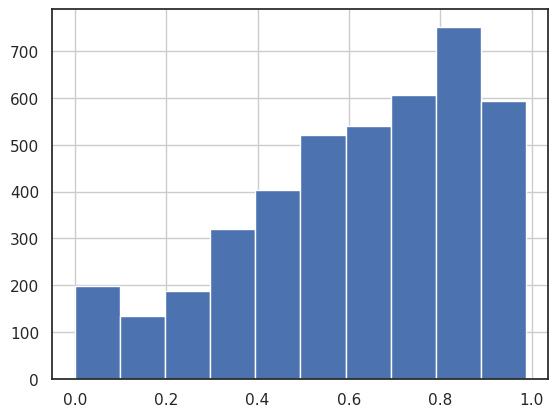

In [306]:
P1K_merged['Total_Explained_Variance'].hist(bins=10)

In [351]:
def plot_explained_variance_histogram(dataframe, column_name='Total_Explained_Variance', save_as=None):
    """
    Plots a histogram for the specified column of the dataframe with custom font, size, and limits,
    using a semi-transparent custom color for the bars. Includes a vertical red line at x=0.7.
    
    Parameters:
    dataframe (DataFrame): Input dataframe.
    column_name (str): Column to plot the histogram for.
    save_as (str): File path to save the plot as SVG. If None, the plot is not saved.
    """
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Define the custom color with 30% opacity
    color_with_opacity = (35/255, 120/255, 181/255, 0.3)  # RGBA for #2378B5 with 30% opacity

    # Create the plot
    plt.figure(figsize=(3.1, 2.5))
    plt.hist(dataframe[column_name], bins=13, color=color_with_opacity, edgecolor='black')
    plt.axvline(x=0.7, color='red', linestyle='--', linewidth=1.5, label='x=0.7')
    plt.ylim(0, 630)
    plt.title("", fontproperties=font_prop)
    plt.xlabel("Total Explained Variance", fontproperties=font_prop)
    plt.ylabel("Frequency", fontproperties=font_prop)
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    # plt.legend(prop=font_prop)
    plt.tight_layout()
    
    # Save the plot if save_as is specified
    if save_as:
        plt.savefig(save_as, format='svg')
    plt.show()

# Placeholder call (uncomment and replace `P1K_merged` with your actual dataframe)
# plot_explained_variance_histogram(P1K_merged, save_as="output_with_line.svg")


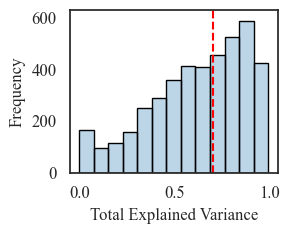

In [352]:
plot_explained_variance_histogram(P1K_merged, save_as="total_exp_var_histogram.svg")

In [353]:
Gene_Category_1_2

Total_Explained_Variance  Top_1_Explained_Variance  Top_1_iModulon  \
thrB                   0.808533                  0.254512         thrA KO   
thrC                   0.824916                  0.246587         thrA KO   
rihC                   0.839066                  0.225119           Crp-1   
caiF                   0.839462                  0.225458      Pyrimidine   
araD                   0.794265                  0.337619  FucR/AllR/AraC   
...                         ...                       ...             ...   
topAI                  0.744067                  0.274147         baeR KO   
yjgX                   0.822910                  0.366736      Cold Shock   
ybeM                   0.840978                  0.301178    minicoli KOs   
yghX                   0.906461                  0.382909            RpoS   
sgrT                   0.727338                  0.185501            UC-6   

       Top_2_Explained_Variance Top_2_iModulon  Top_3_Explained_Variance  \
thrB                   0.227884    Leu/Val/Ile                  0.103394   
thrC                   0.234486    Leu/Val/Ile                  0.155906   
rihC                   0.210690            IS5                  0.149670   
caiF                   0.193561      Cellulose                  0.101240   
araD                   0.311354        BW25113                  0.089609   
...                         ...            ...                       ...   
topAI                  0.267088          Crp-1                  0.256388   
yjgX                   0.164181   minicoli KOs                  0.105195   
ybeM                   0.206186           UC-7                  0.158738   
yghX                   0.172577           UC-2                  0.170308   
sgrT                   0.134732         pgi KO                  0.102708   

      Top_3_iModulon  num_regulators  num_iM       MAD  log_TPM_median  \
thrB         Leucine               1       2  0.698585        9.225274   
thrC       Dipeptide               1       1  0.612527        9.272277   
rihC           Crp-2               0       0  0.606837        4.242850   
caiF           Fnr-2               3       3  0.886135        4.851363   
araD            UC-2               3       3  0.580872        1.558602   
...              ...             ...     ...       ...             ...   
topAI  Tryptophanase               0       2  0.801319        2.923673   
yjgX            UC-7               0       0  0.630647        4.405094   
ybeM       Glutarate               0       0  0.465396        4.464968   
yghX            UC-8               0       1  1.073887        3.918894   
sgrT       Glycolate               4       6  0.986258        5.651568   

       range_log_tpm  quantile_range_log_tpm Variance_Category  \
thrB        7.560994                3.900854   Medium Variance   
thrC        7.647762                3.681351   Medium Variance   
rihC        6.853657                4.007938   Medium Variance   
caiF        9.844207                4.459237   Medium Variance   
araD       10.391511                3.231925   Medium Variance   
...              ...                     ...               ...   
topAI       6.499048                4.092123   Medium Variance   
yjgX        8.799003                3.565604   Medium Variance   
ybeM        7.025546                2.652893   Medium Variance   
yghX        8.628413                4.596682     High Variance   
sgrT       13.766067                5.725669   Medium Variance   

      Expression_Category                    Combined_Category  
thrB    Medium Expression  Medium Variance - Medium Expression  
thrC    Medium Expression  Medium Variance - Medium Expression  
rihC       Low Expression     Medium Variance - Low Expression  
caiF       Low Expression     Medium Variance - Low Expression  
araD       Low Expression     Medium Variance - Low Expression  
...                   ...                                  ...  
topAI      Low Expression     Me

In [363]:
row_sums = (
    Gene_Category_1_2['Top_1_Explained_Variance'] +
    Gene_Category_1_2['Top_2_Explained_Variance'] +
    Gene_Category_1_2['Top_3_Explained_Variance']
)

row_sums[row_sums > 0.7].count()

177

In [562]:
P1K_merged.loc['sucA']

Total_Explained_Variance                             0.571306
Top_1_Explained_Variance                             0.147337
Top_1_iModulon                                          NDH-1
Top_2_Explained_Variance                             0.134546
Top_2_iModulon                                           ArcA
Top_3_Explained_Variance                             0.097591
Top_3_iModulon                                          Crp-2
num_regulators                                              8
num_iM                                                      0
MAD                                                  0.774047
log_TPM_median                                       8.737696
range_log_tpm                                        6.853395
quantile_range_log_tpm                               3.812865
Variance_Category                             Medium Variance
Expression_Category                           High Expression
Combined_Category           Medium Variance - High Expression
Name: su